<a href="https://colab.research.google.com/github/ciencialatitud0/EPIC_2/blob/main/Day3/Astrophysics/Theoretical-Astrophysics/astrophysics_tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Astrophysics 2: Tutorial

We will analyse a 2D simulation of a cloud-cloud collision in the interstellar medium.

Please get the data from this link:

https://drive.google.com/file/d/1PNz8w2msx74K-N8wkAp7jjApkpZpGUKo/view?usp=sharing



In [1]:
# Then, we need to install pyvista

!pip install pyvista

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 15.3 MB/s 
     |████████████████████████████████| 79.3 MB 106 kB/s 


# Import Libraries

In [2]:
# Import useful libraries

import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import pandas as pd

# Load Google Colab

In [3]:
# First let's mount our Drive folder:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# To display the contents

!ls "/content/drive/My Drive/Colab Notebooks"

 2a_python_classes.ipynb	    figures_simulation
 2b_fourier_transforms.ipynb	    homework_data
 2c_python_II_lecture.ipynb	    homework-python.ipynb
 2d_python_II_CFDdata.ipynb	    homework-python-solutions.ipynb
 408-Fourier-filtering-2D.ipynb     images
 409-Fourier-Image-Analysis.ipynb   my_first_julia_notebook.ipynb
 astrophysics-tutorial2.ipynb	    my_first_python_notebook.ipynb
 Cloud-Cloud			   'Pload_vtk_tools (1).ipynb'
 Cotopaxi_volcano.jpeg		    simulation_data


# Function to load the VTK data fields

In [5]:
# I/O function to read the VTK data:

def pload_vtk(file_name):
    """Read Pluto's VTK simulation files and returns the variables in CGS units"""
    
    # Path to files
    input_directory="/content/drive/My Drive/Colab Notebooks/Cloud-Cloud/"
    file_name = file_name
    times_file = "vtk.out"
    
    # Normalisation values
    l0 = 3.086e+19               # Length is 10pc
    v0 = 1.000e+06               # Velocity is 144km/s
    rho0 = 1.115e-22             # In g/cm^3
    mu = 2.3                     # Mean particle mass
    mm = 1.660E-24               # 1 Atomic mass unit
    prs0 = (rho0*(v0**2))        # Pressure in dy/cm^2
    kb = 1.380E-16               # in CGS units
    tem0 = (mu*(mm*(v0**2))/kb)  # in K

    # Standard VTK loading routines
    mesh = pv.read(input_directory+file_name)

    # Get data using hearder information

    rho = pv.get_array(mesh, "rho", preference = 'cell') #density in code units
    prs = pv.get_array(mesh, "prs", preference = 'cell') #pressure in code units
    vx1 = pv.get_array(mesh, "vx1", preference = 'cell') #vx in code units
    vx2 = pv.get_array(mesh, "vx2", preference = 'cell') #vy in code units
    tr1 = pv.get_array(mesh, "tr1", preference = 'cell') #tracer 1
    tr2 = pv.get_array(mesh, "tr2", preference = 'cell') #tracer 2    
    
    # Copy data into numpy arrays
    rho = np.array(rho)
    prs = np.array(prs)
    tr1 = np.array(tr1)
    tr2 = np.array(tr2)
    vx1 = np.array(vx1)
    vx2 = np.array(vx2)
    
    # Reshape them into 2D arrays
    rho_2D = rho.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    prs_2D = prs.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    vx1_2D = vx1.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    vx2_2D = vx2.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    tr1_2D = tr1.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    tr2_2D = tr2.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    tem_2D = prs_2D/rho_2D
    
    # In astrophysical units
    rho_2D = rho_2D*rho0       # Gas density in g/cm^3
    nrh_2D = rho_2D/(mu*mm)    # Gas number density in cm^-3
    prs_2D = prs_2D*prs0/kb    # Pressure in K/cm^3
    vx1_2D = vx1_2D*v0/1.e5    # X-velocity component in km/s
    vx2_2D = vx2_2D*v0/1.e5    # Y-velocity component in km/s
    tem_2D = tem_2D*tem0       # Gas temperature in K

    # Mesh information
    meshbounds = mesh.bounds
    meshdimensions = mesh.dimensions
    
    # Times
    times = ascii.read(input_directory+times_file)
    times = np.array(times['col2'])*l0/v0 # 1D array containing the simulation time in seconds
    
    return times, rho_2D, nrh_2D, prs_2D, tr1_2D, tr2_2D, vx1_2D, vx2_2D, tem_2D, meshbounds, meshdimensions
    # tr1 is a cloud material tracer

In [6]:
# Example for file 0000

times, rho, nrh, prs, tr1, tr2, vx1, vx2, tem, meshbounds, meshdimensions = pload_vtk('data.0000.vtk')

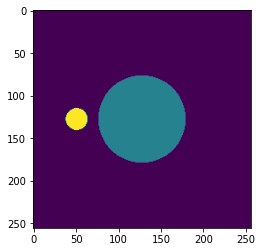

In [7]:
plt.imshow(rho)

# Function to make 2D maps

In [8]:
def make_2D_plot(meshbounds, meshdimensions, image_2D):
    """Make 2D maps"""

    # Create a 2D grid using metadata information

    x = np.linspace(meshbounds[0], meshbounds[1], meshdimensions[0] - 1)
    y = np.linspace(meshbounds[2], meshbounds[3], meshdimensions[1] - 1)

    X, Y = np.meshgrid(x, y)

    # And we are ready to interpolate our data onto the mesh:

    plt.figure(figsize = (12,10))

    Z = plt.pcolor(X, Y, image_2D, cmap = 'magma', vmin=0, vmax=1.e-21)

    plt.colorbar(Z)

    plt.show()

    #plt.savefig("/content/drive/My Drive/Colab Notebooks/figures_simulation/dens{:03d}.png".format(i))

    plt.close()

# 2D maps of different data fields:

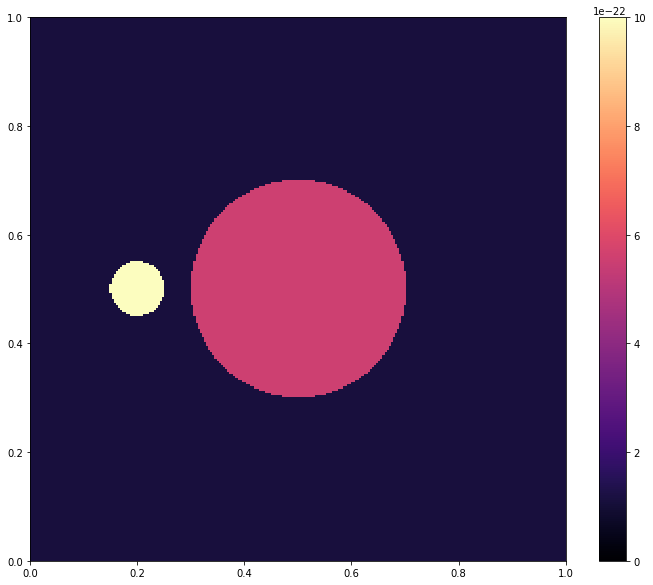

In [9]:
make_2D_plot(meshbounds, meshdimensions, rho)

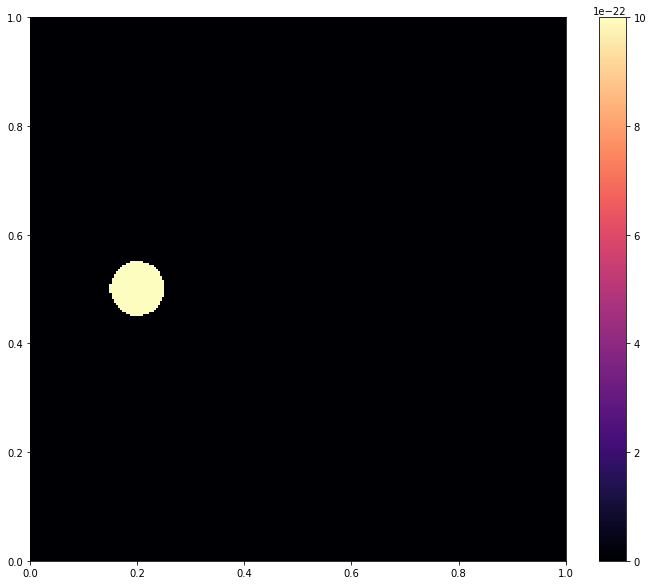

In [10]:
make_2D_plot(meshbounds, meshdimensions, tr1)

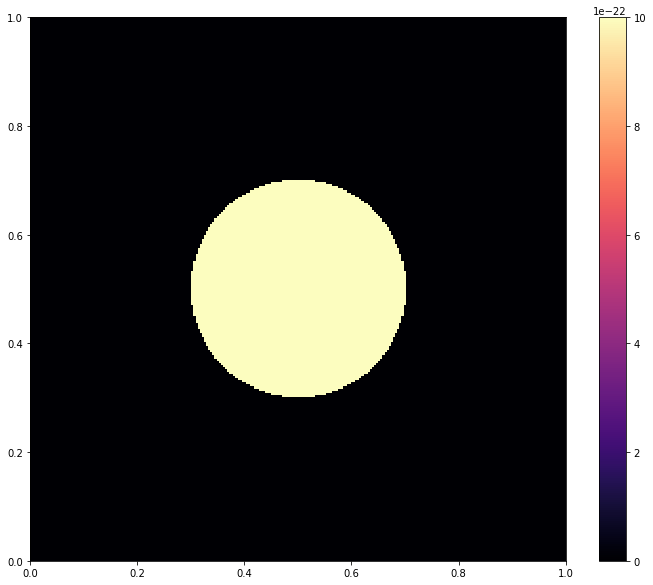

In [11]:
make_2D_plot(meshbounds, meshdimensions, tr2)

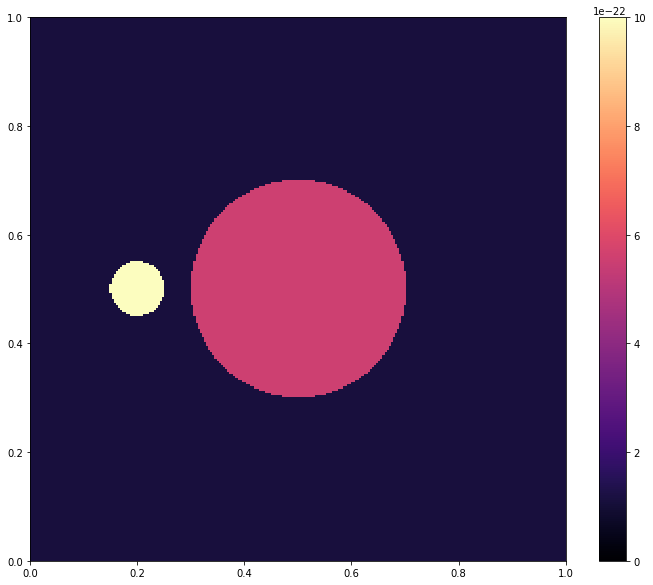

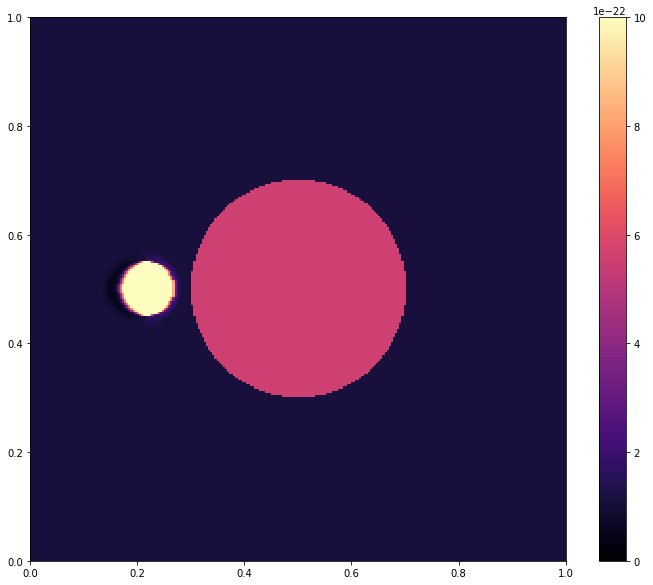

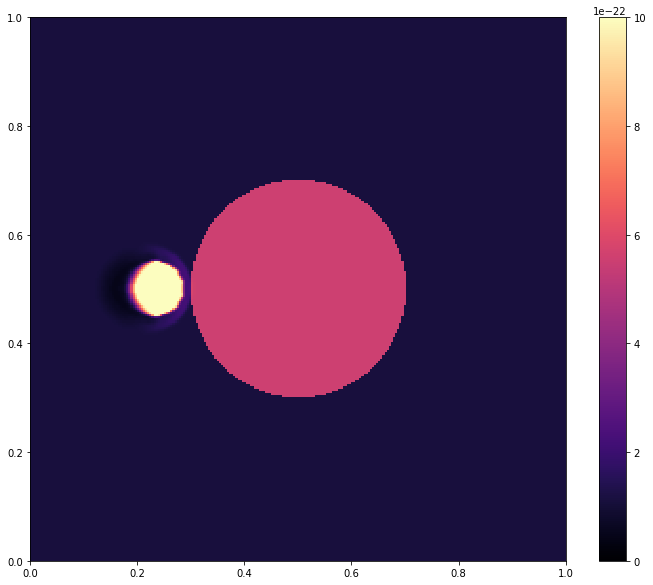

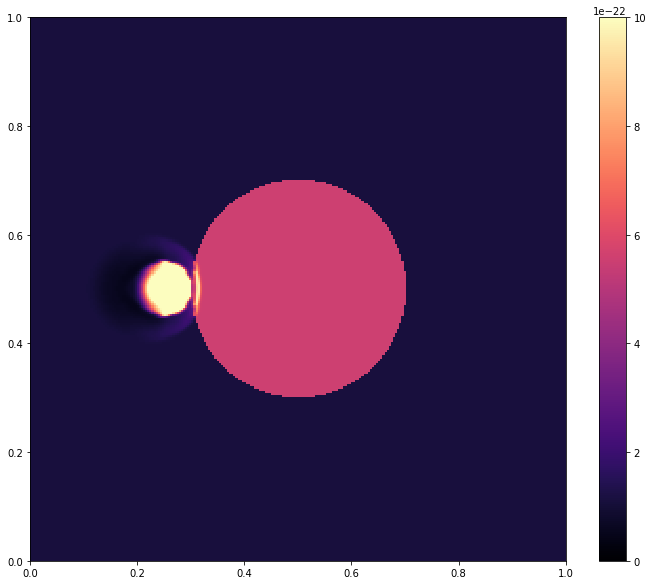

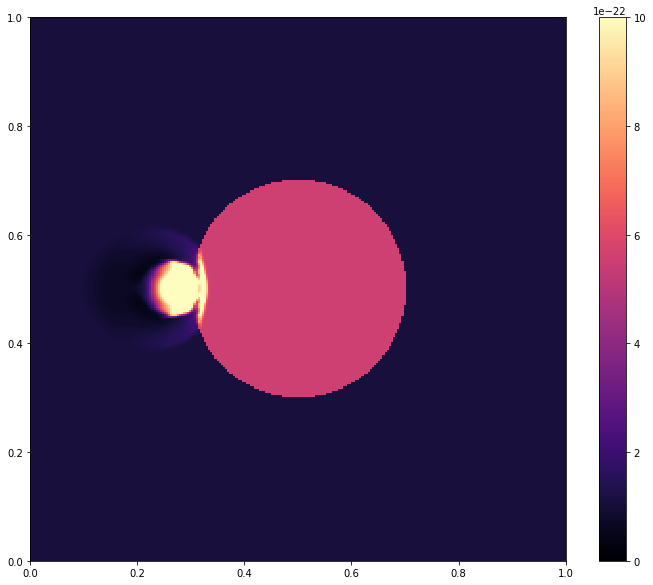

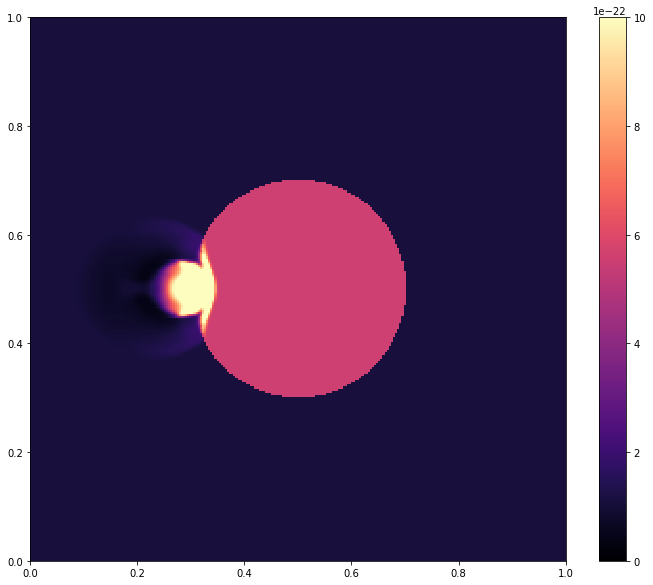

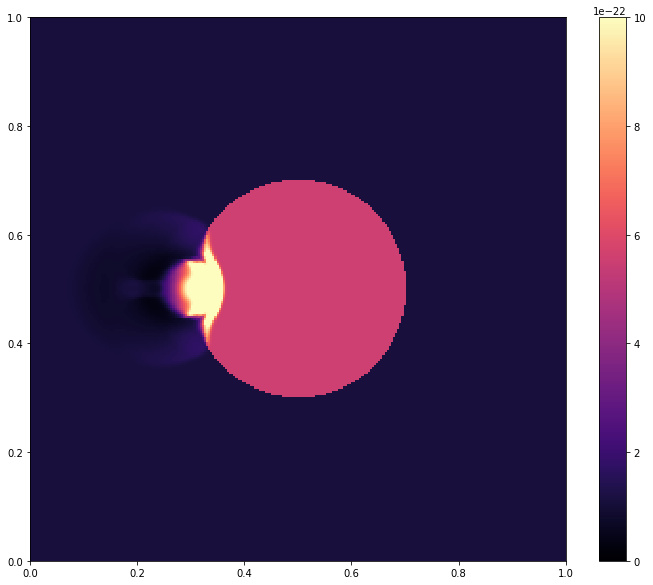

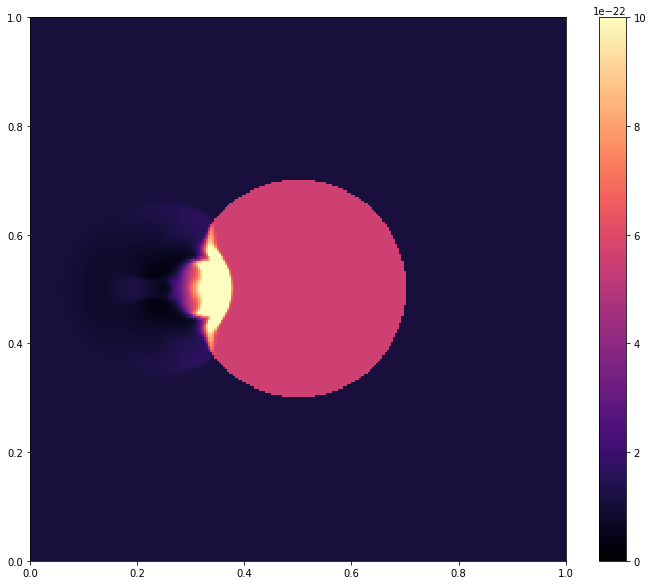

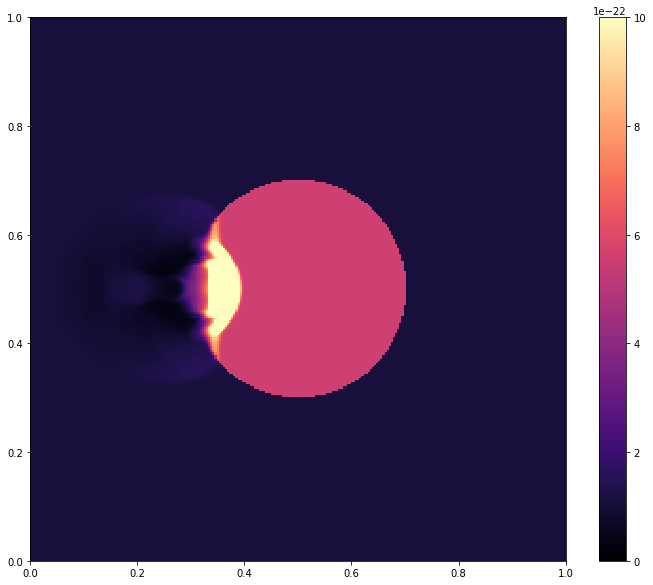

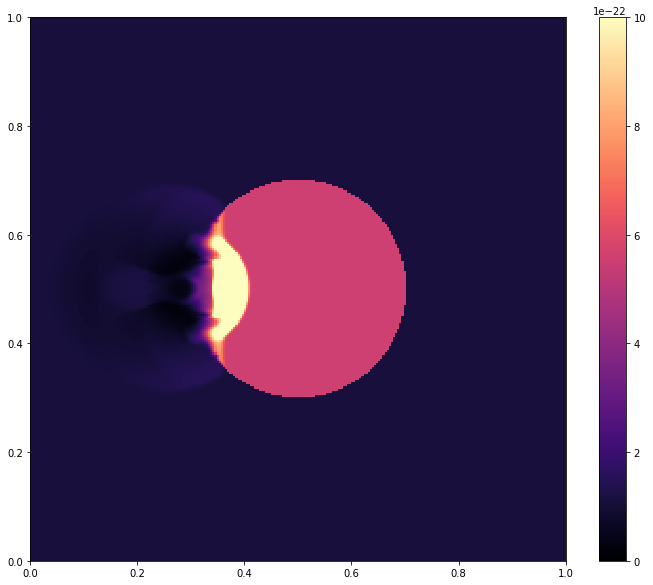

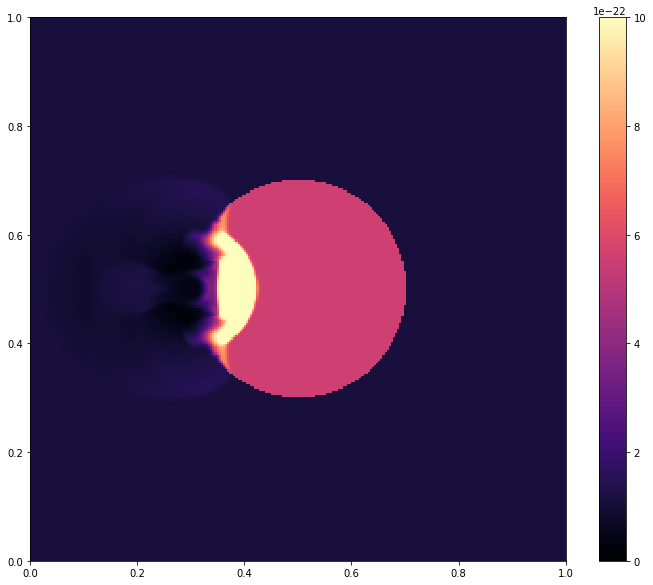

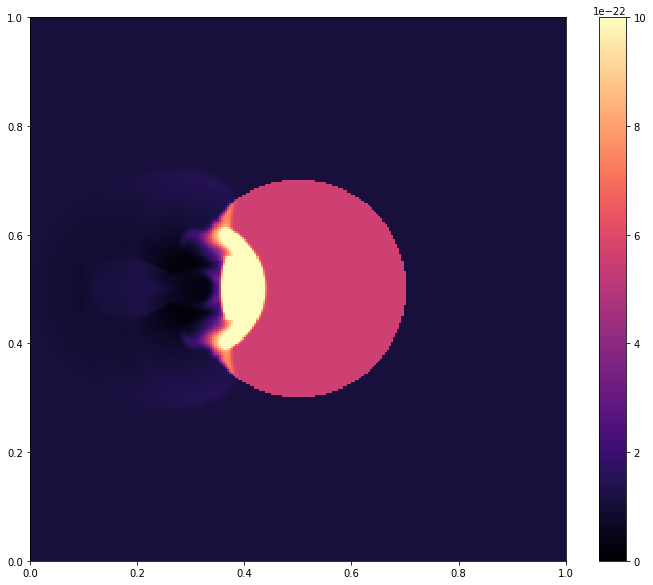

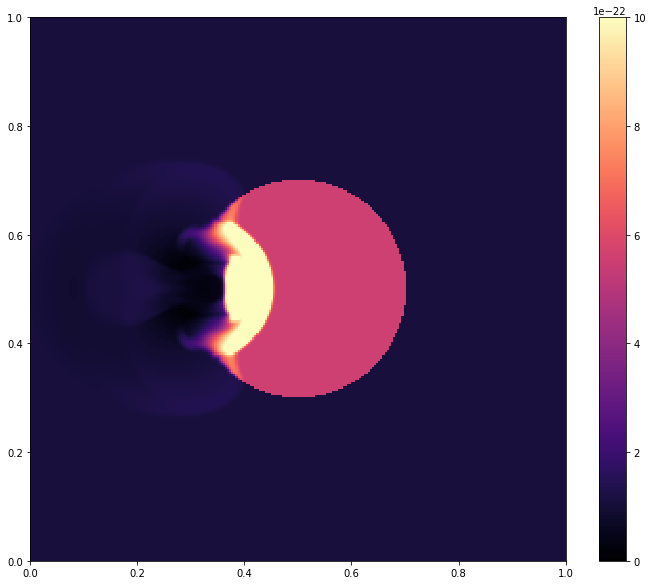

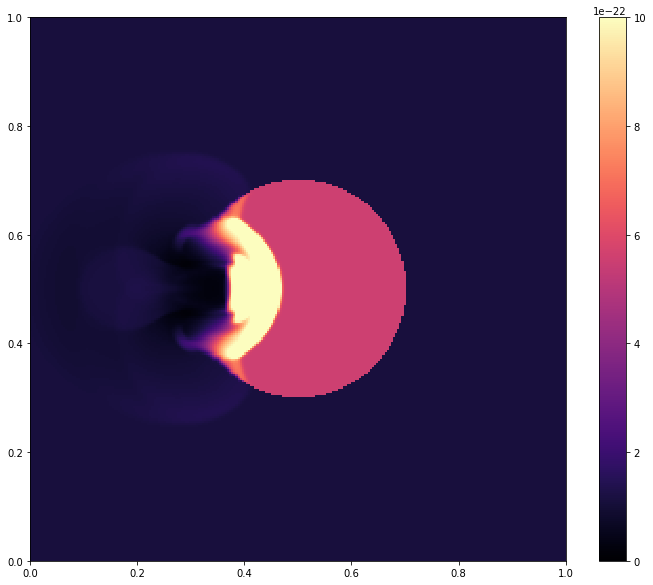

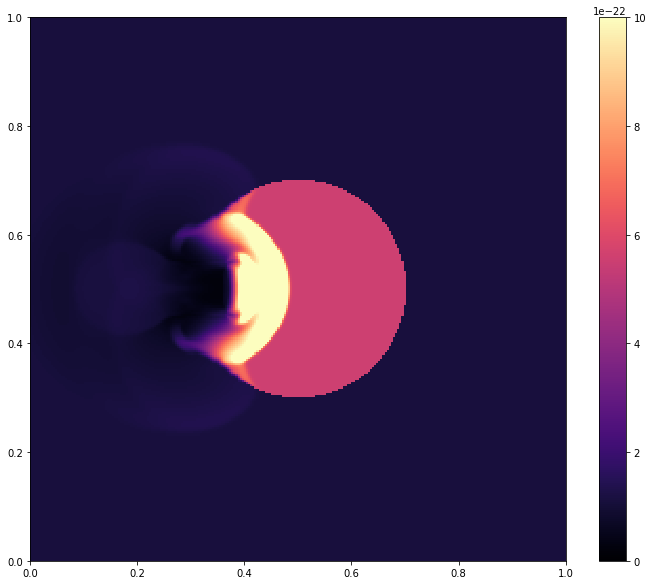

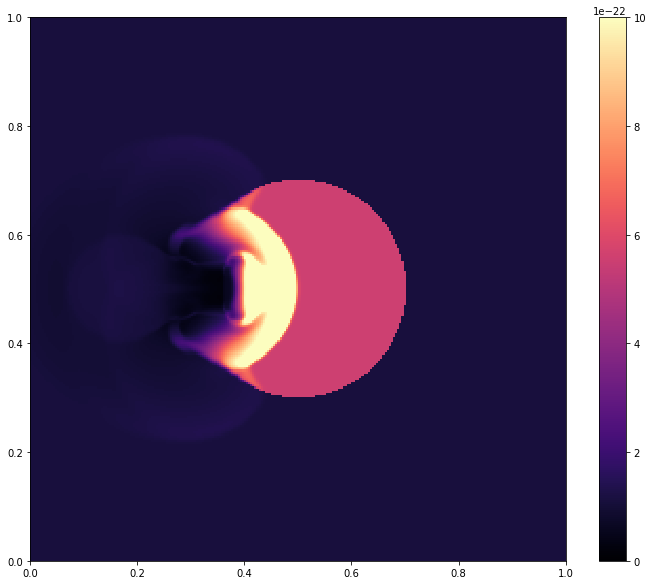

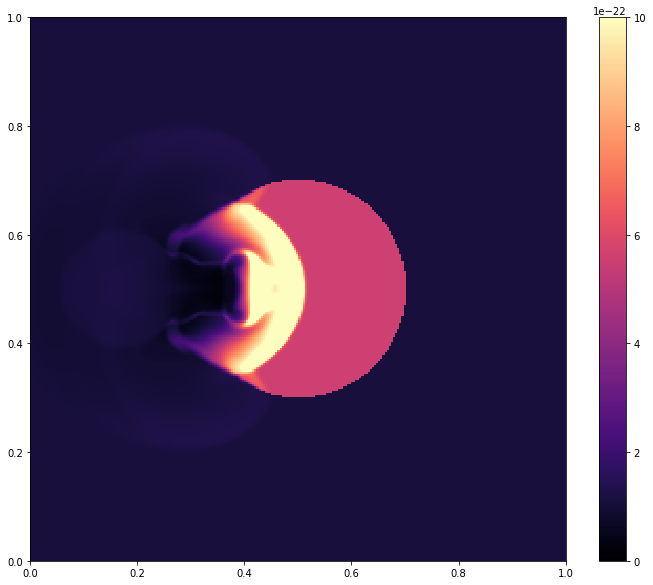

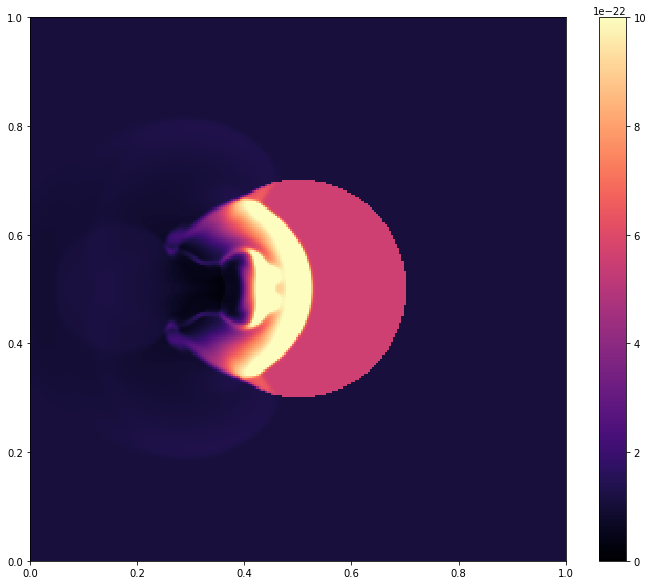

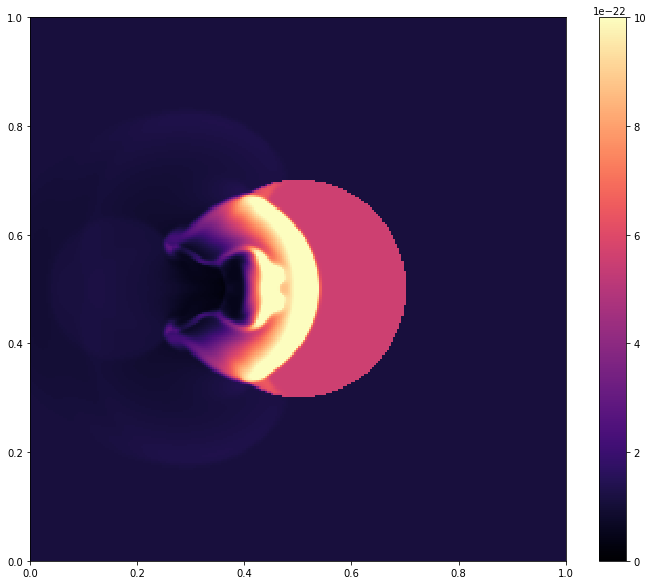

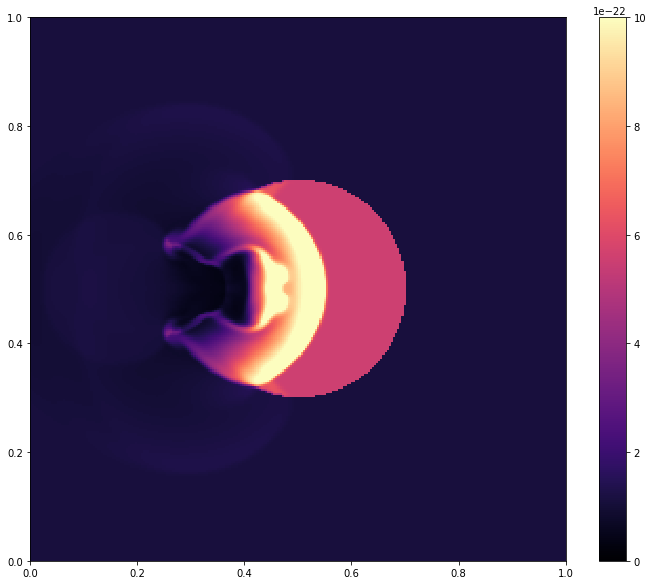

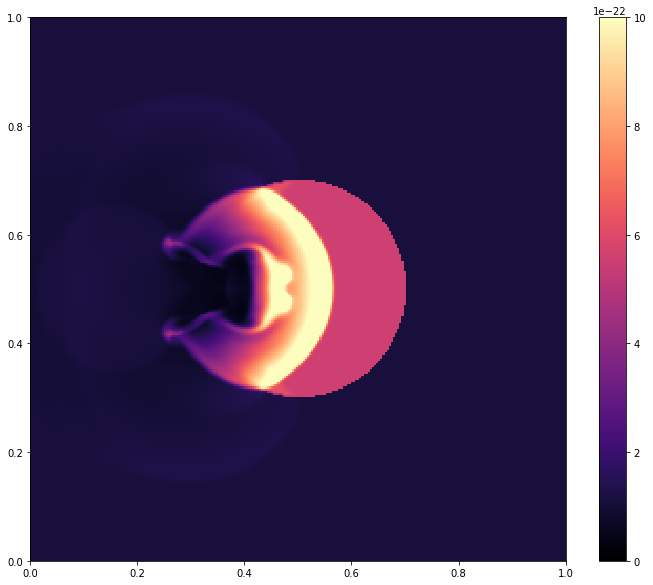

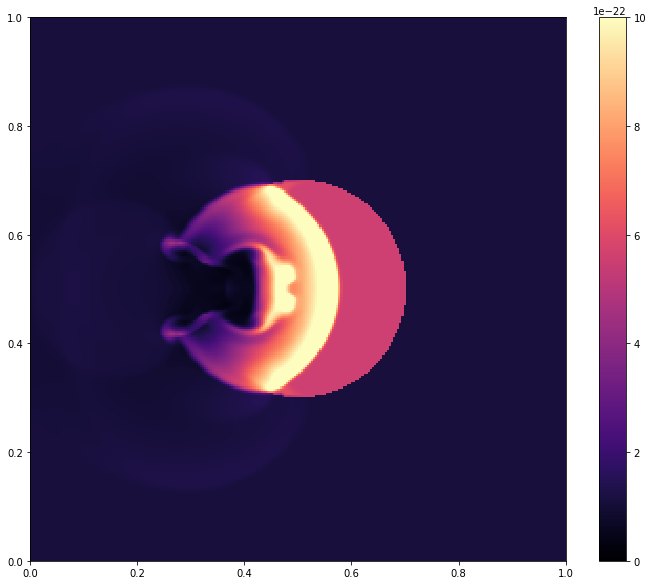

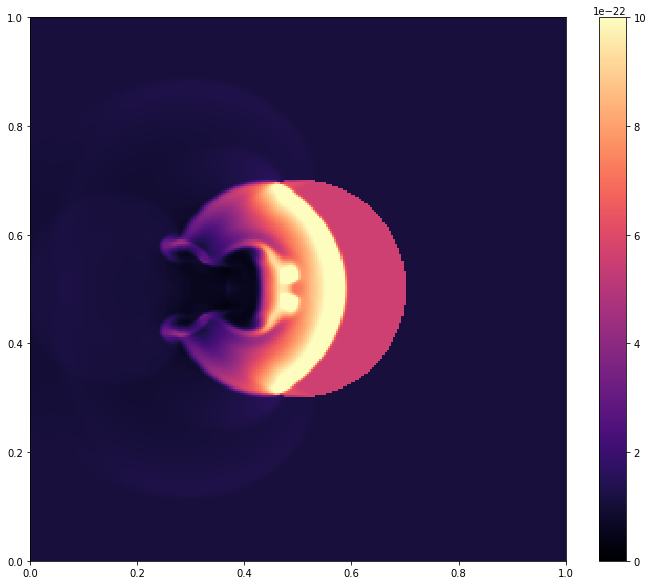

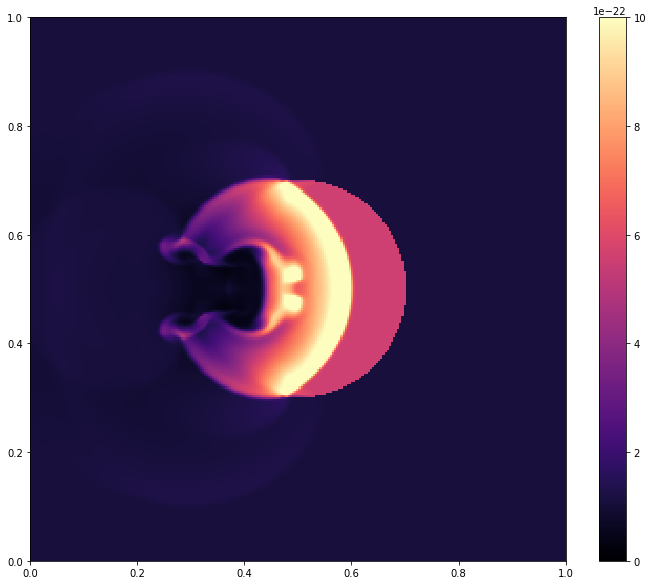

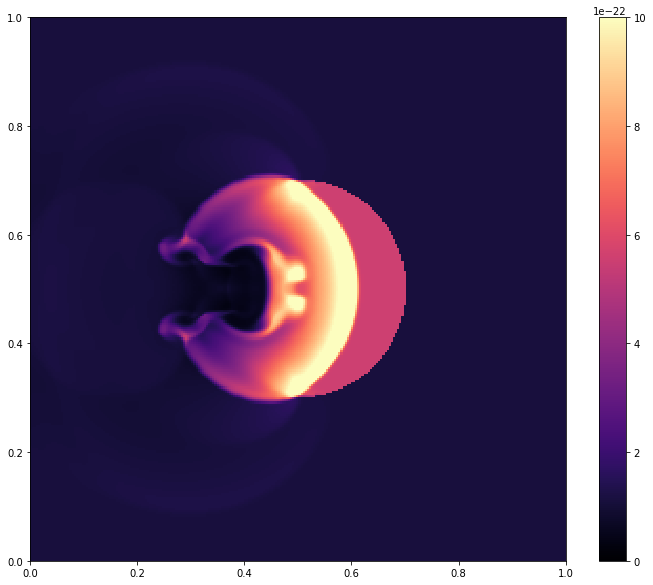

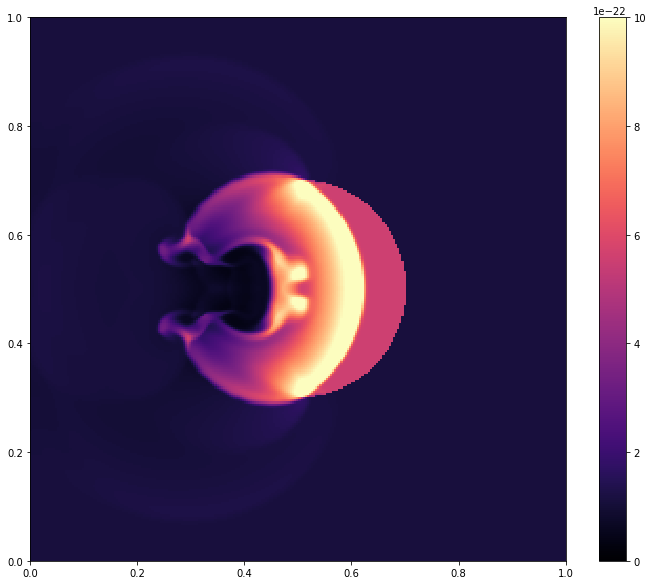

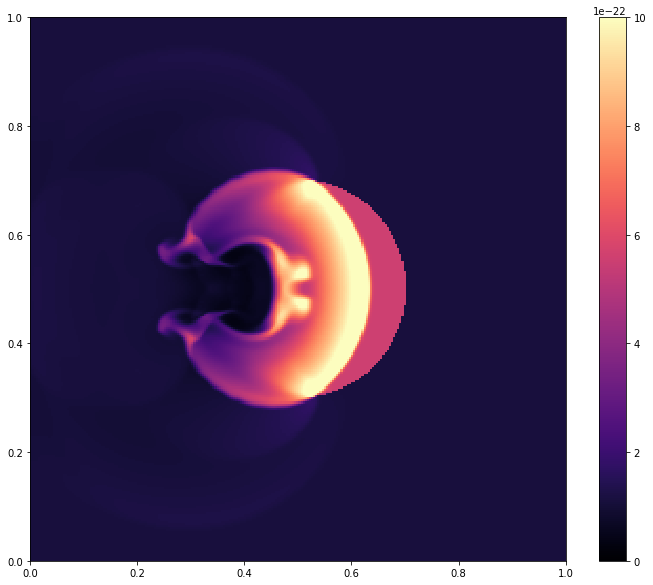

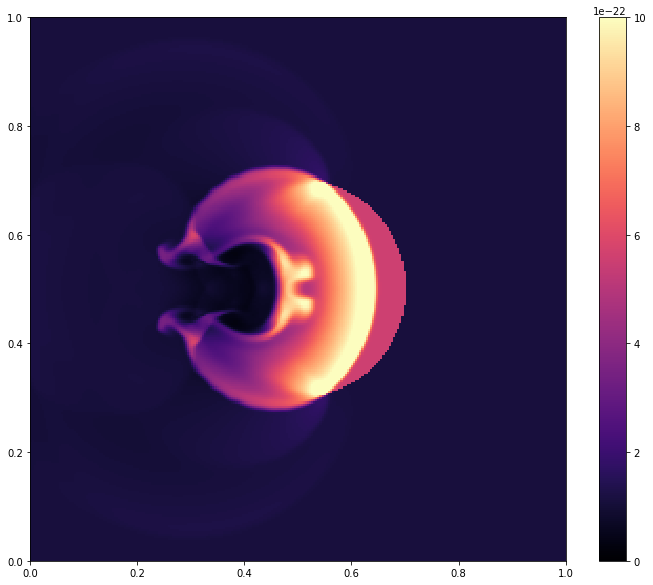

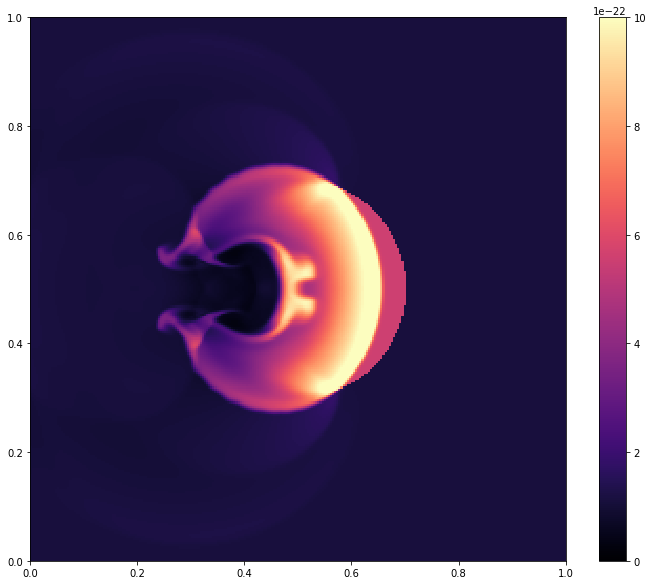

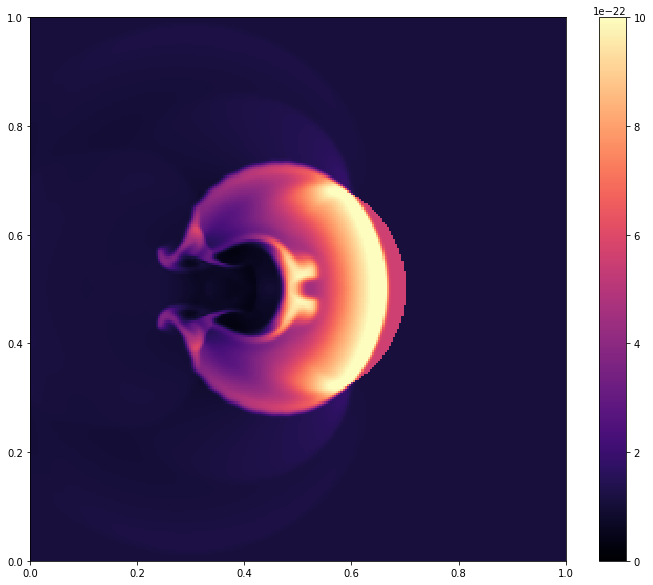

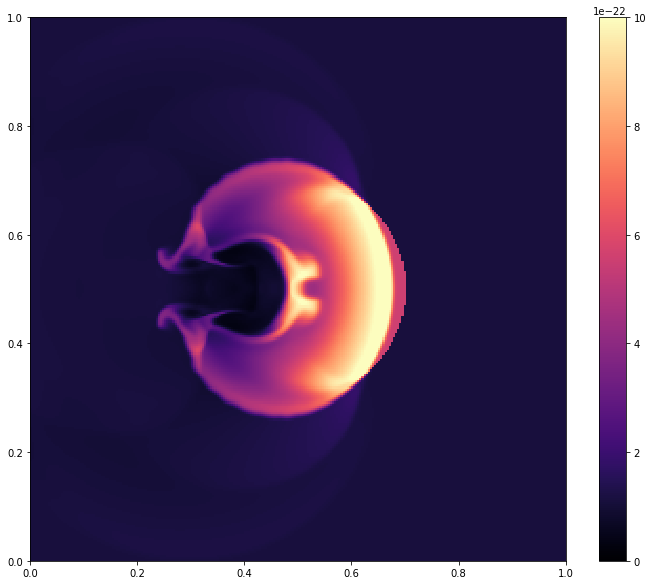

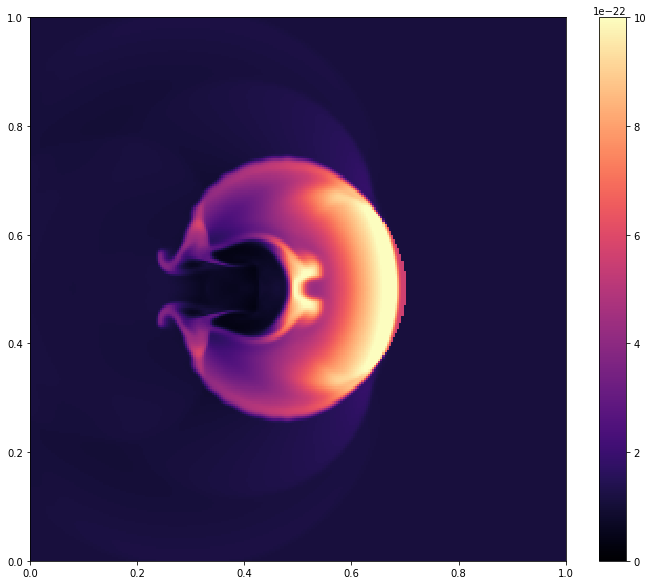

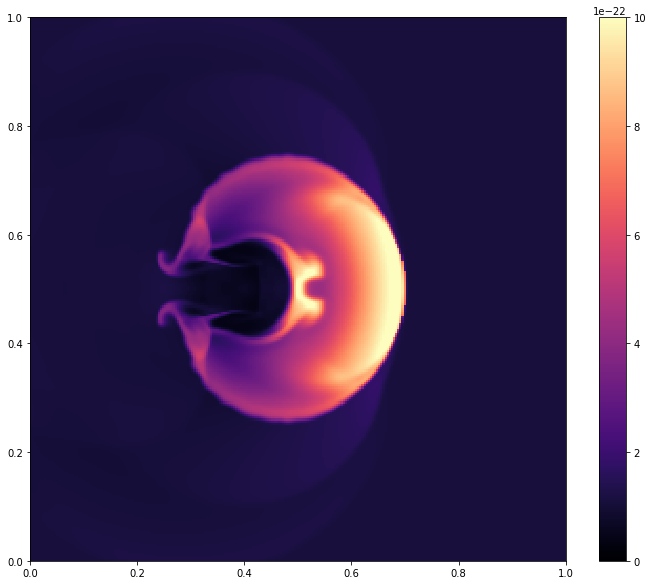

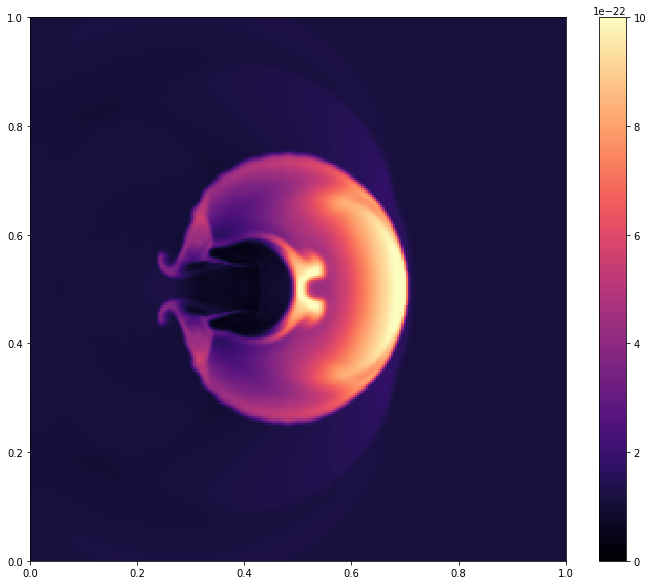

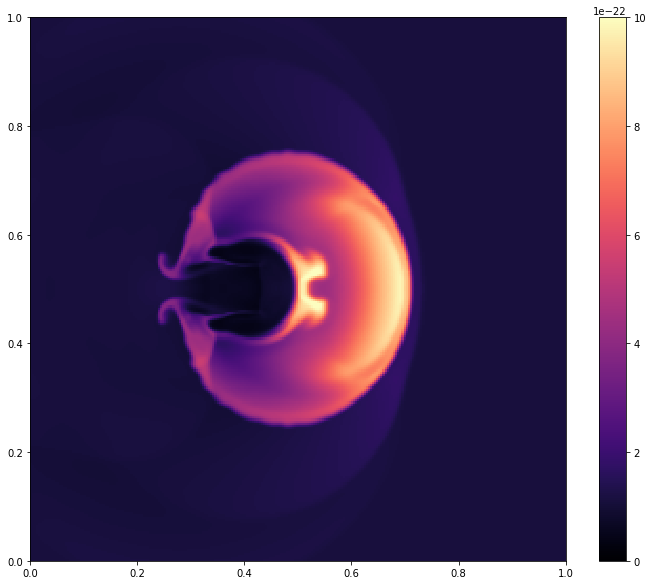

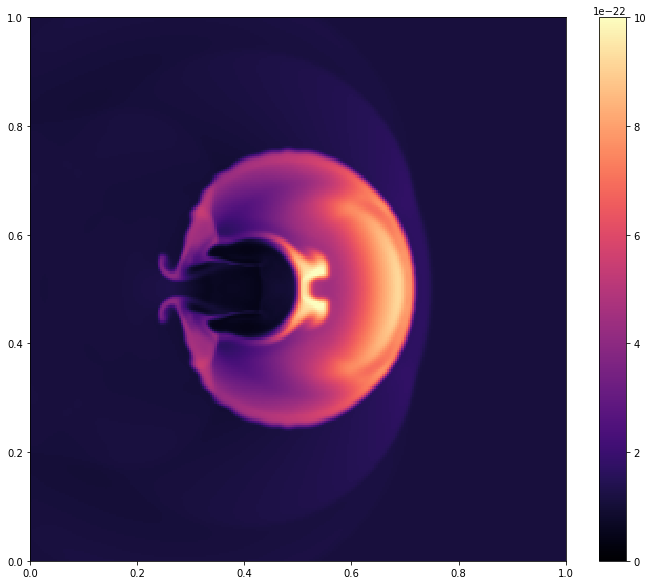

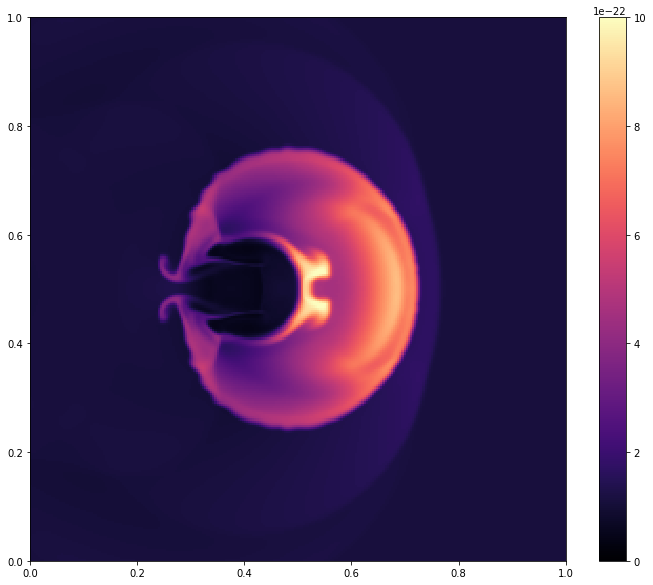

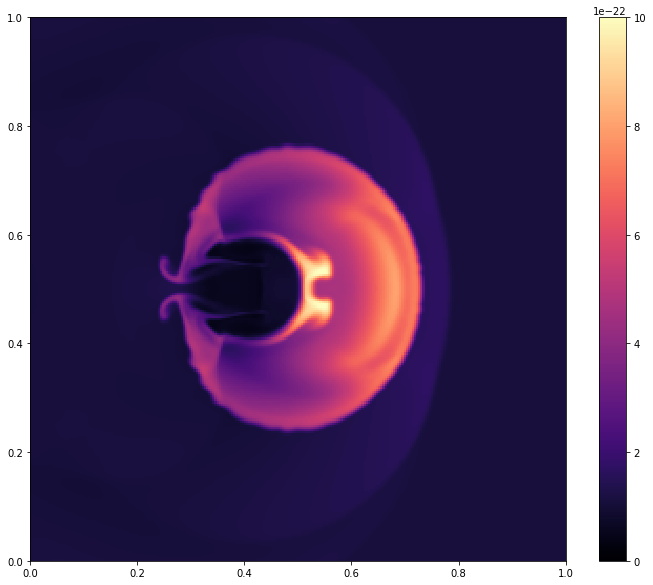

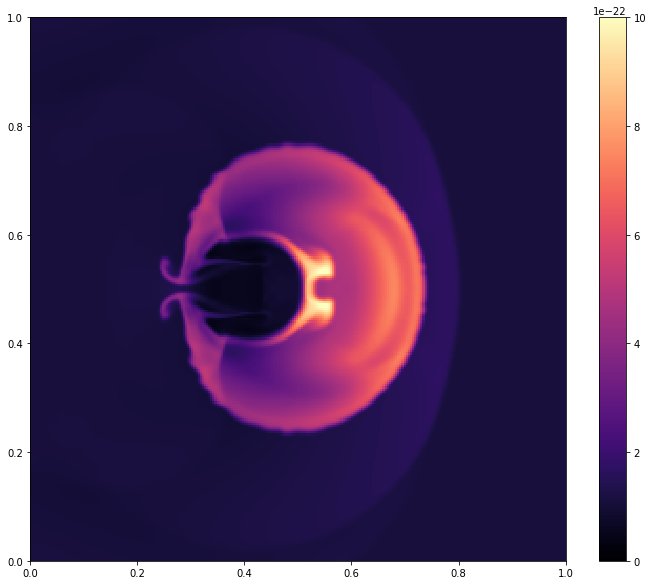

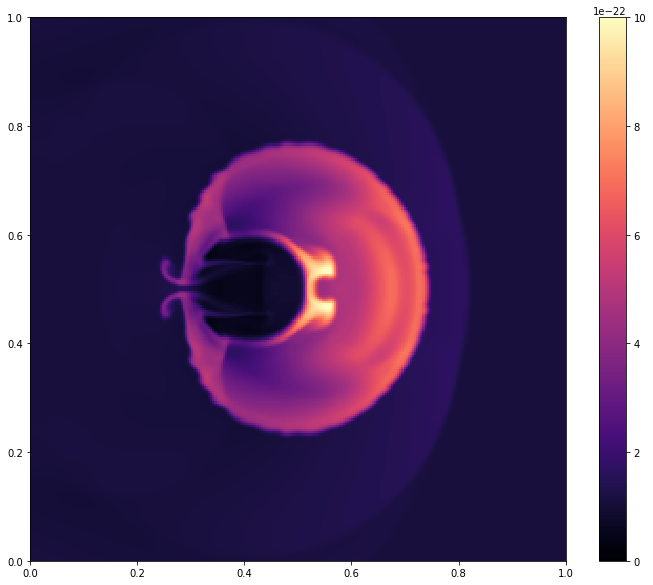

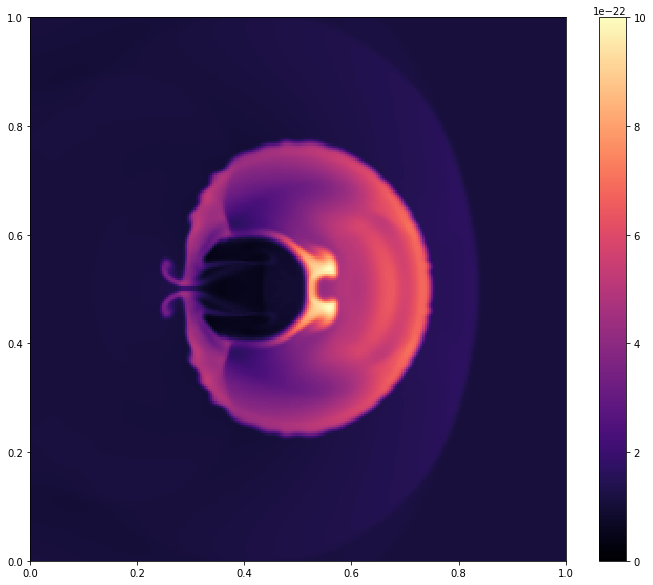

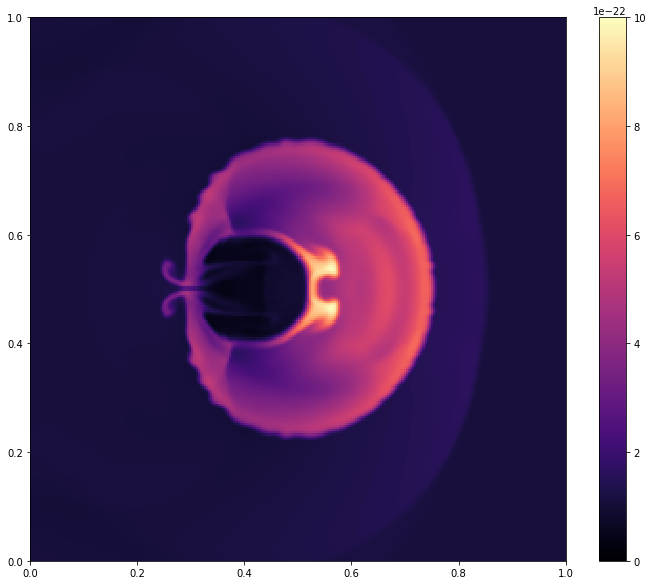

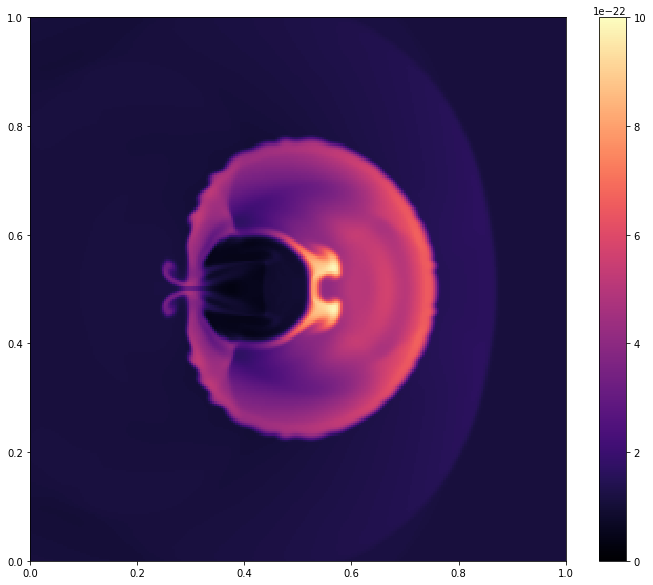

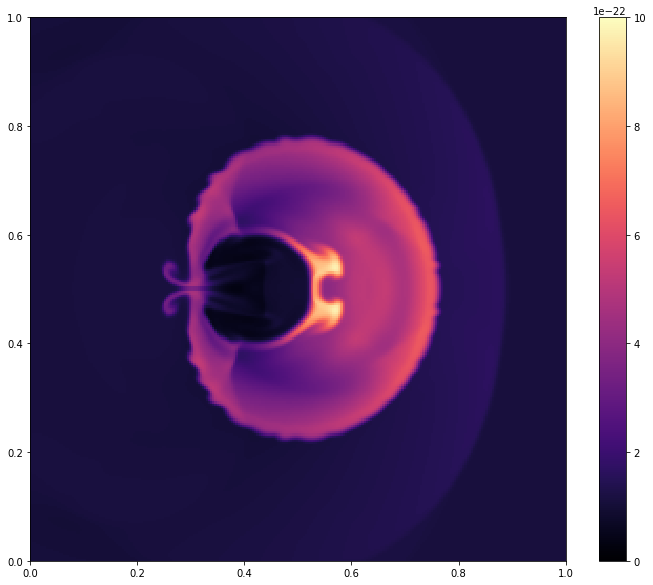

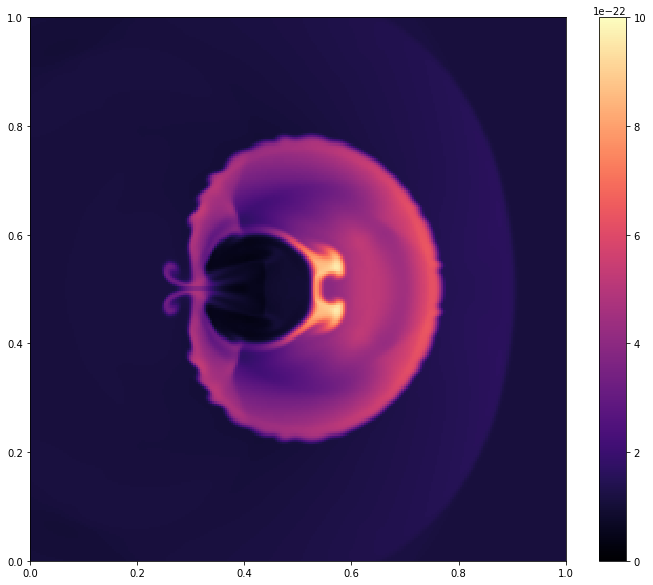

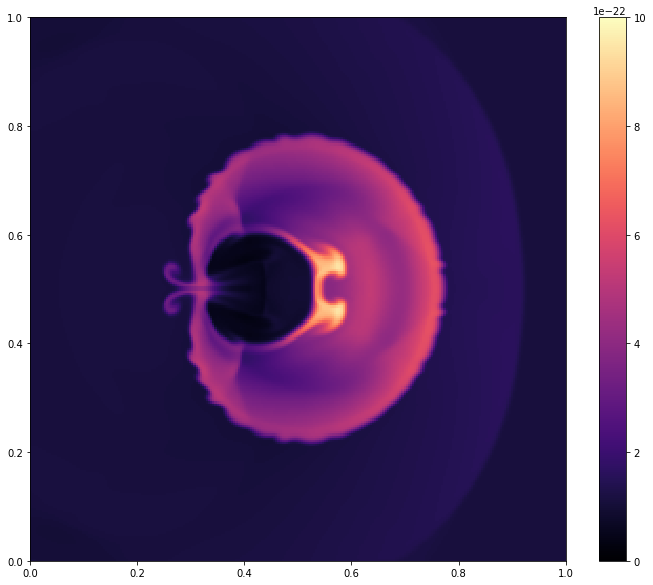

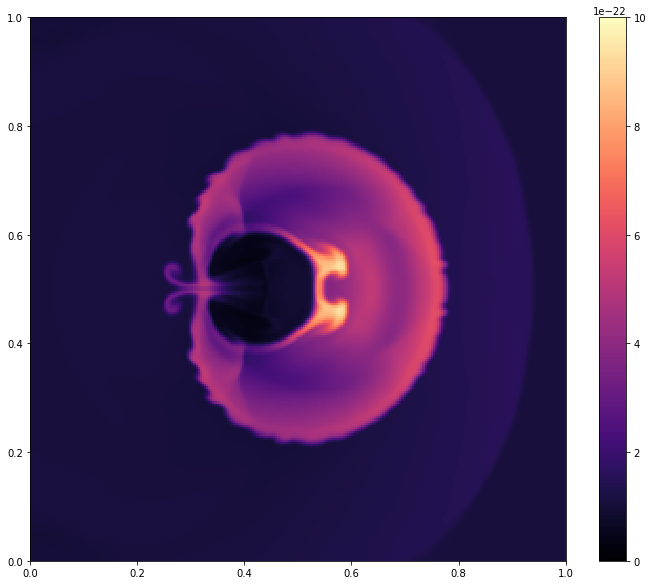

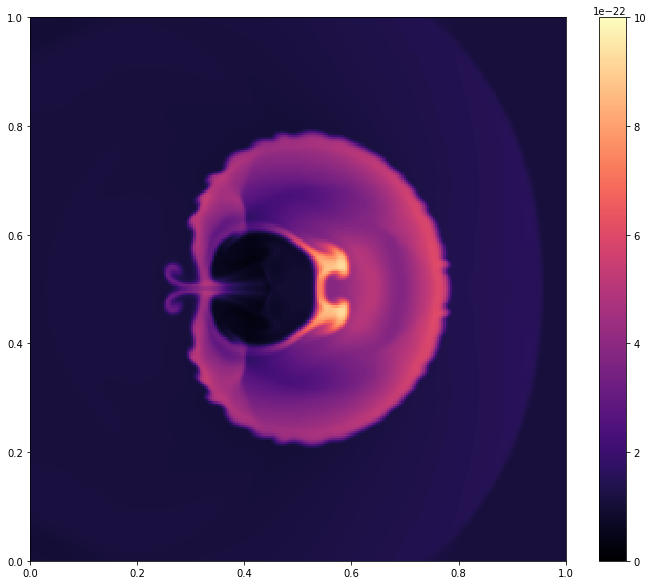

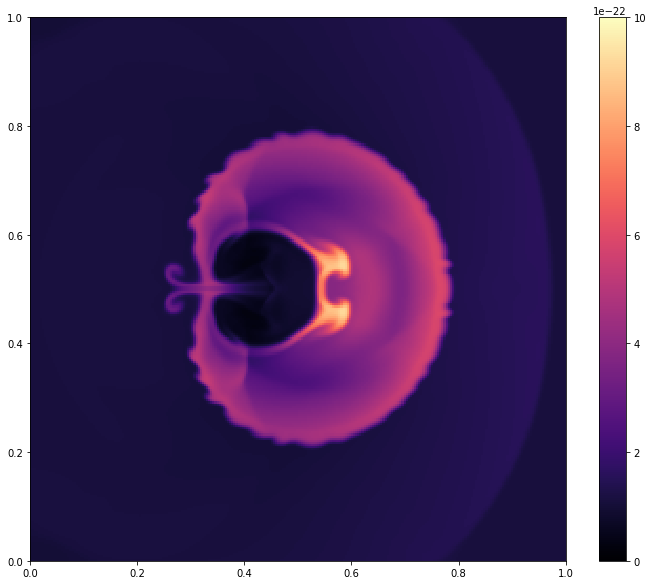

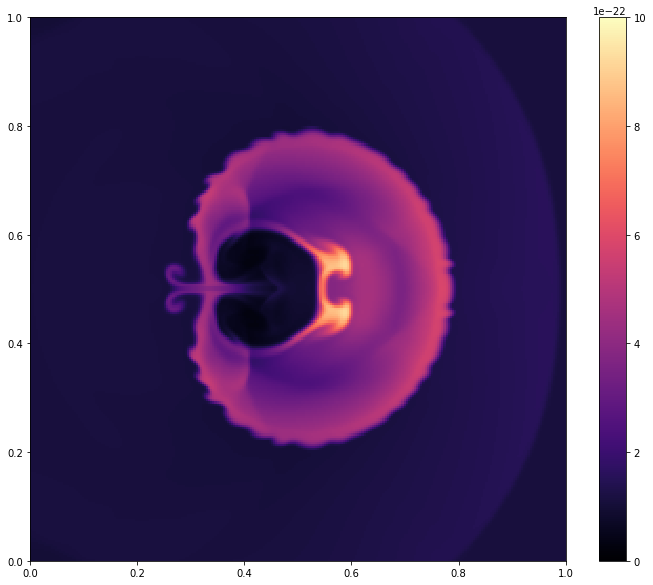

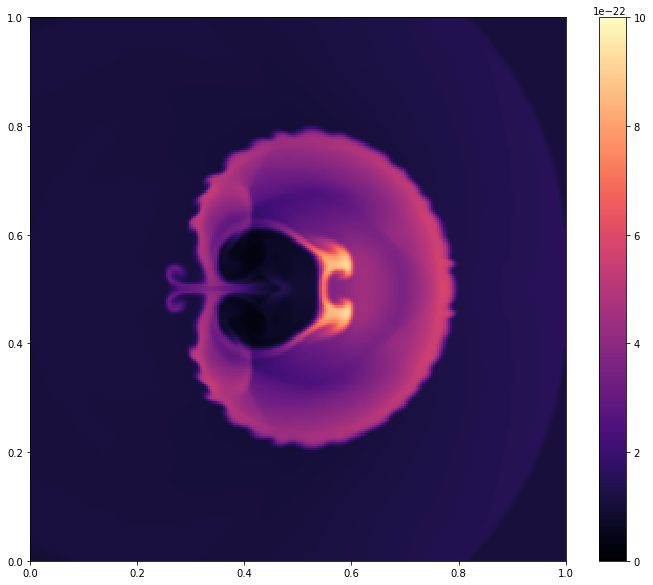

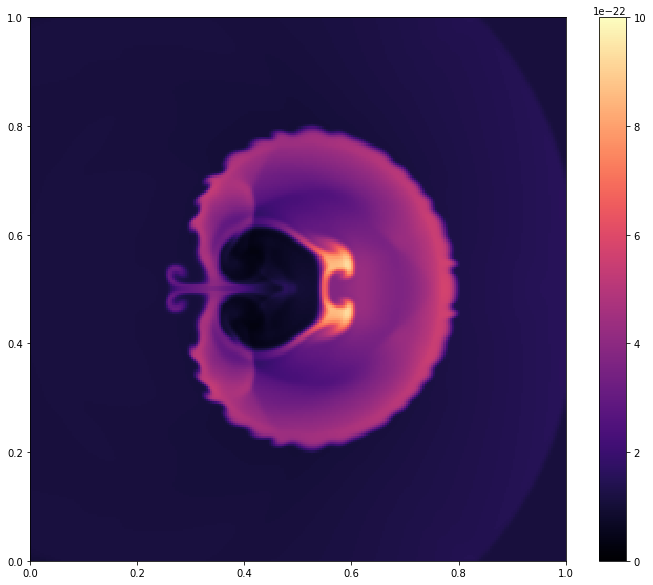

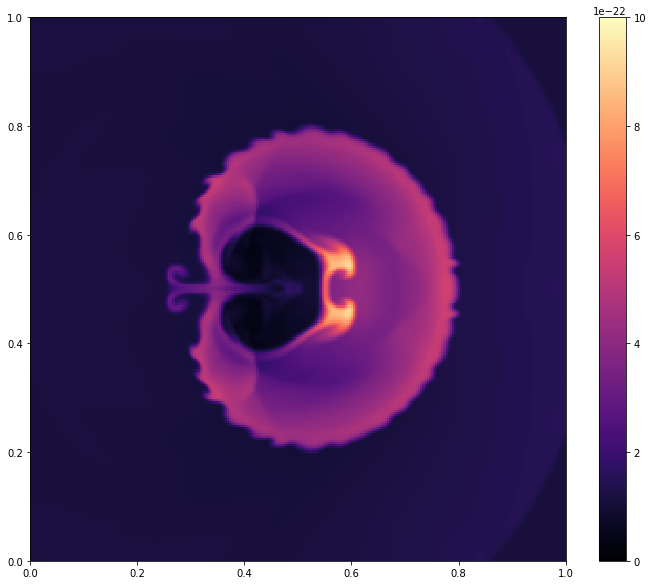

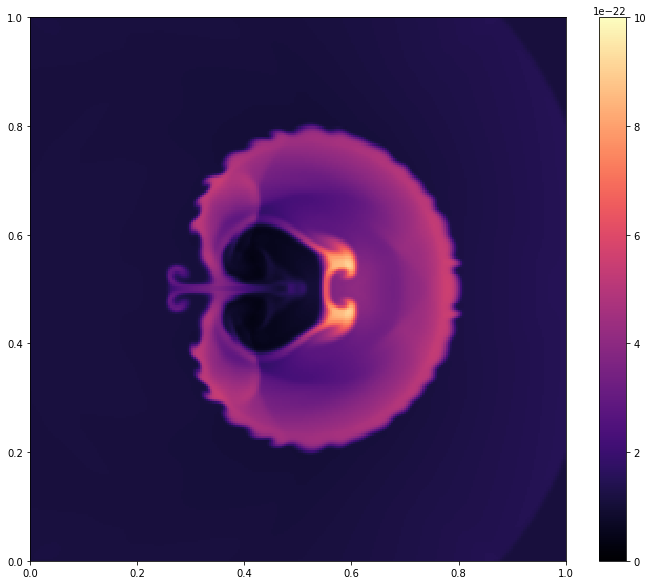

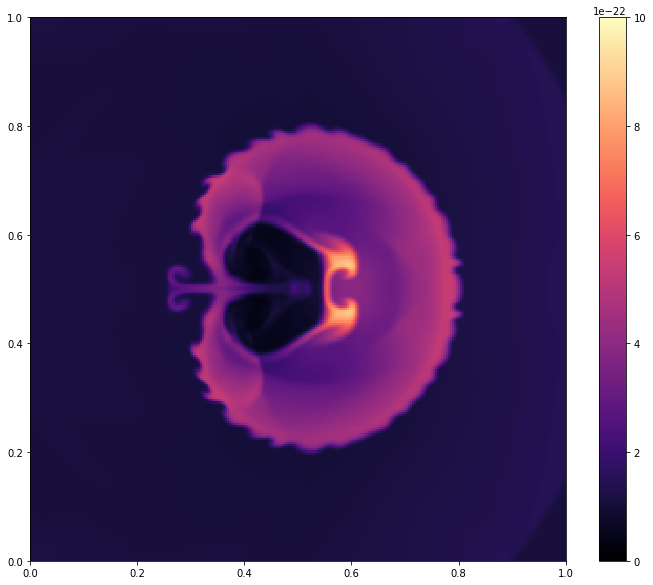

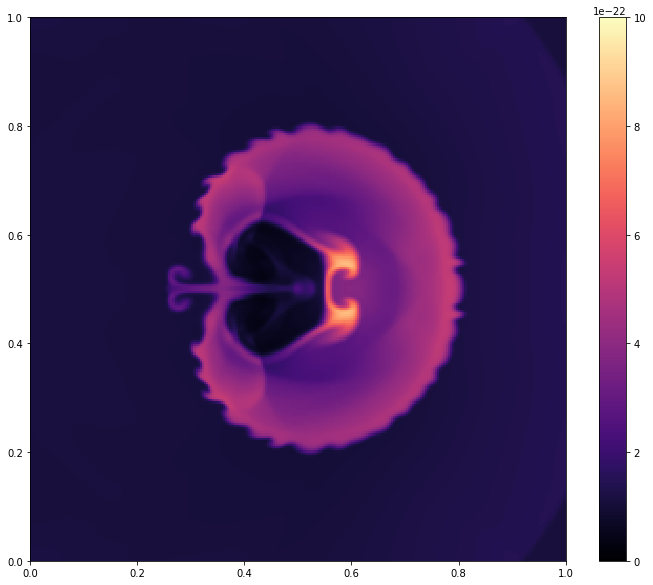

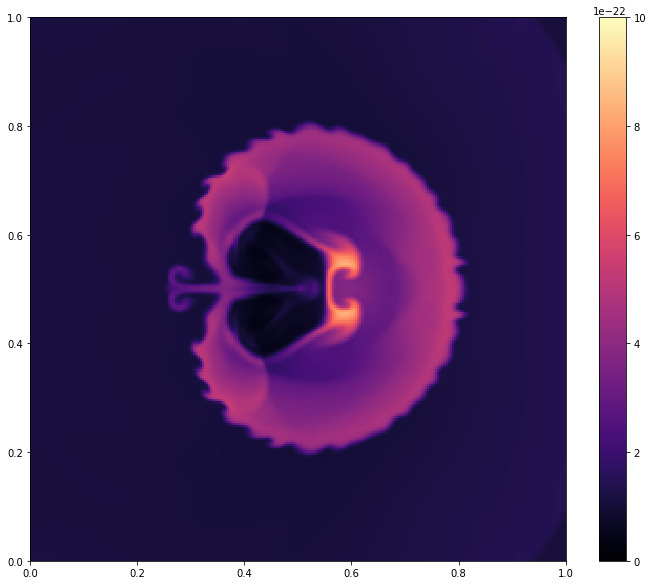

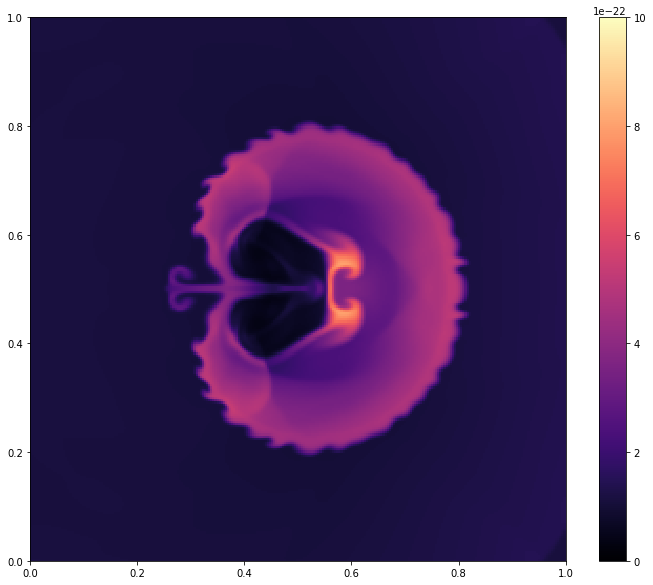

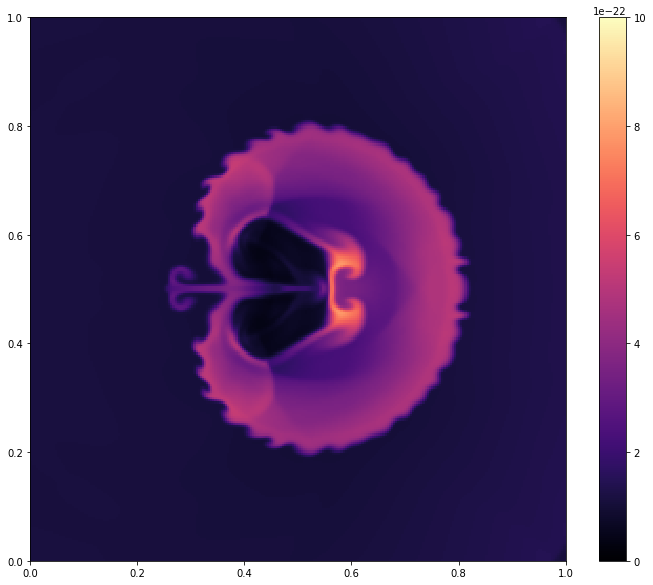

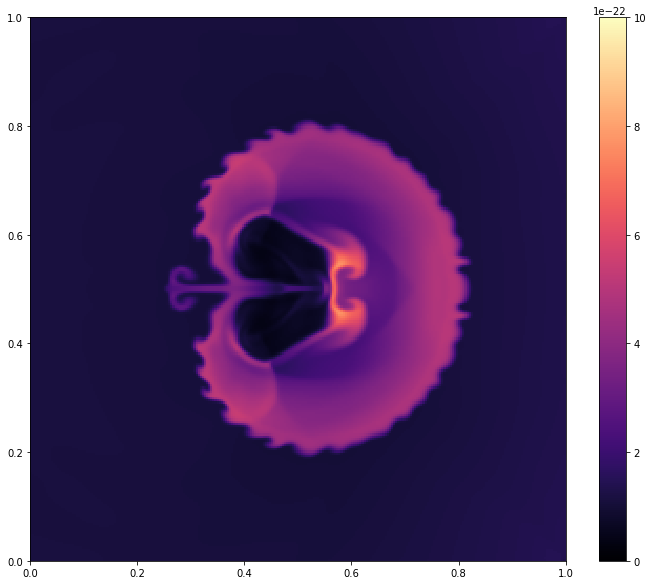

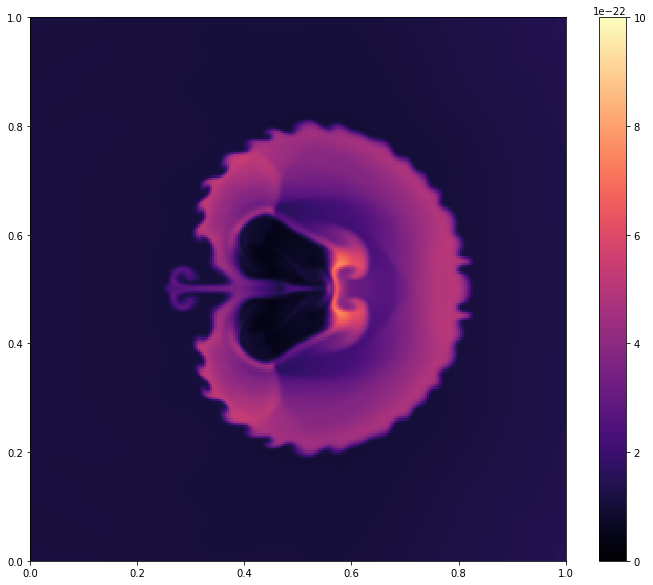

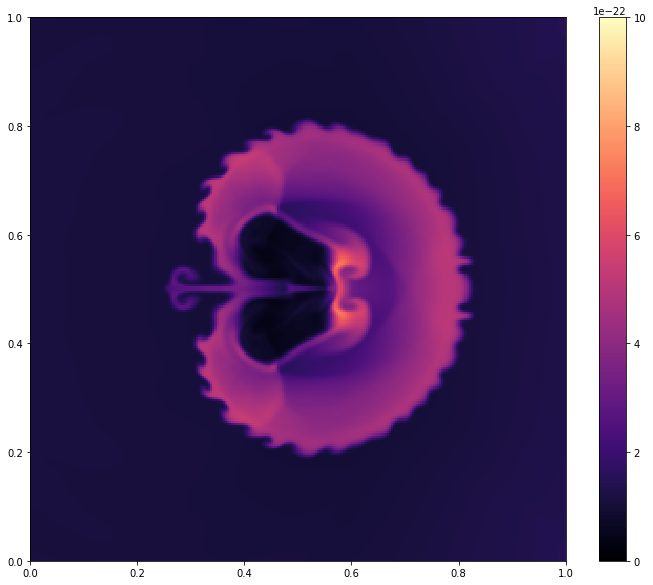

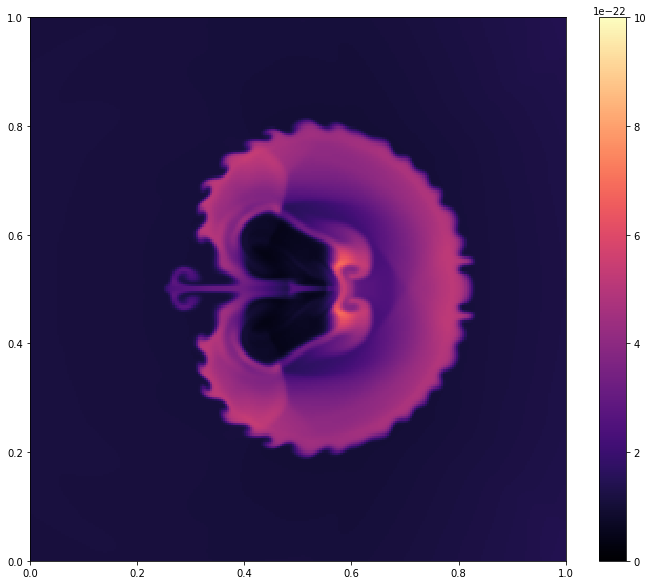

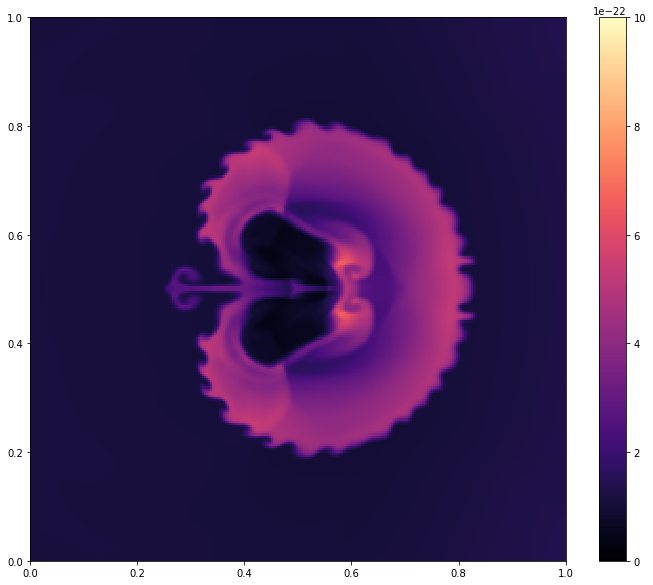

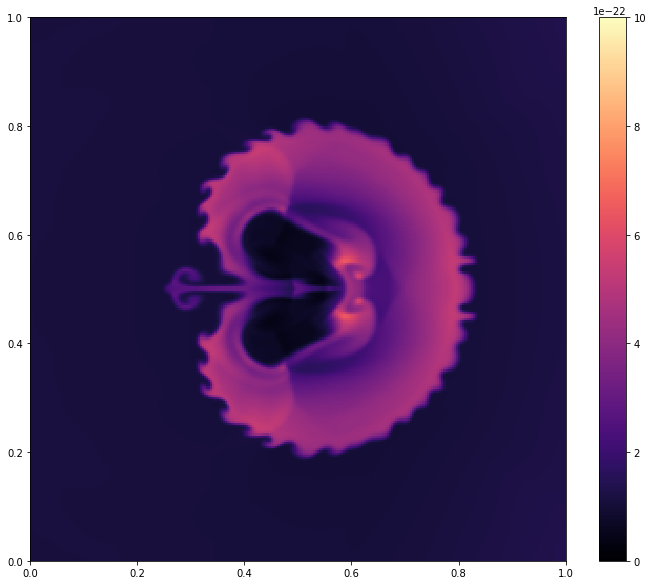

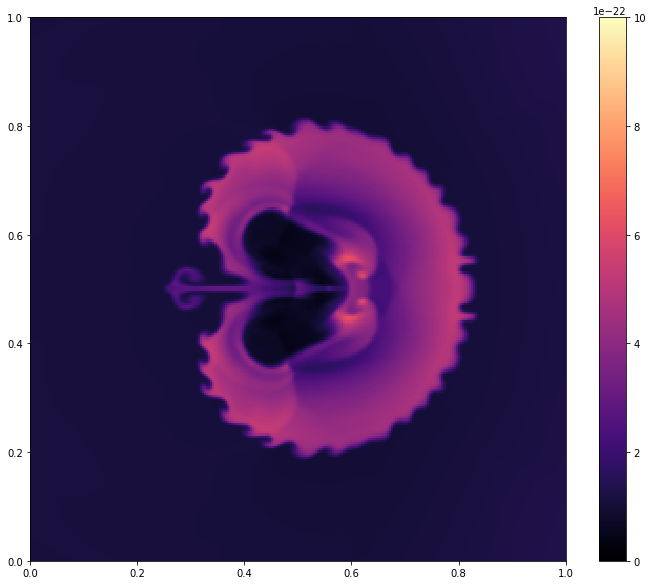

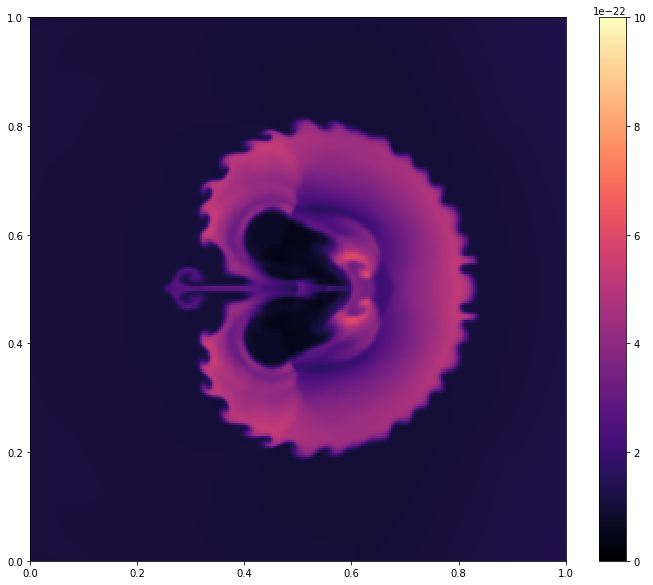

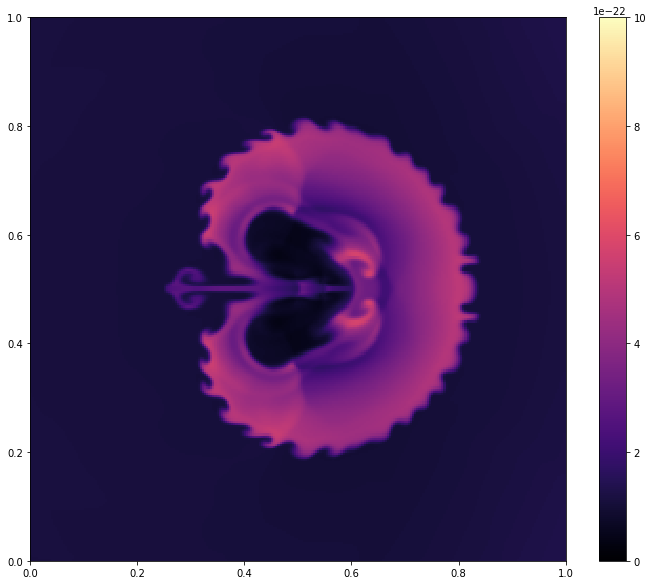

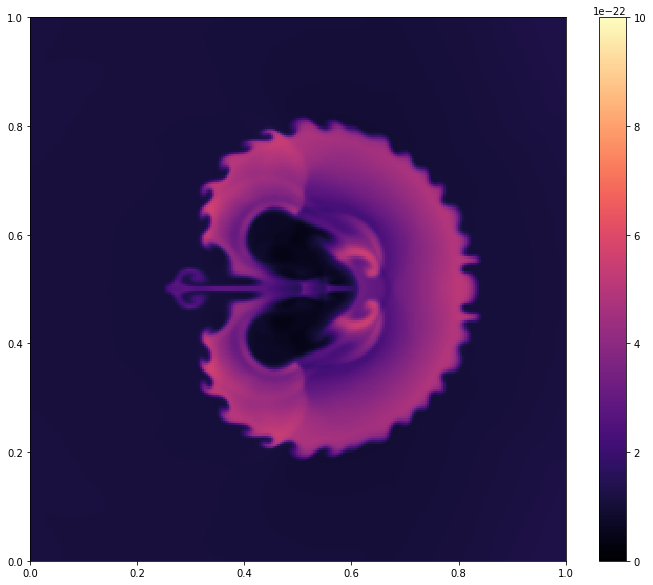

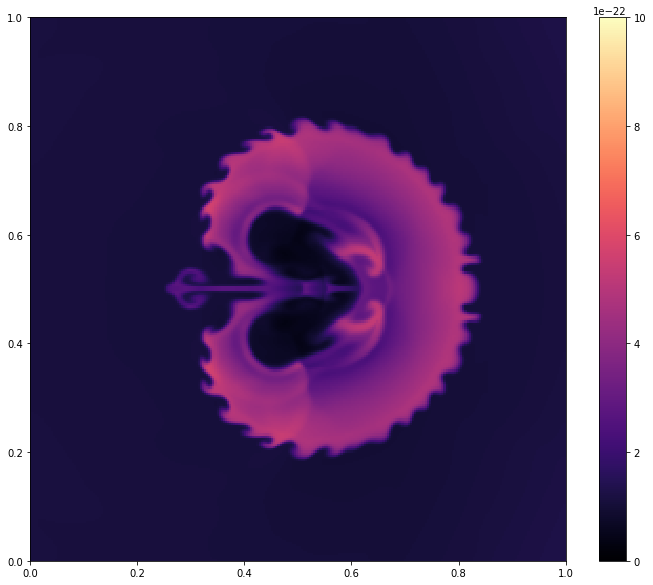

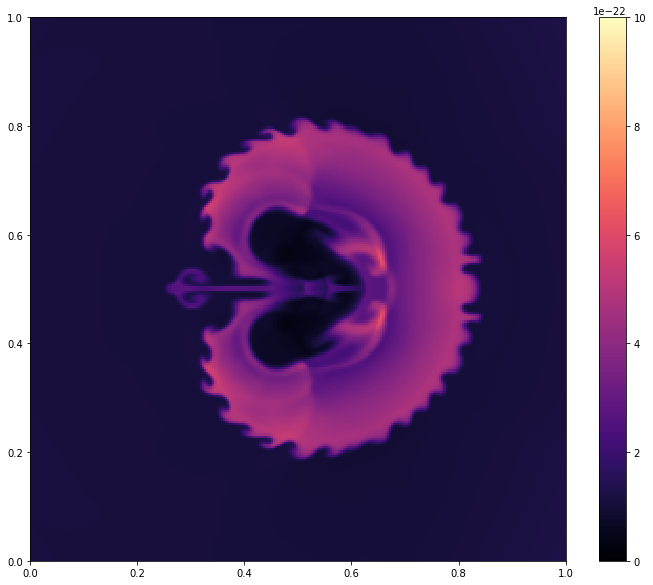

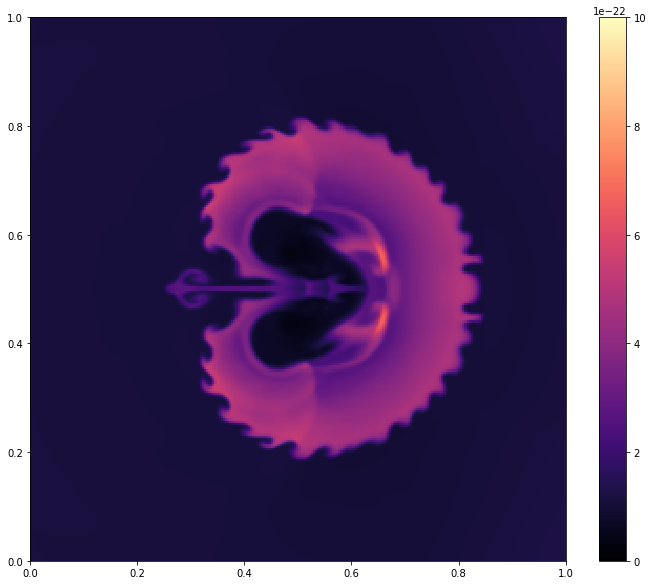

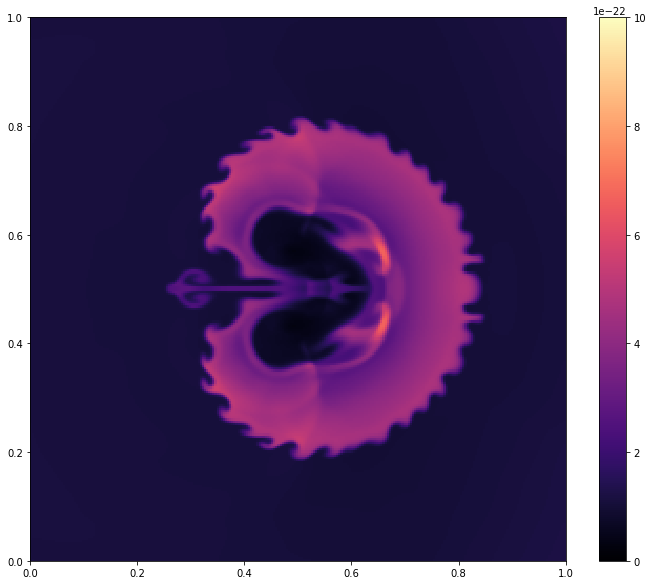

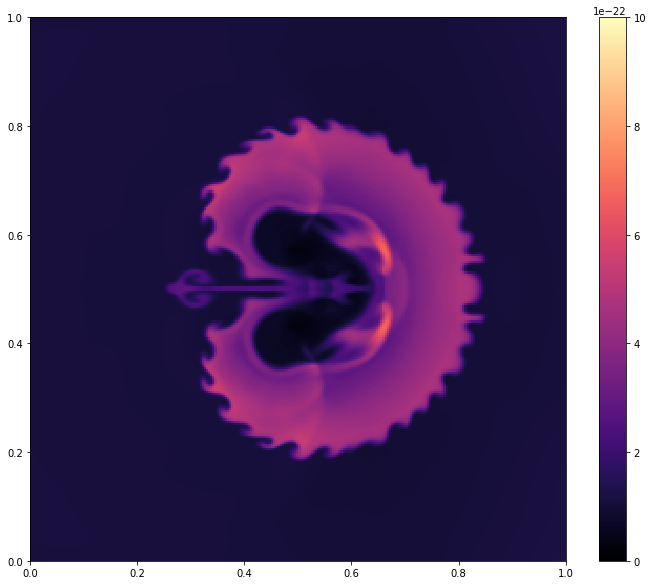

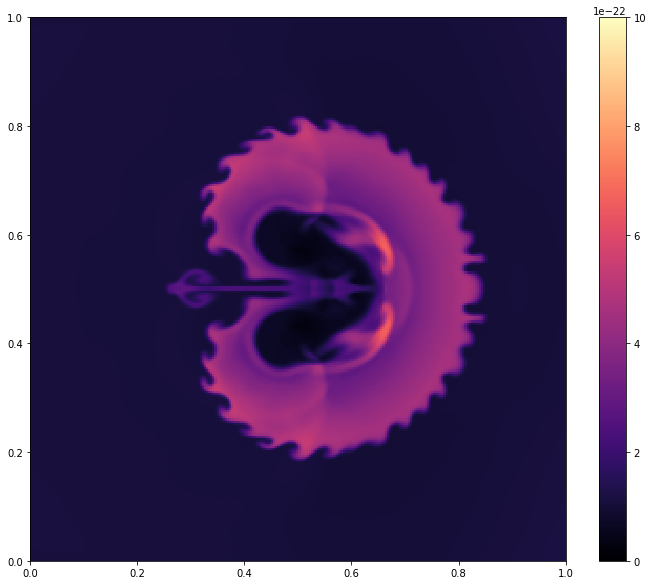

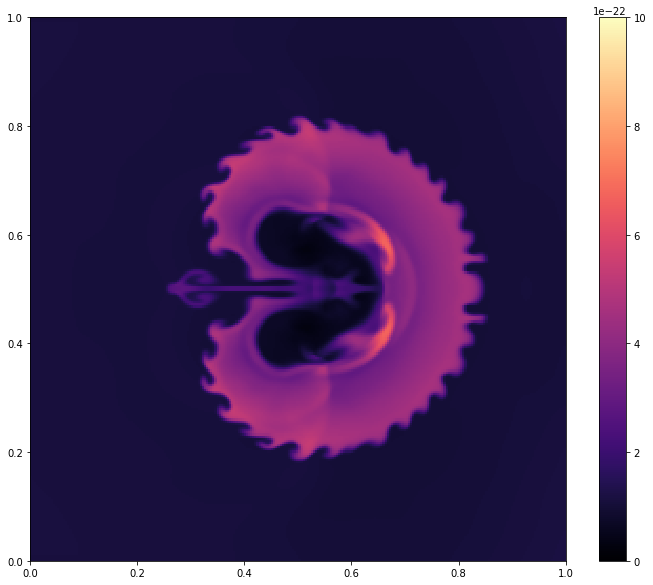

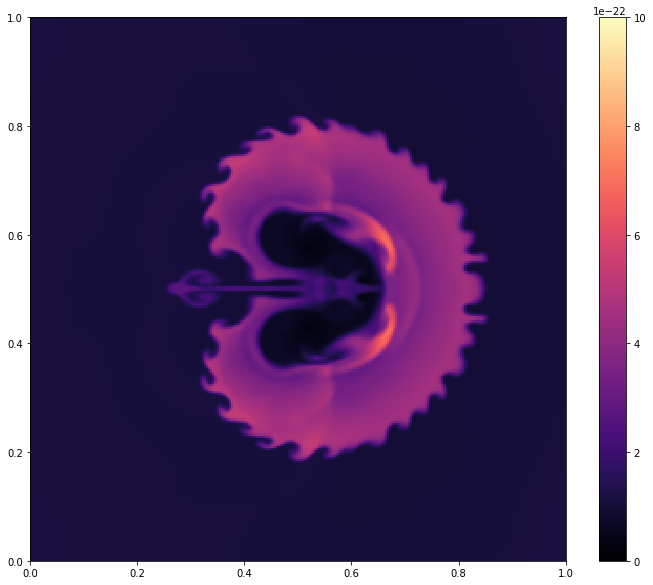

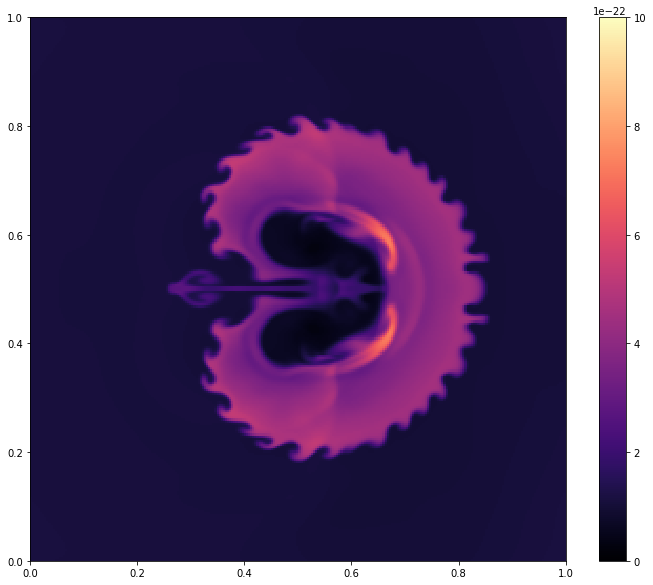

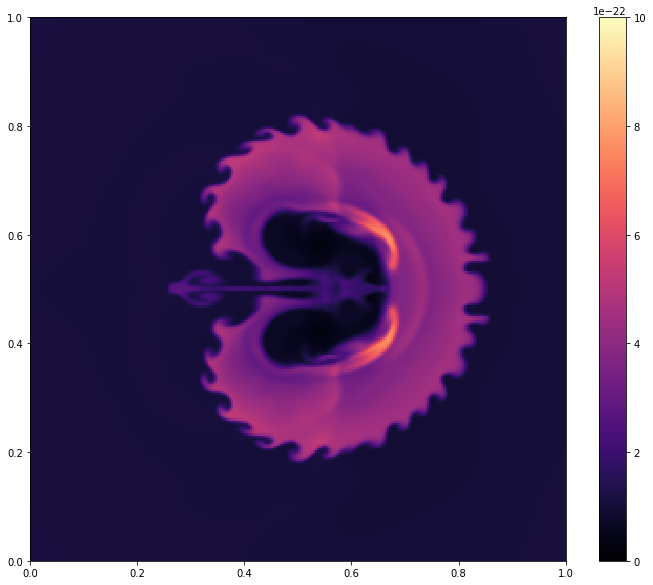

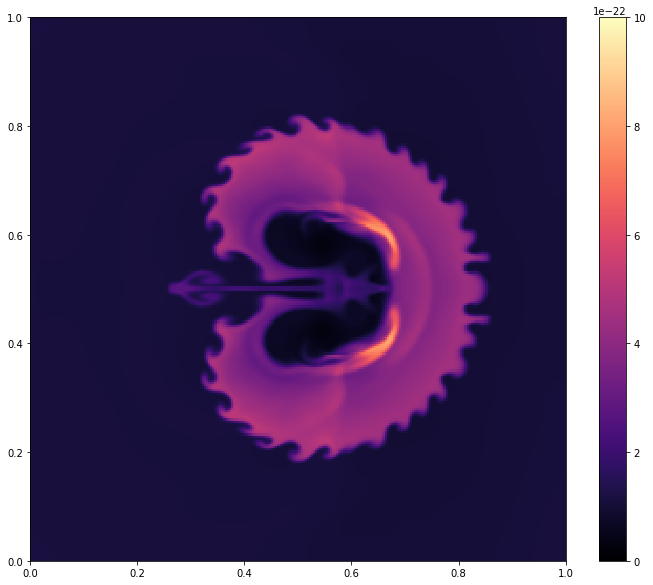

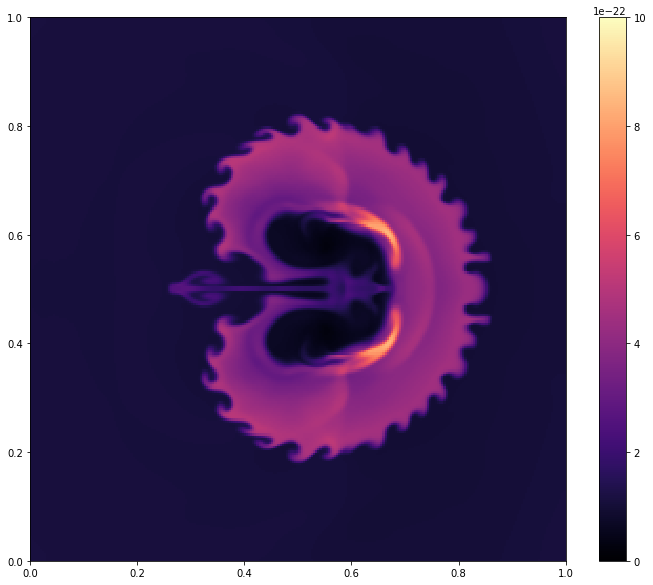

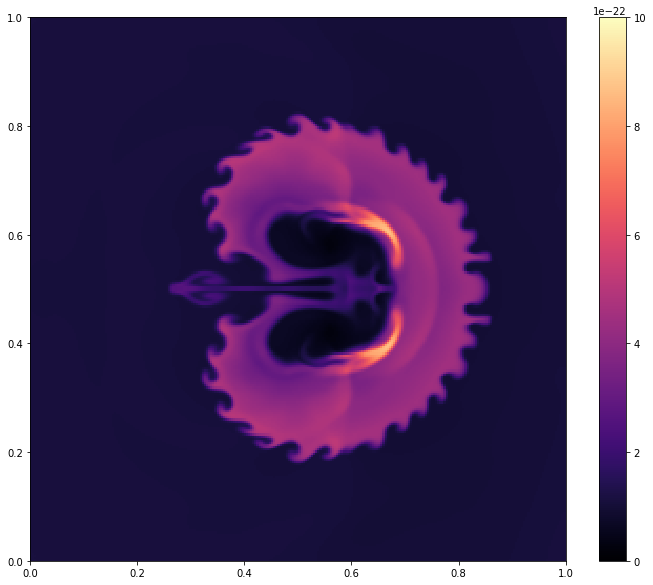

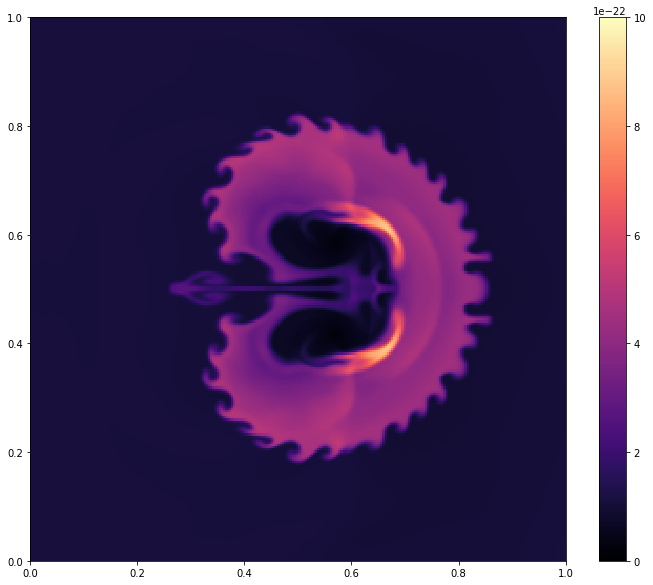

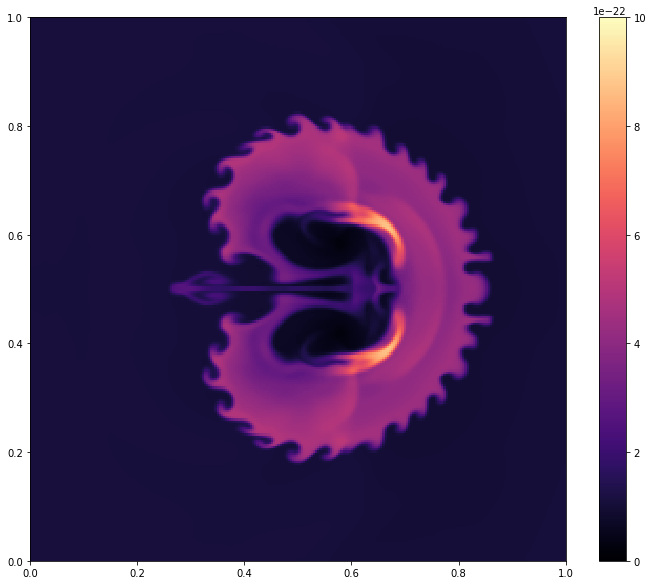

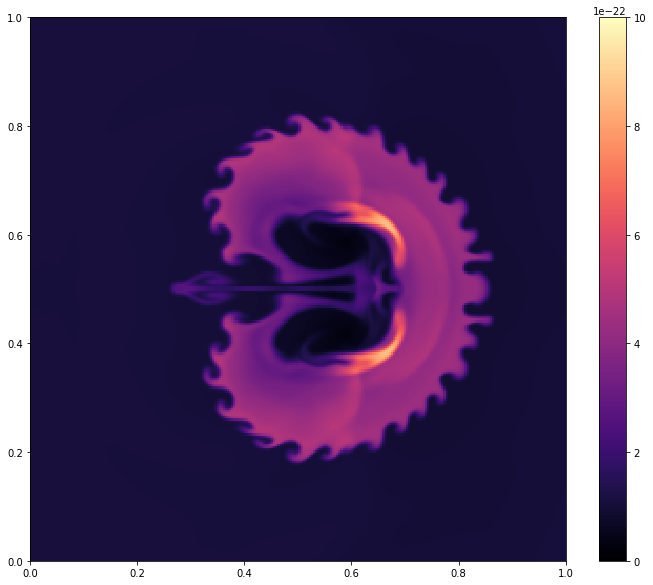

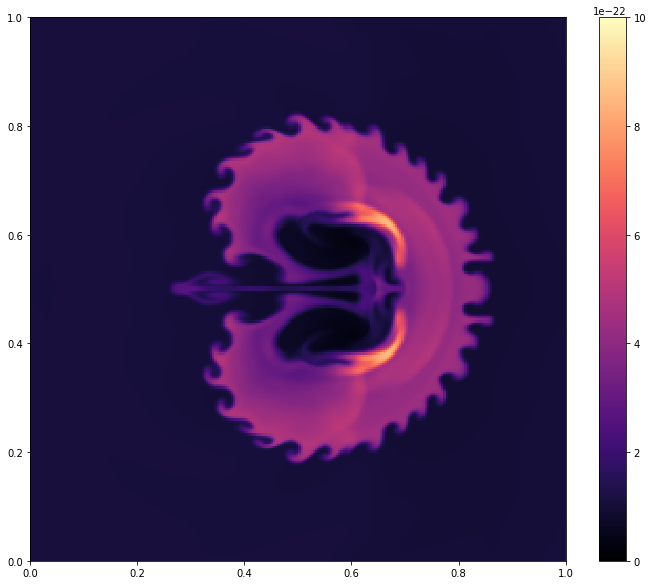

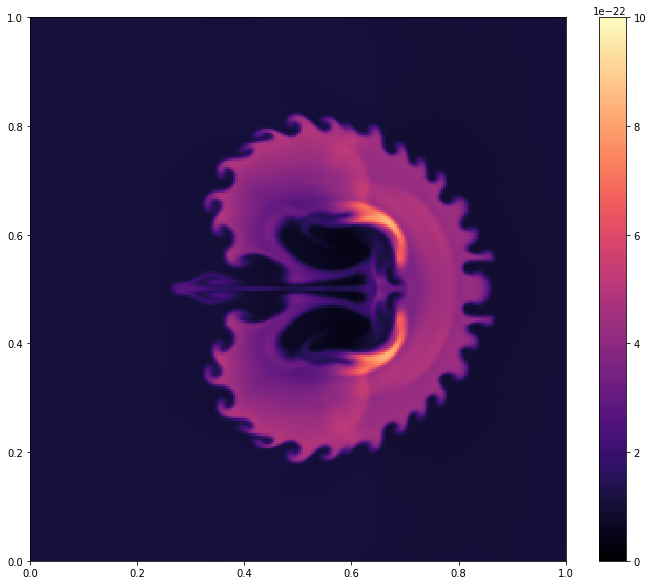

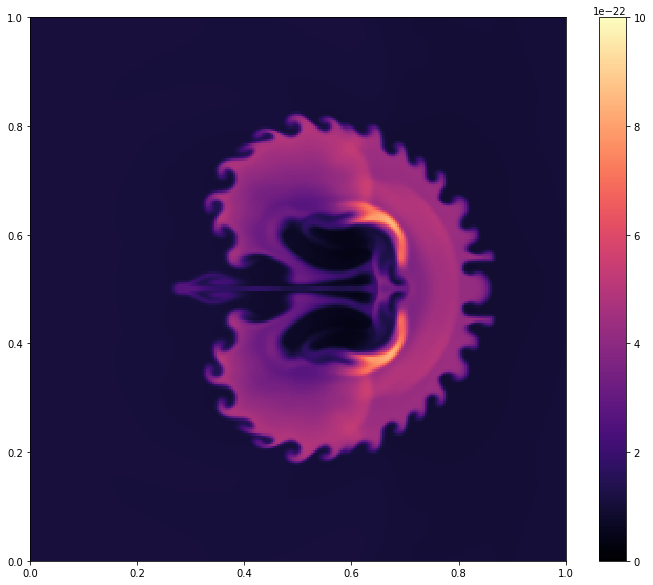

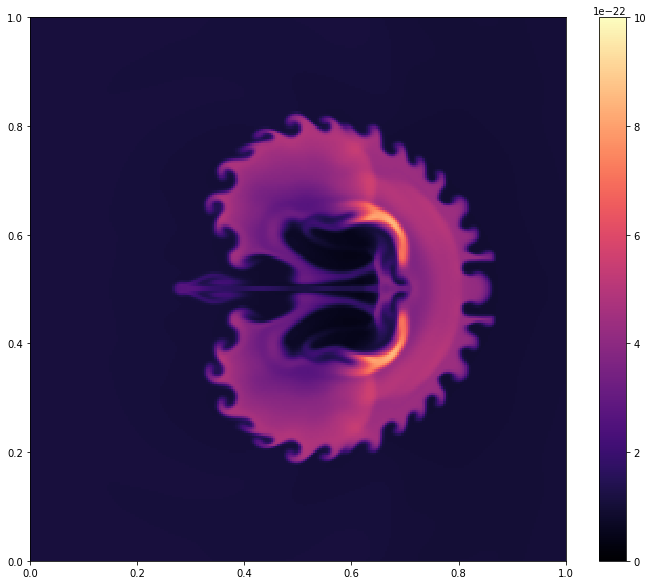

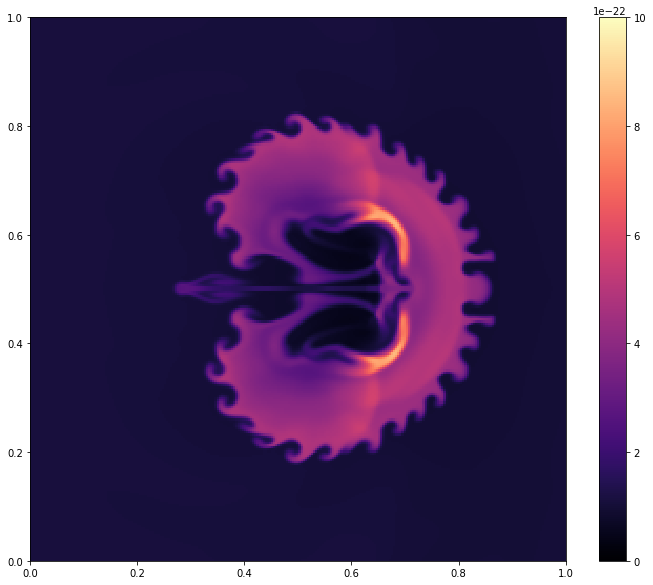

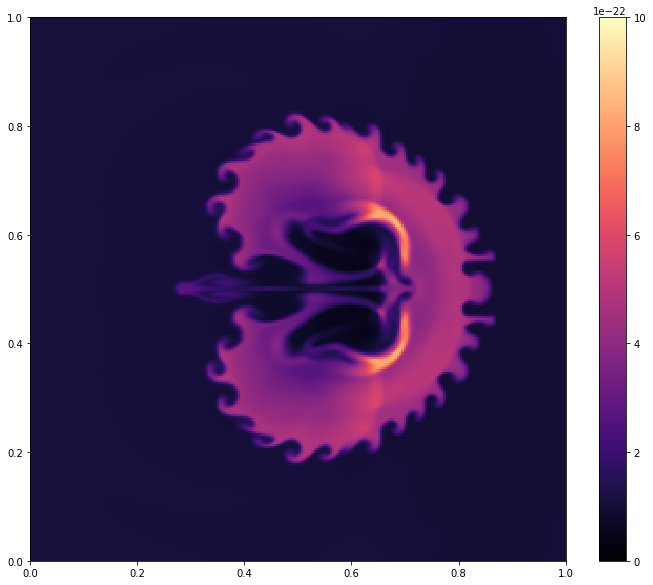

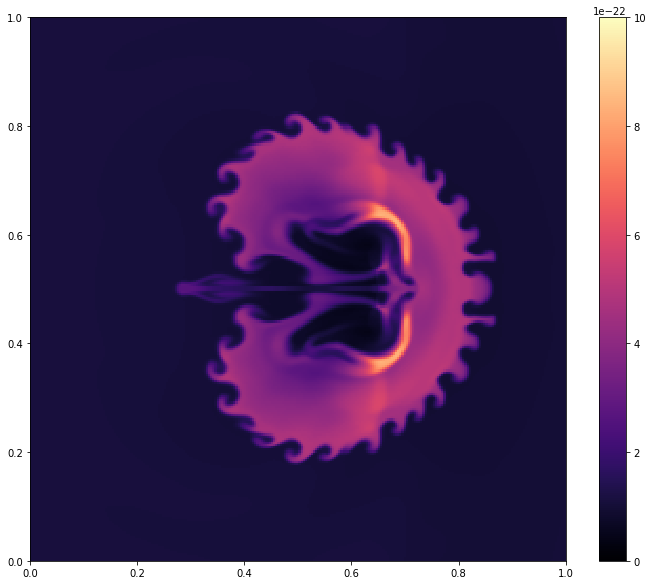

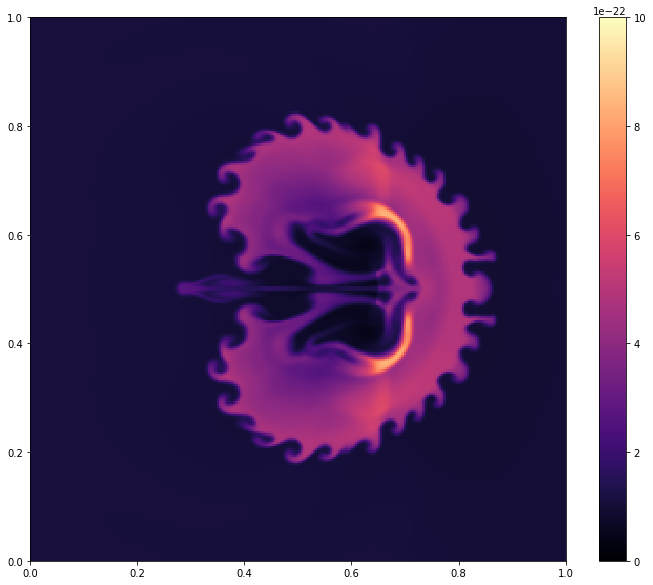

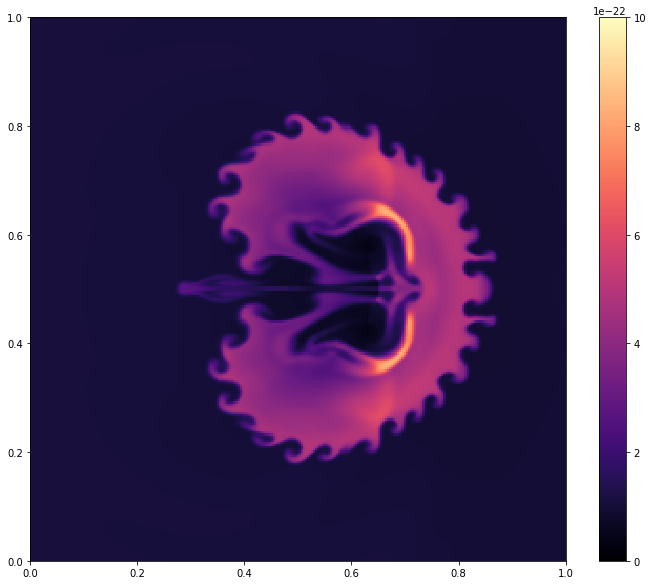

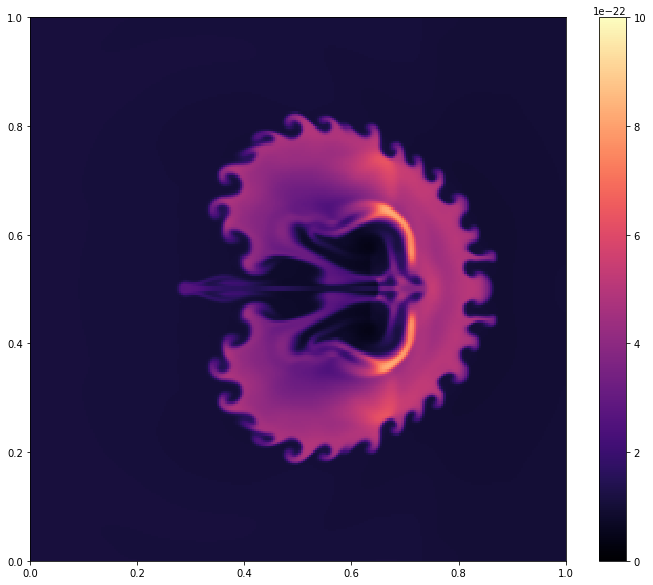

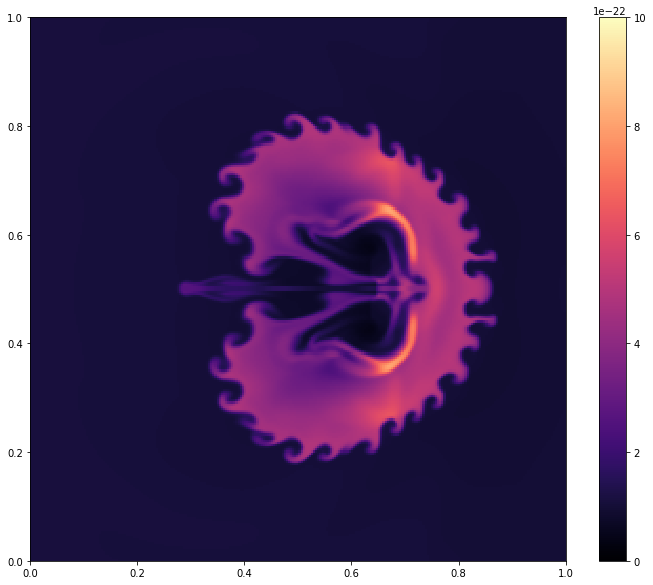

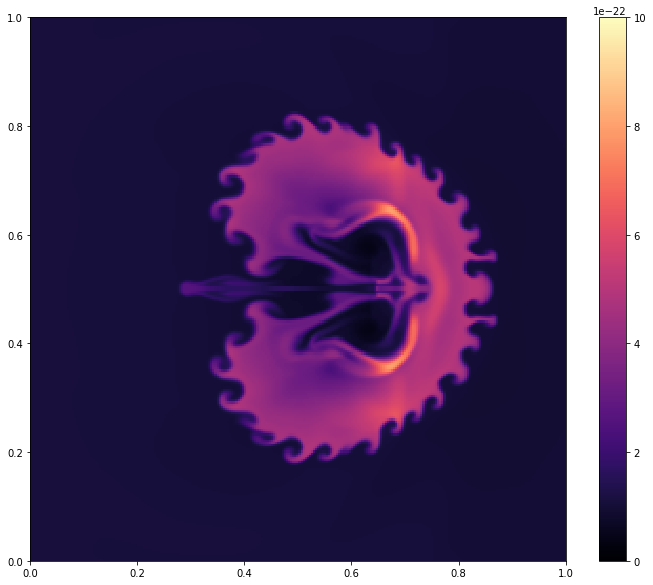

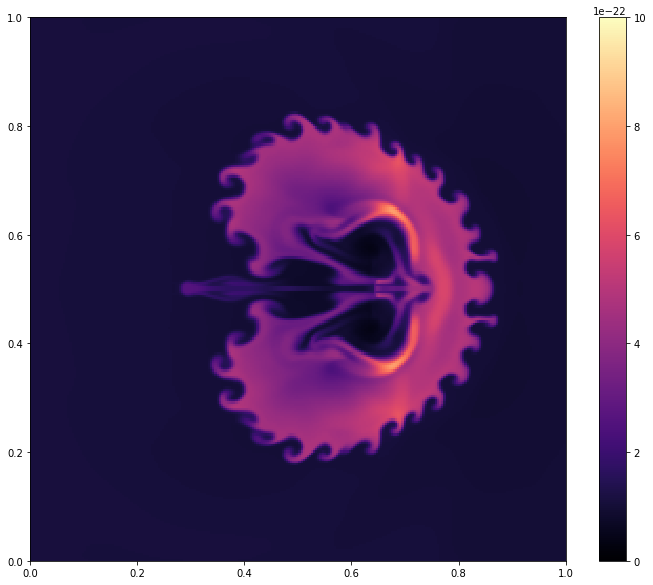

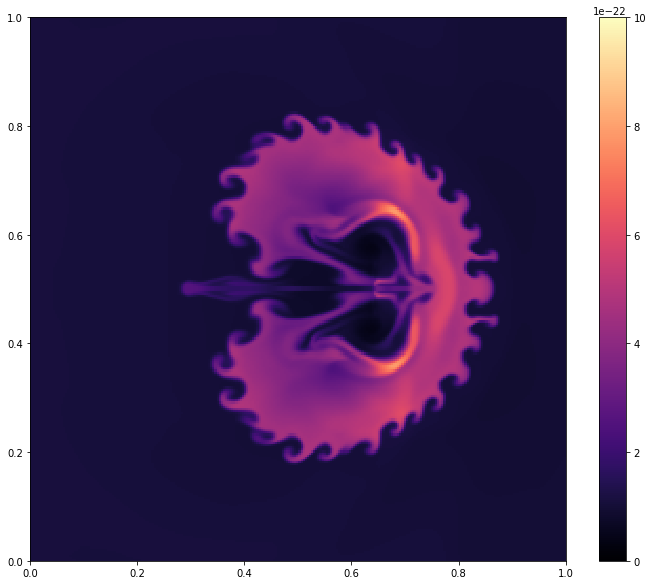

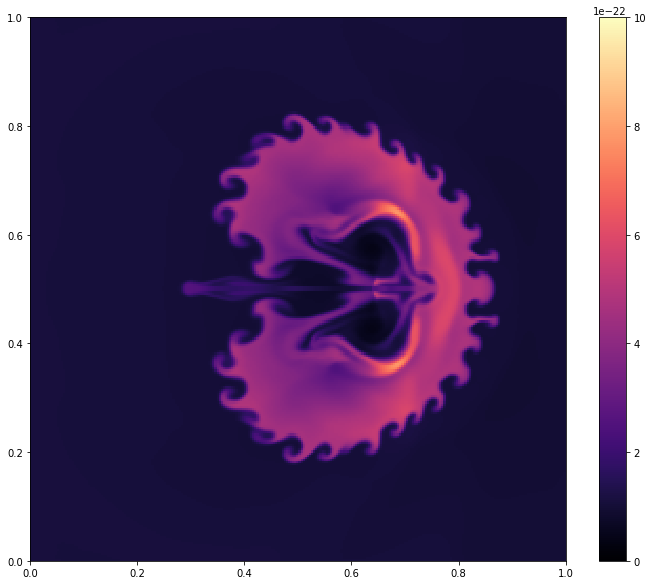

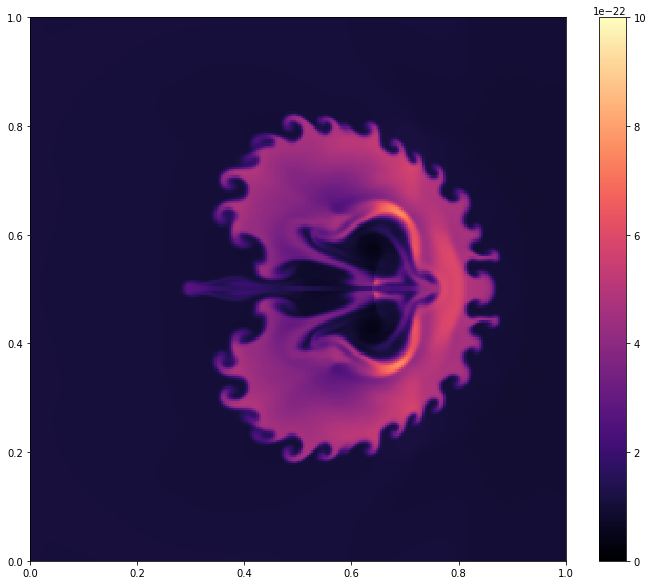

In [12]:
for i in range(0,101):
    
    filename = "data.0{:03d}.vtk".format(i) 

    times, rho, nrh, prs, tr1, tr2, vx1, vx2, tem, meshbounds, meshdimensions = pload_vtk(filename)

    make_2D_plot(meshbounds, meshdimensions, rho)



# Post-processed data:

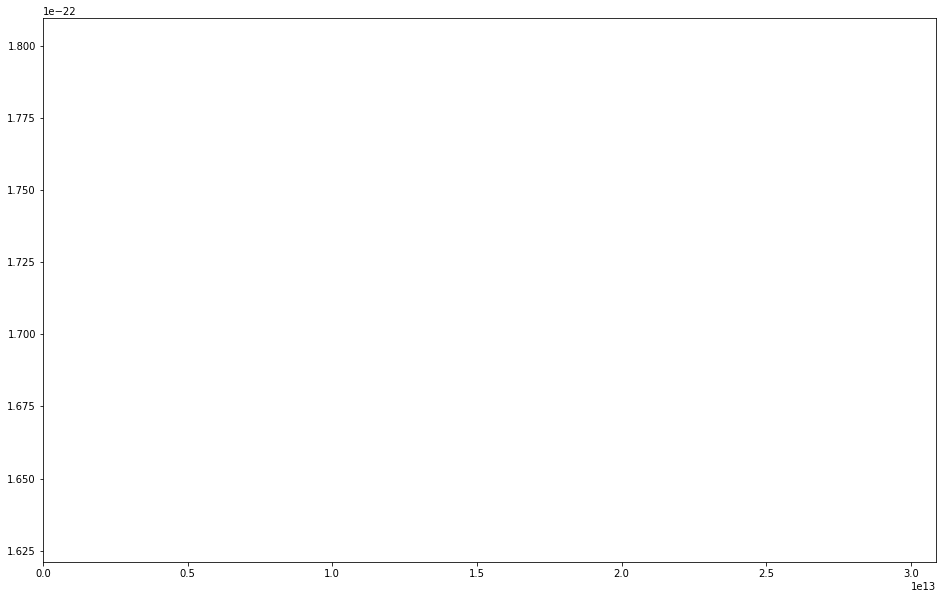

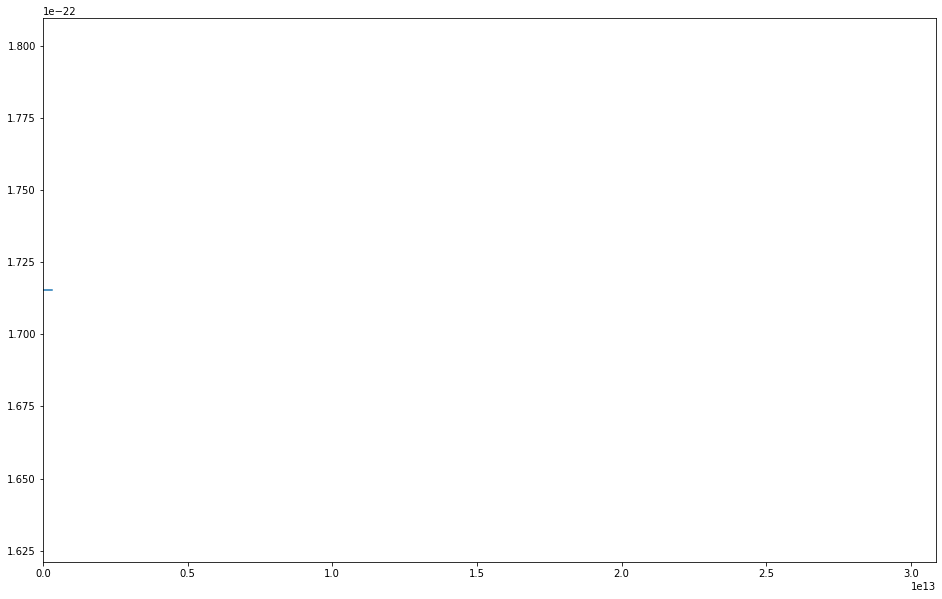

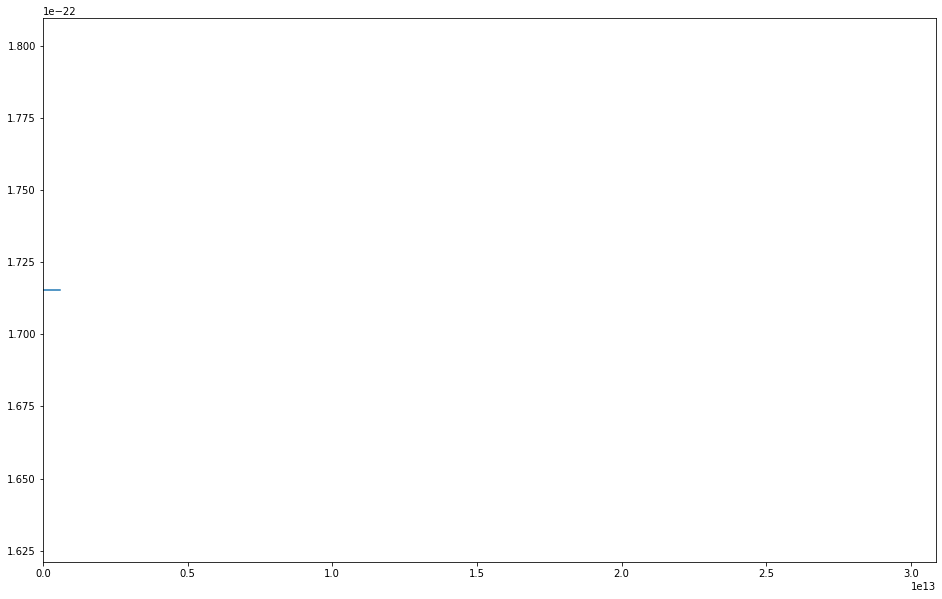

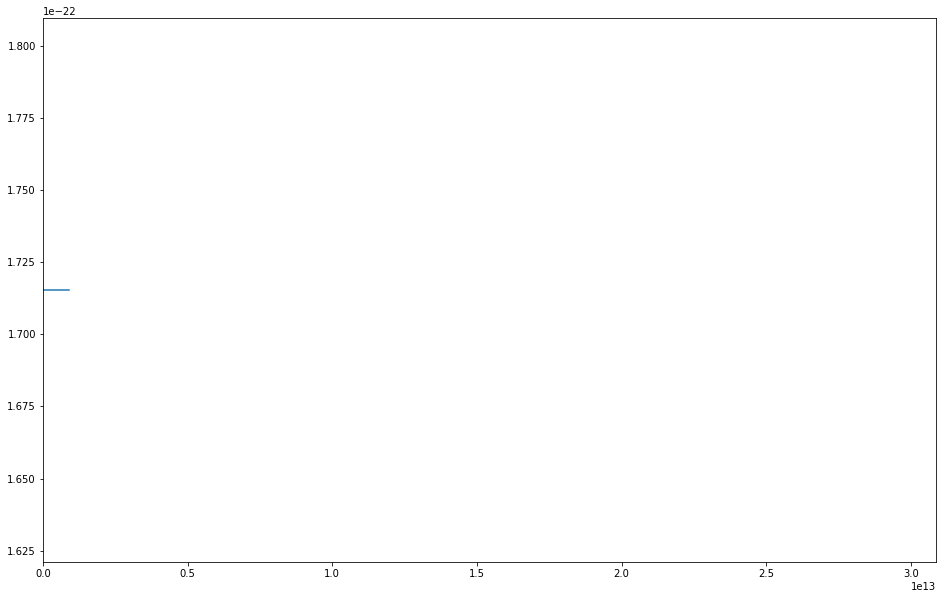

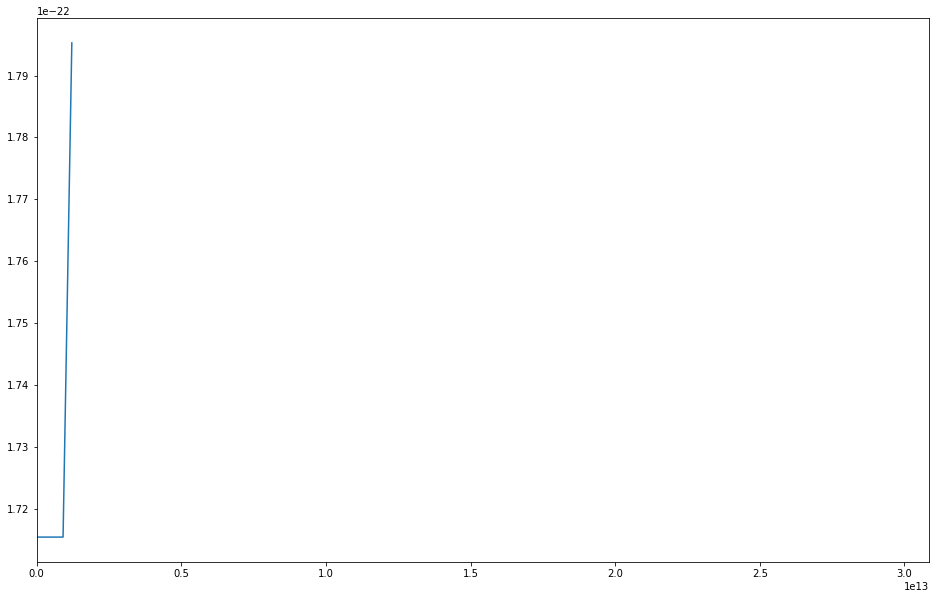

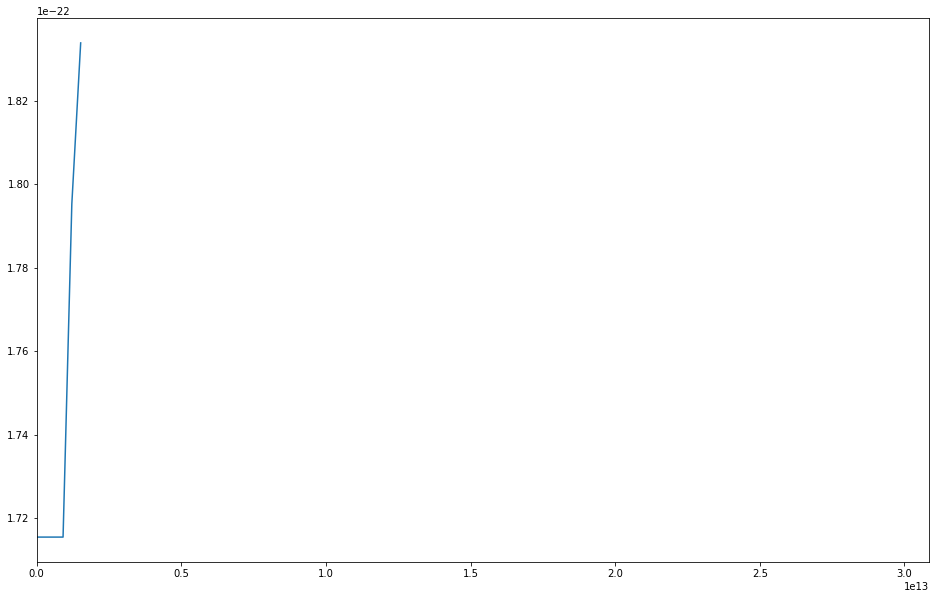

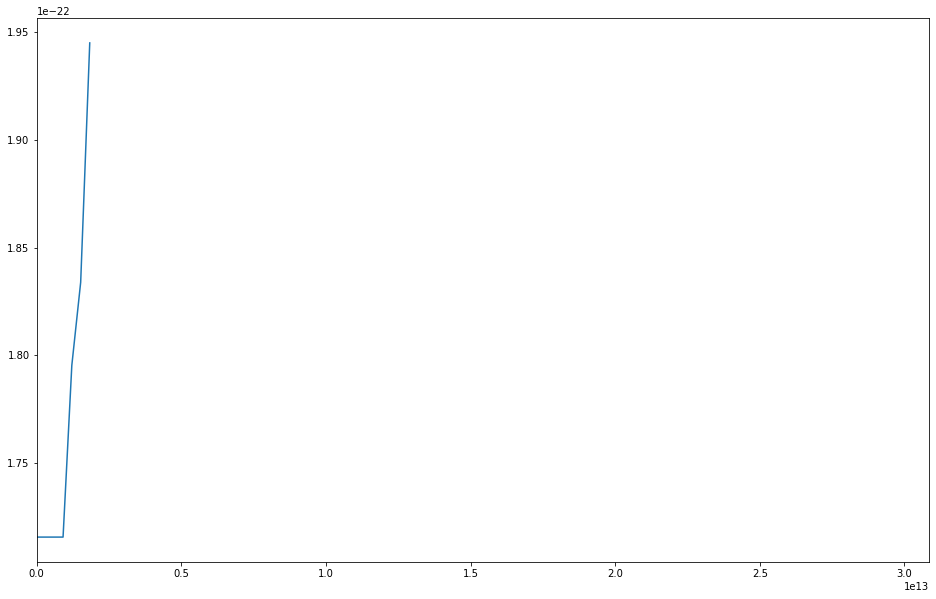

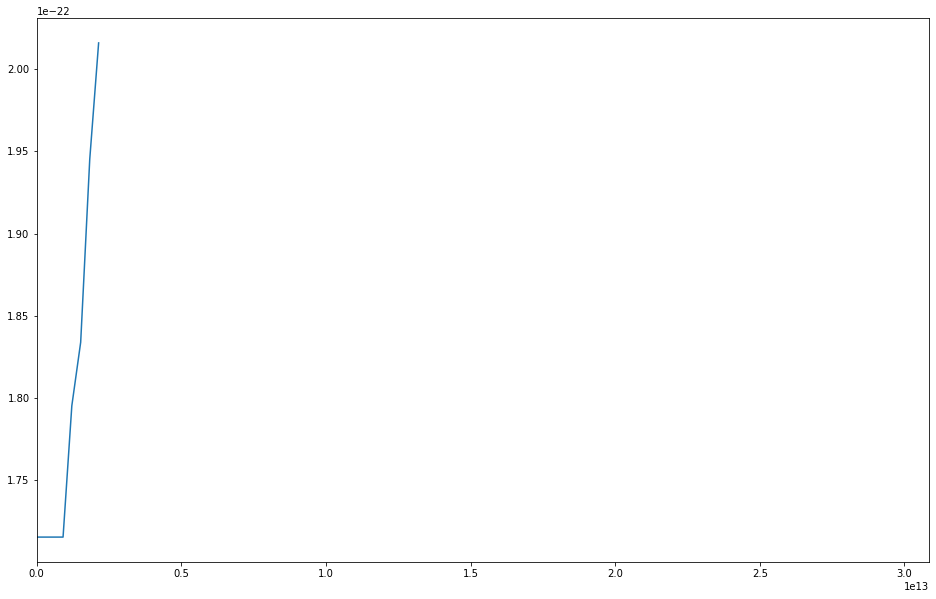

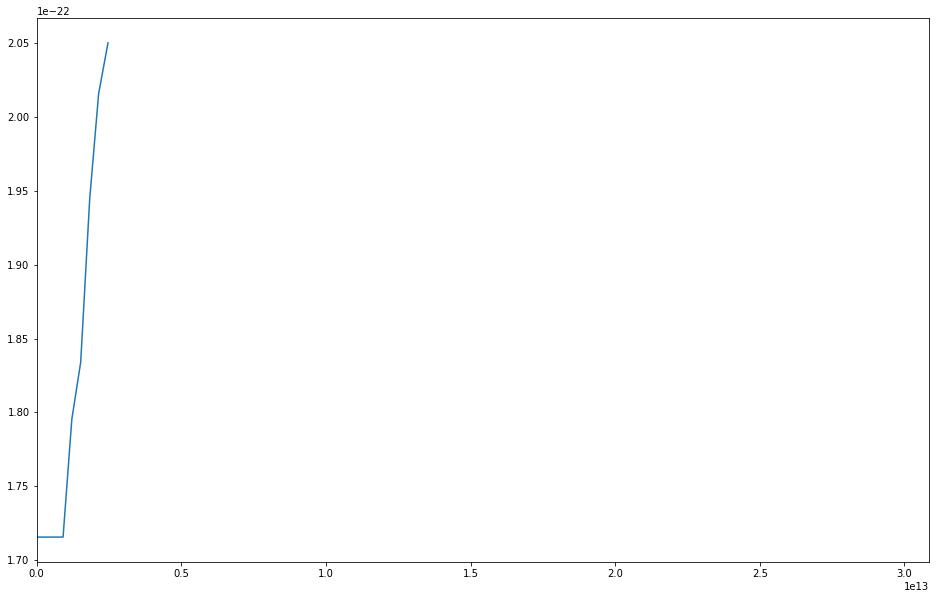

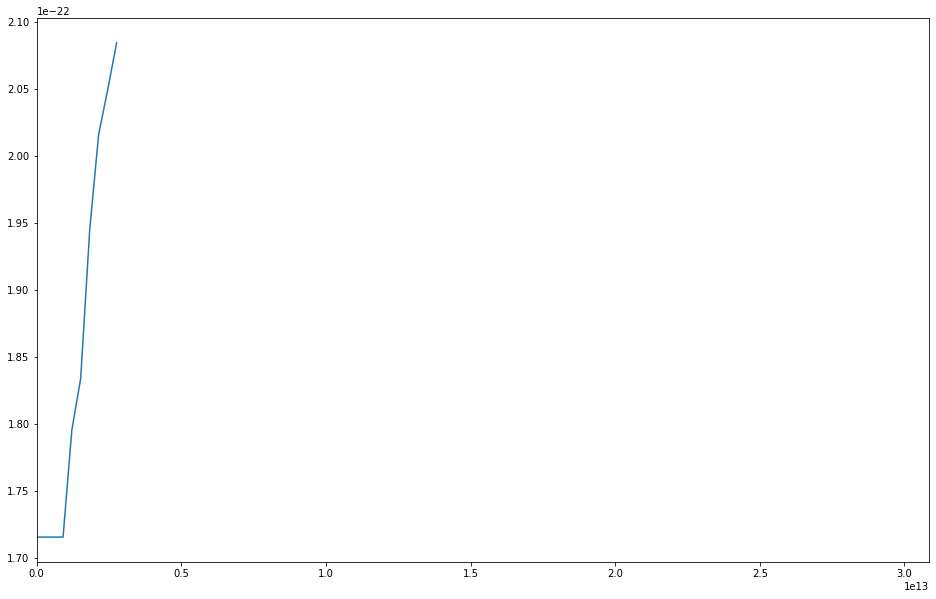

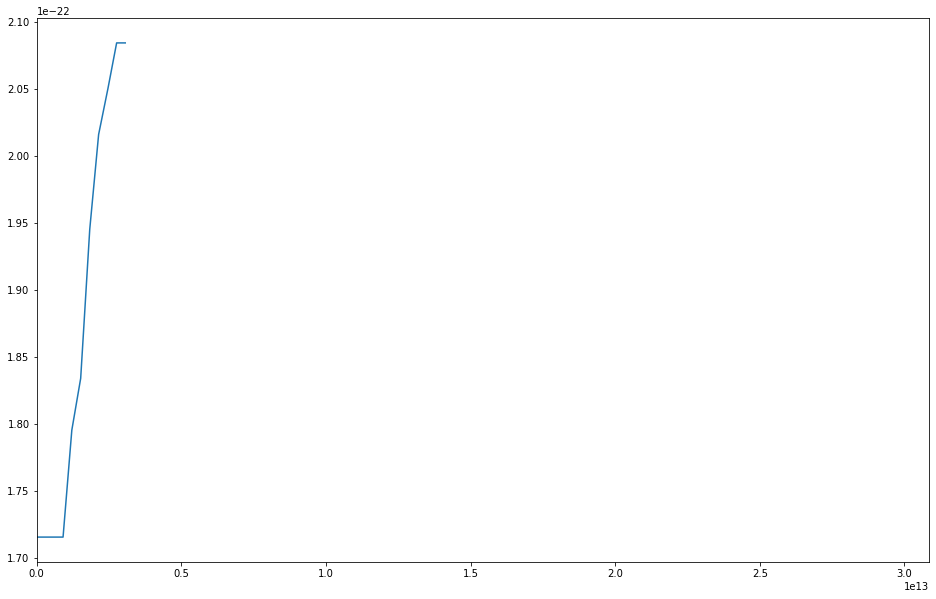

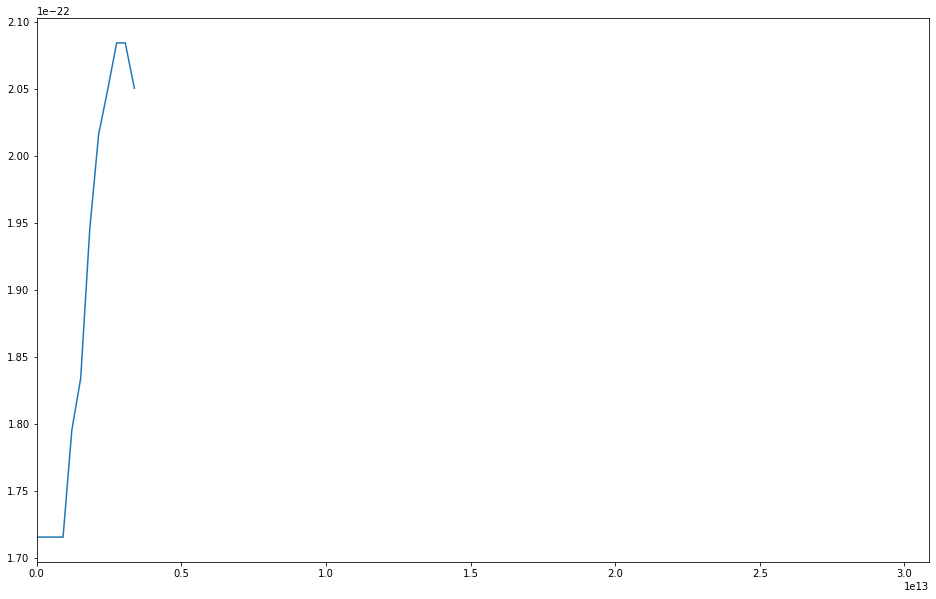

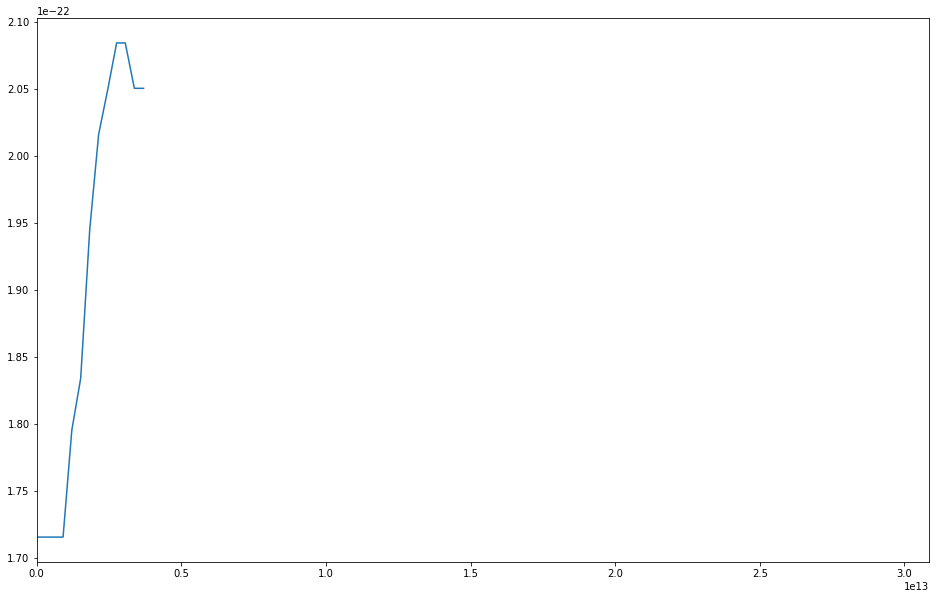

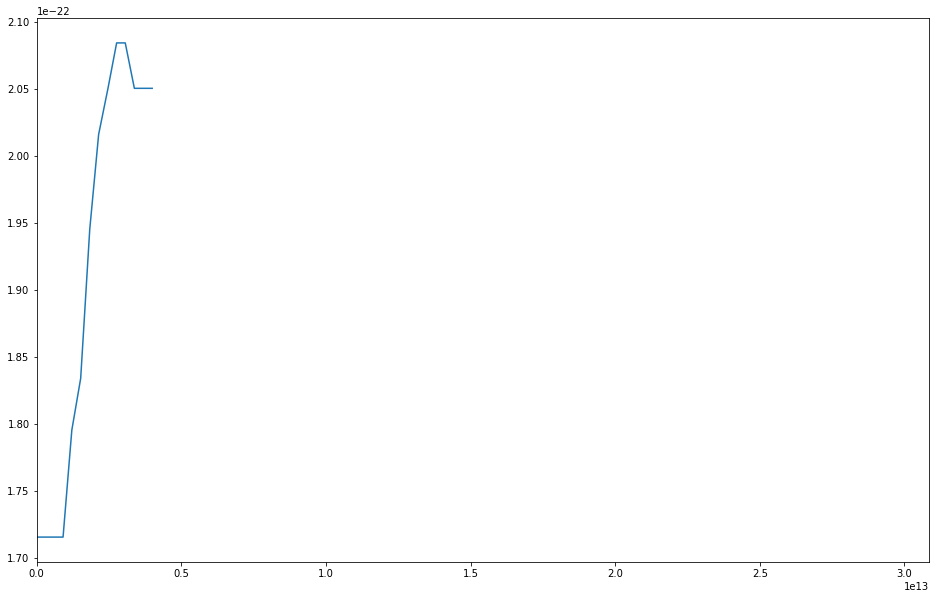

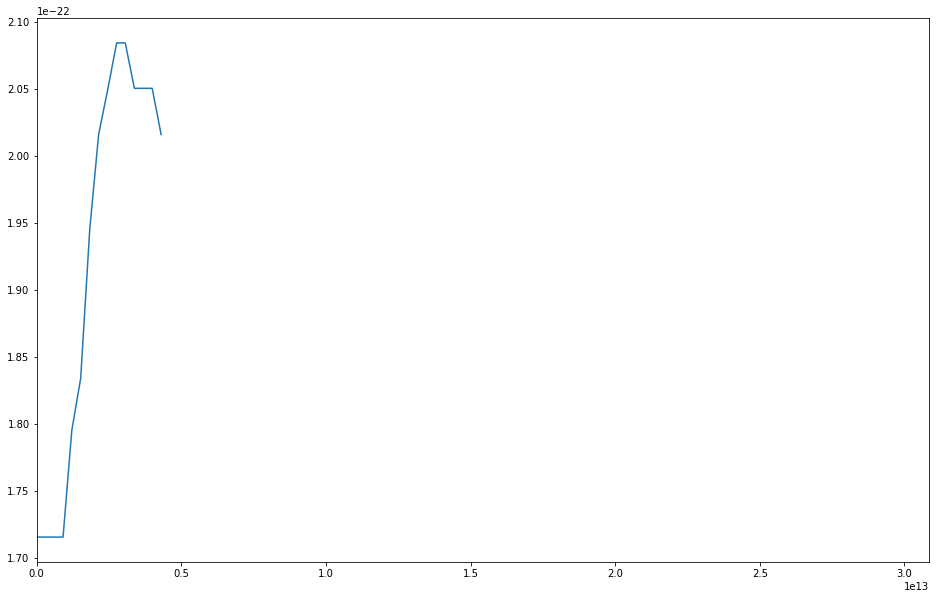

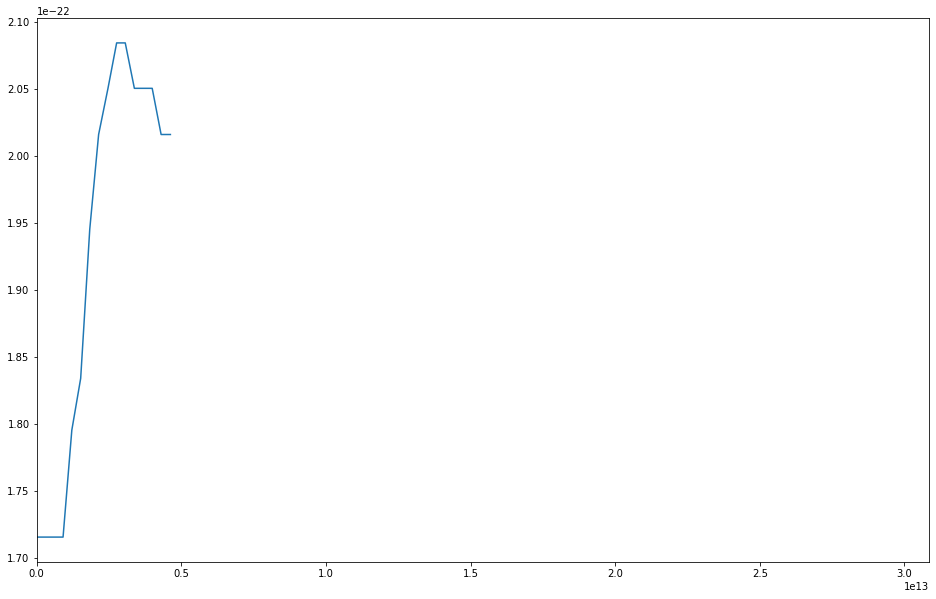

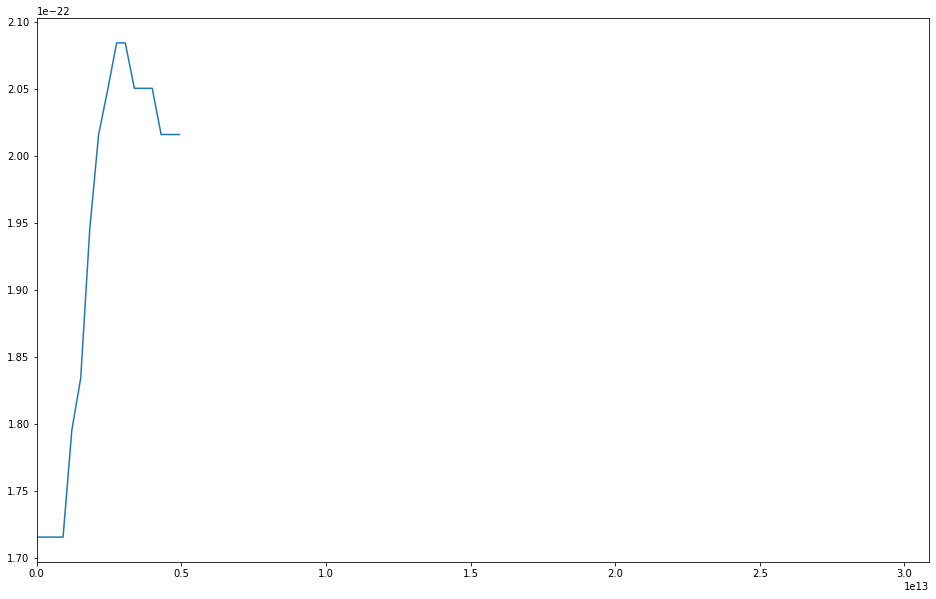

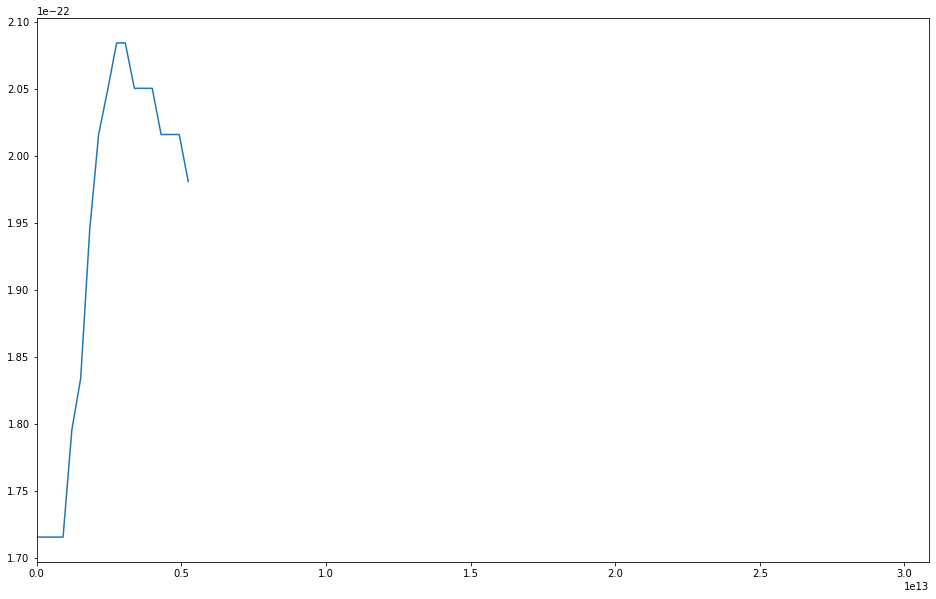

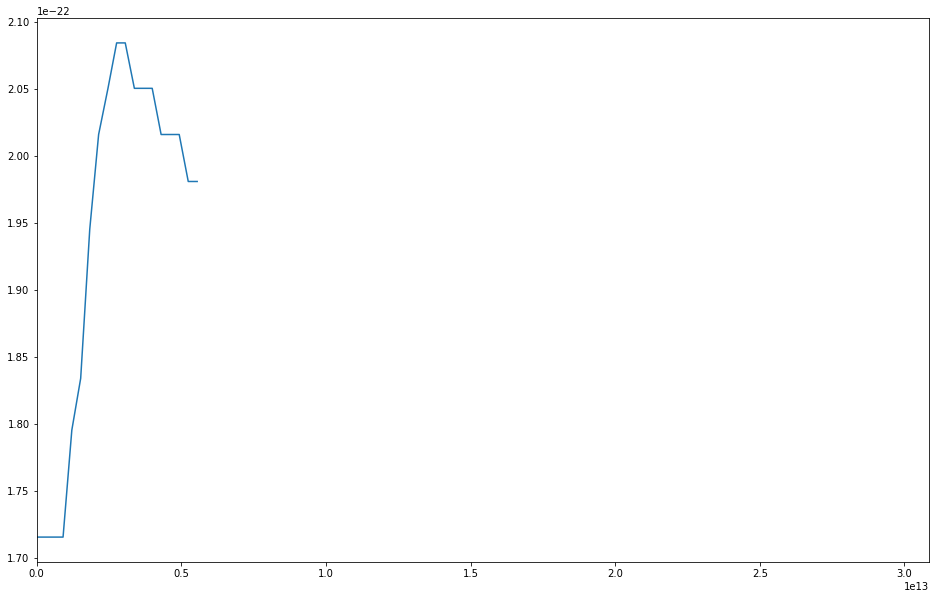

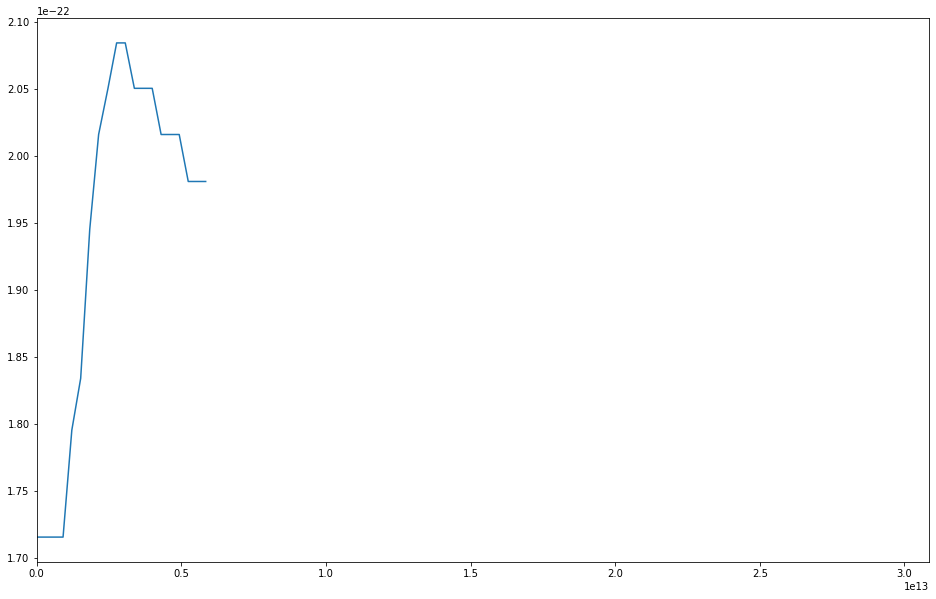

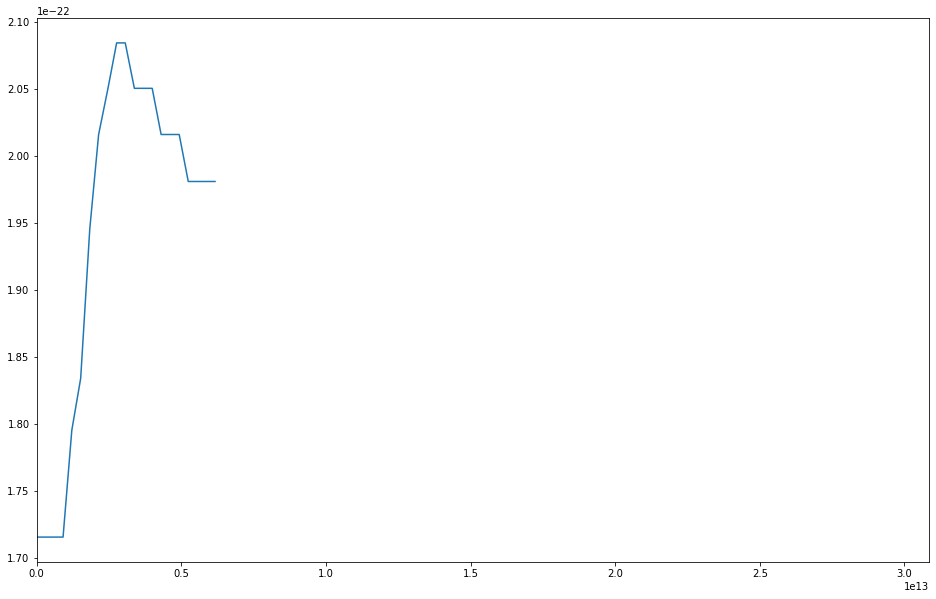

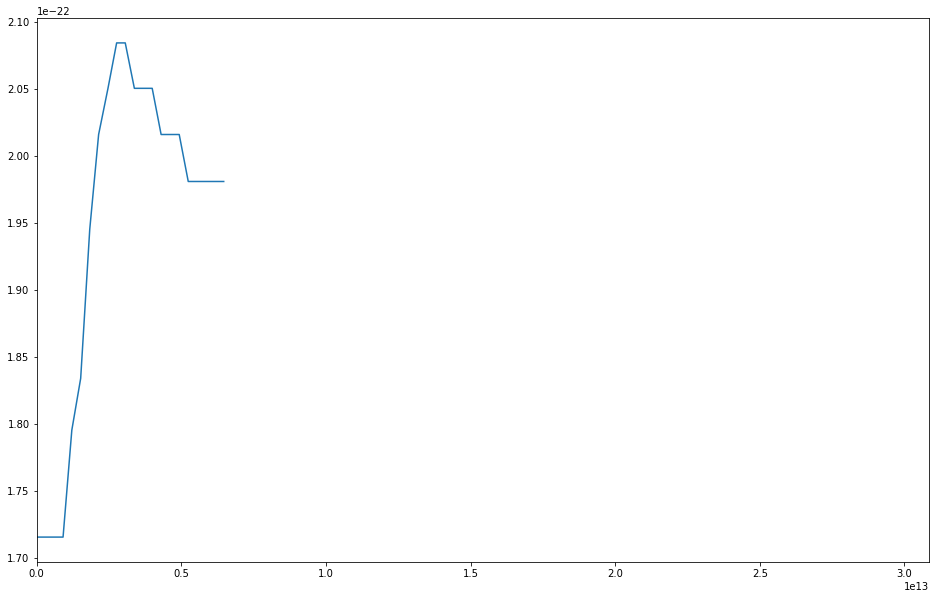

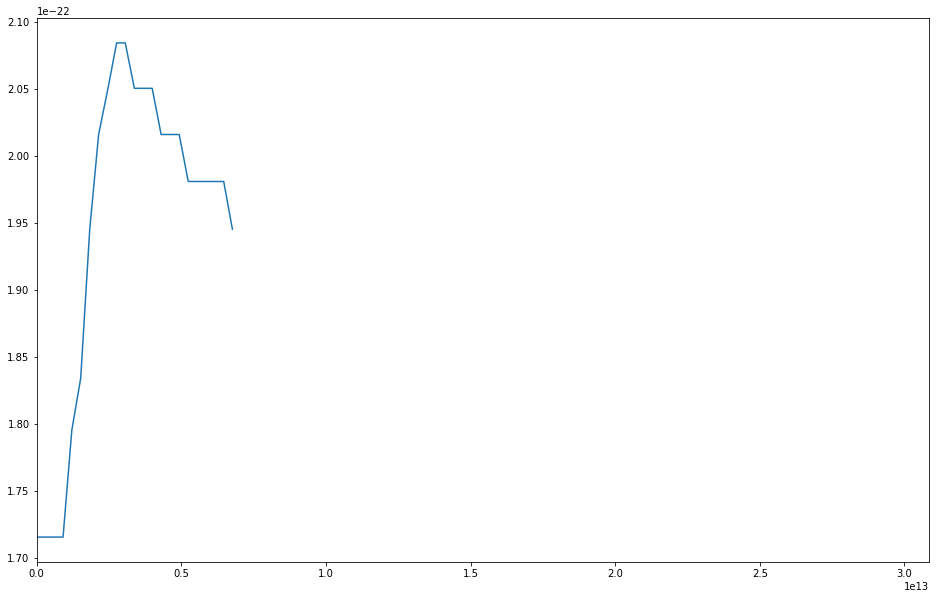

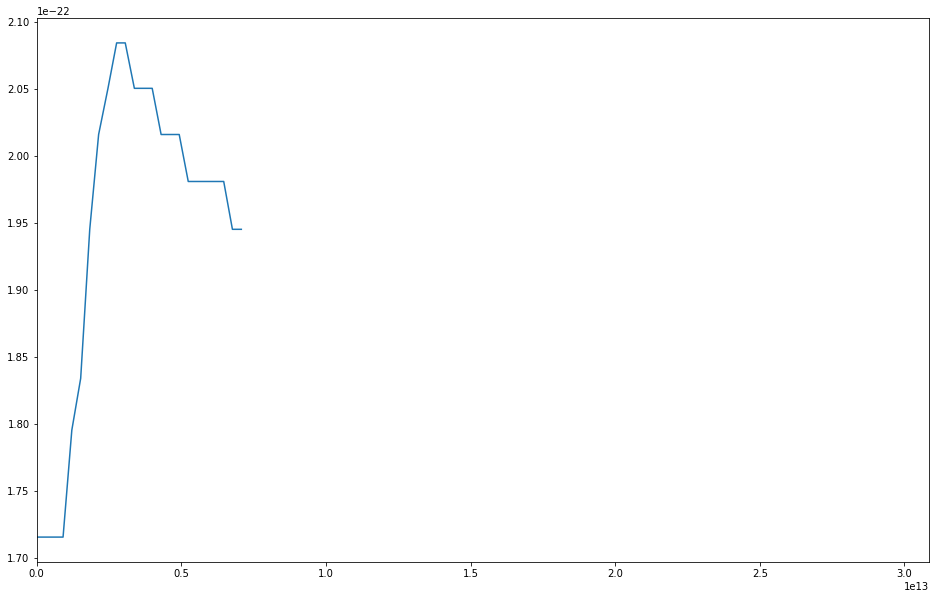

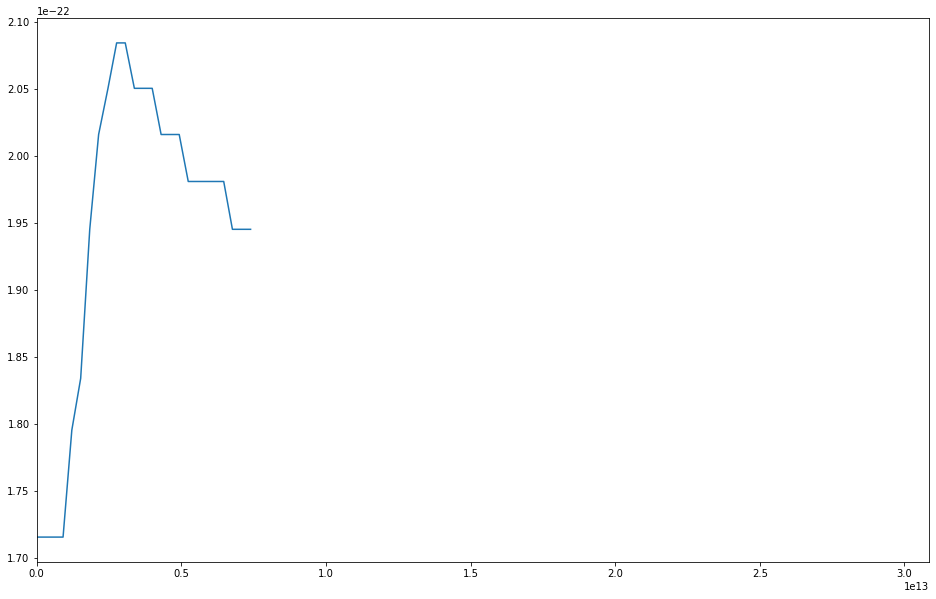

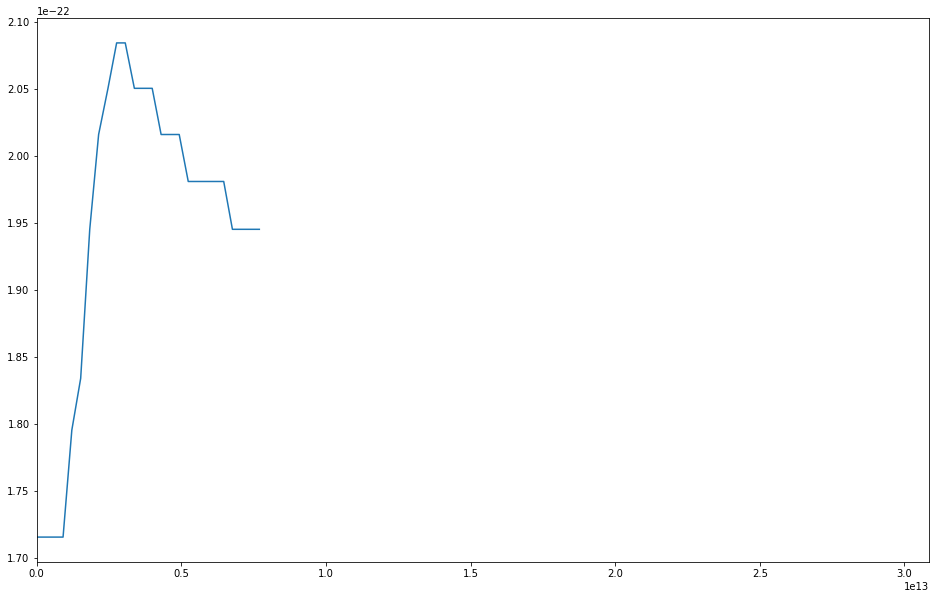

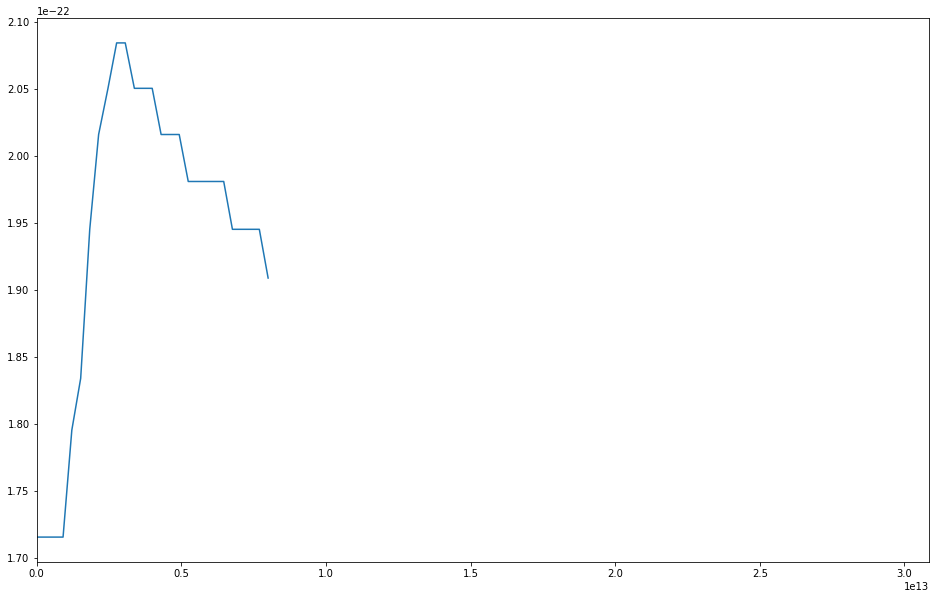

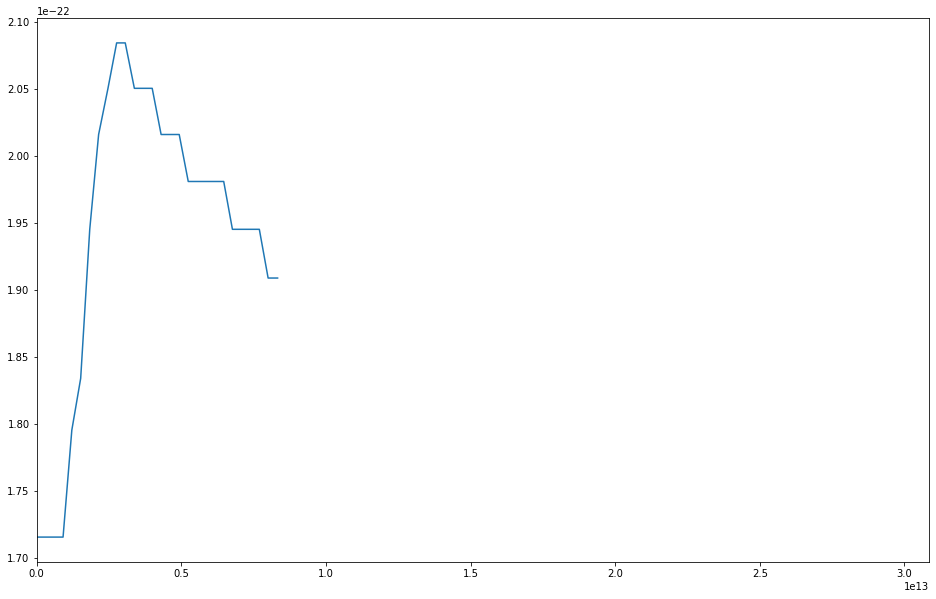

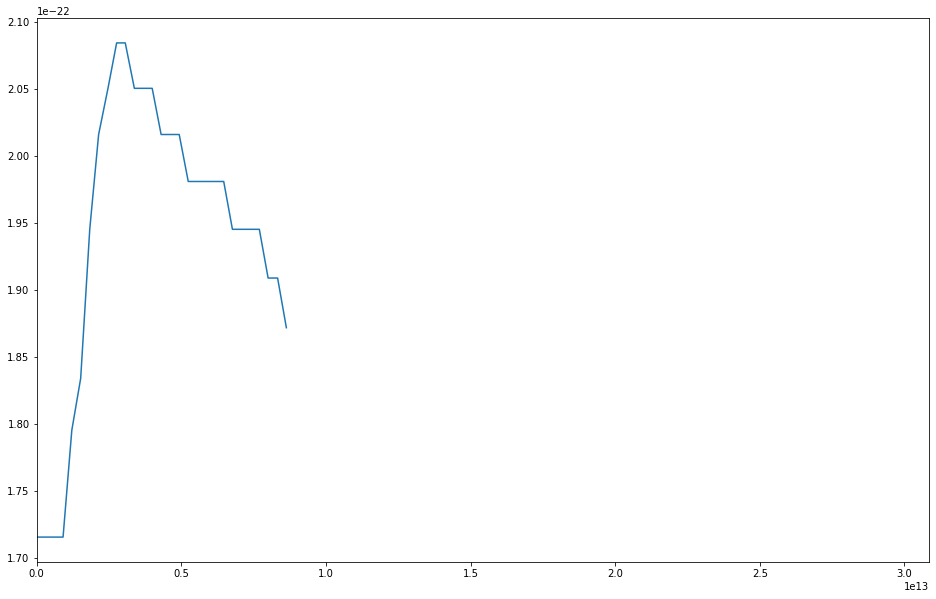

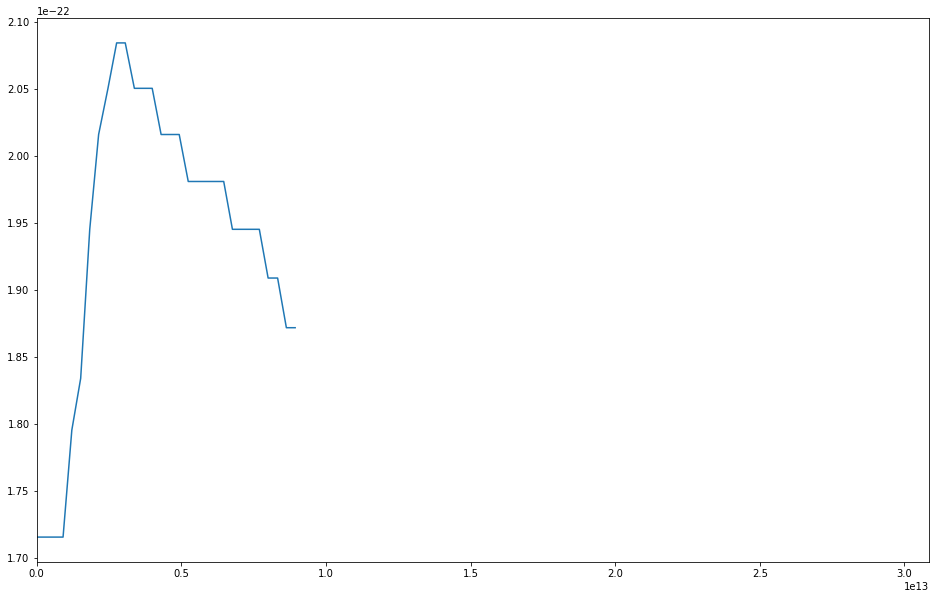

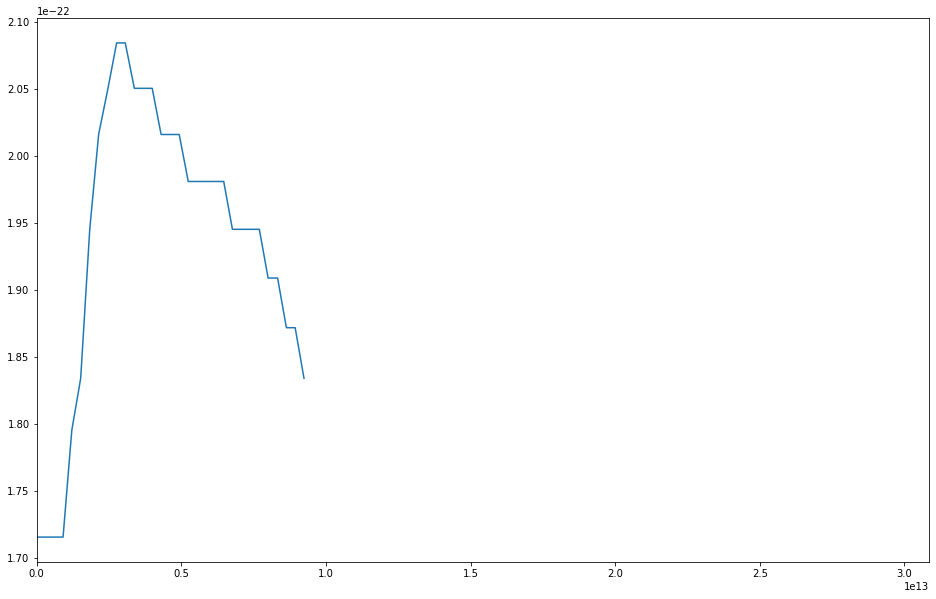

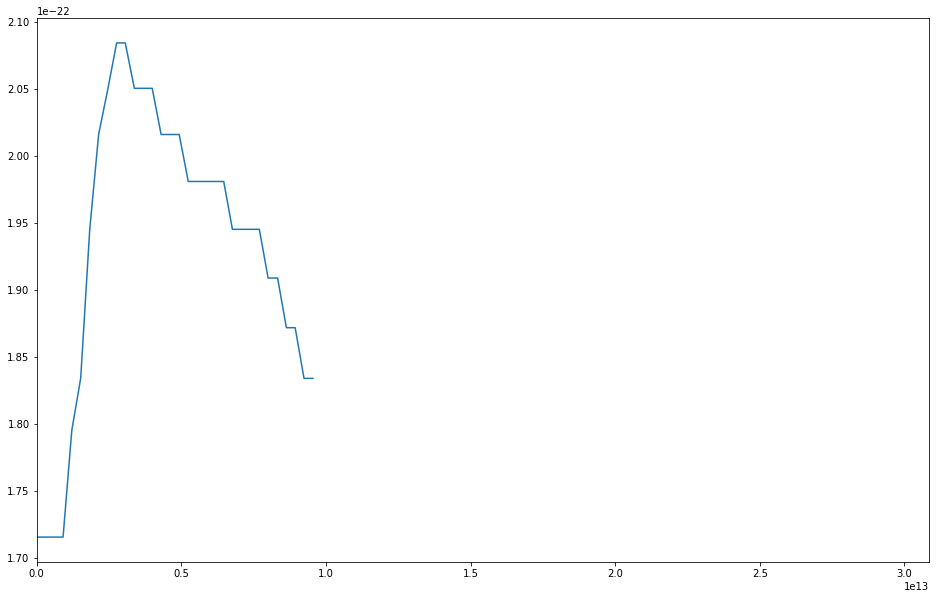

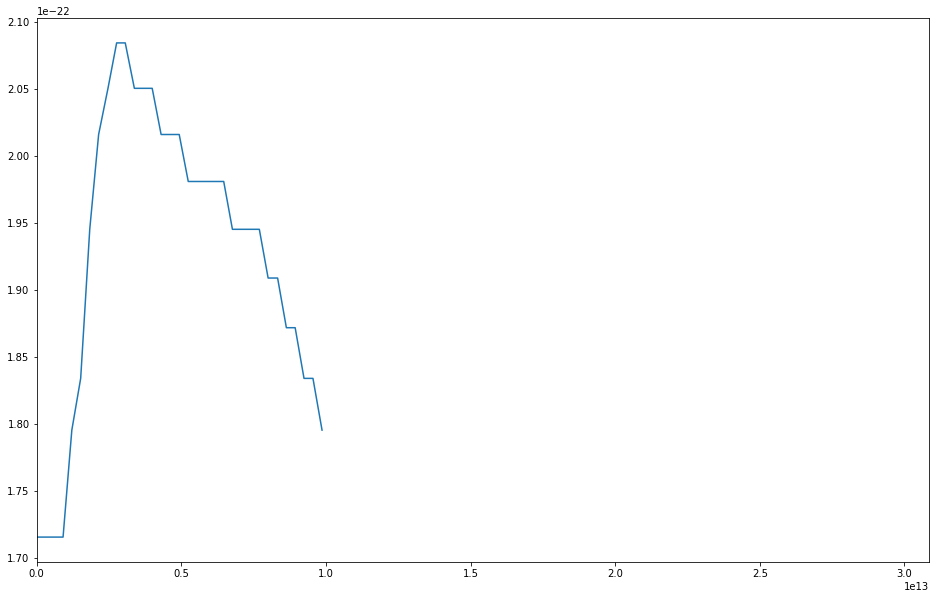

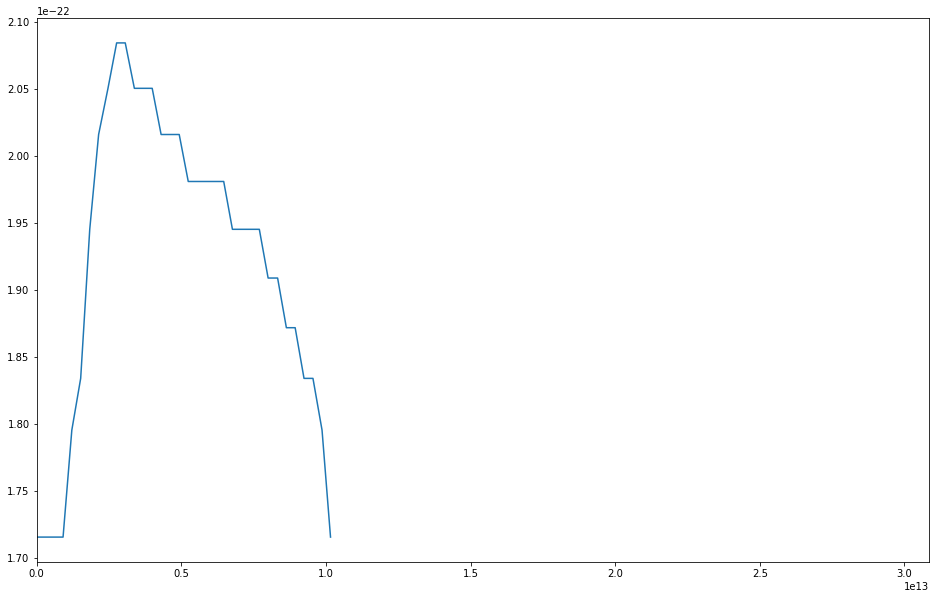

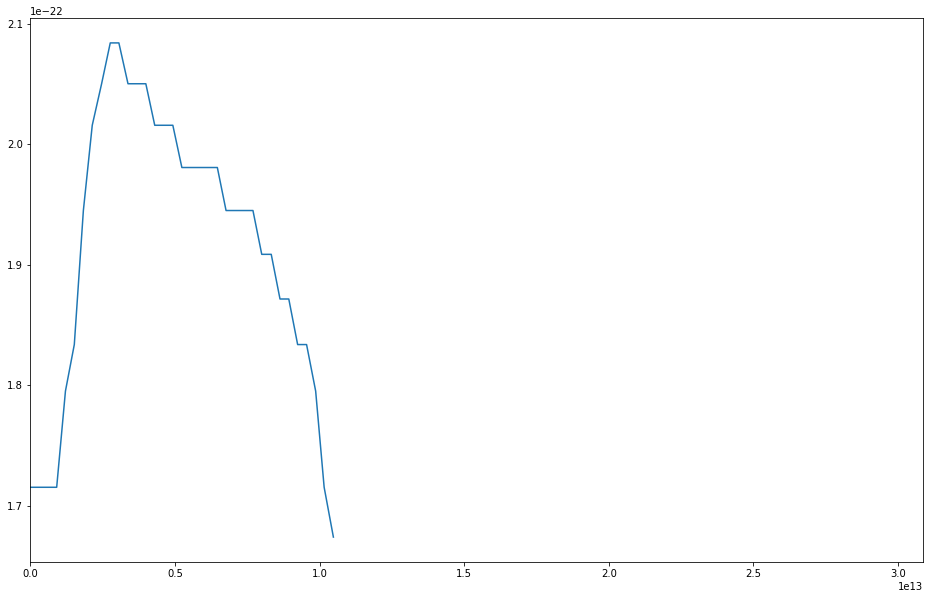

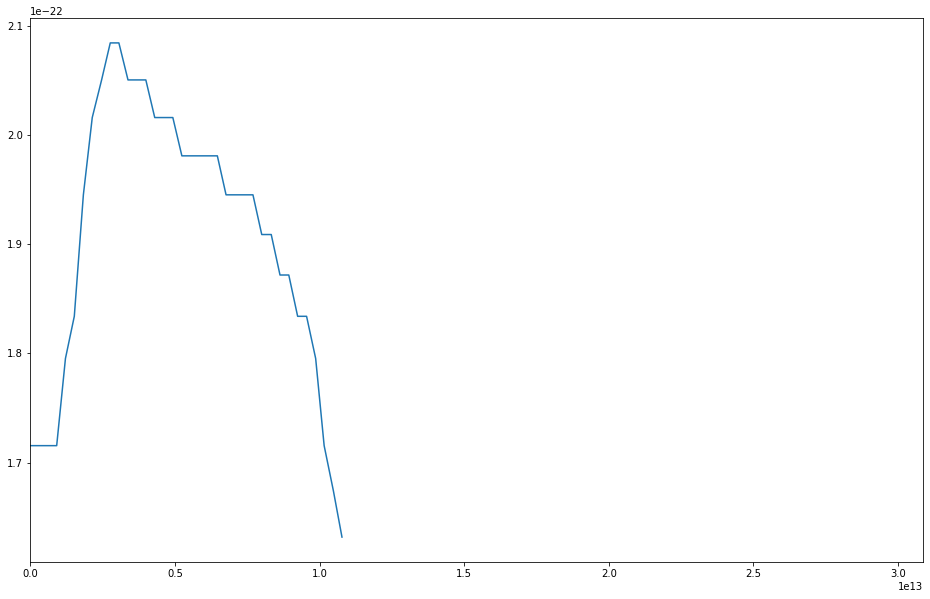

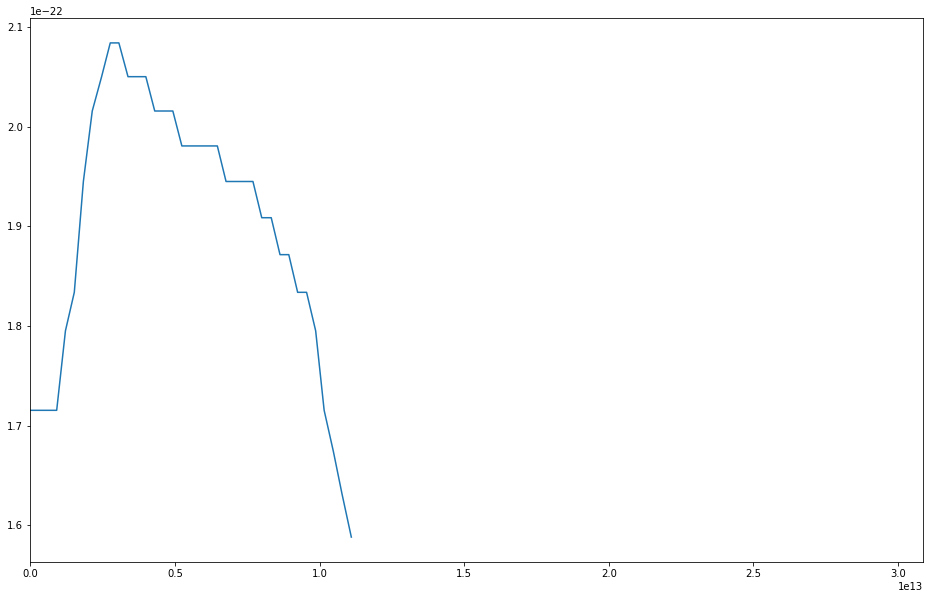

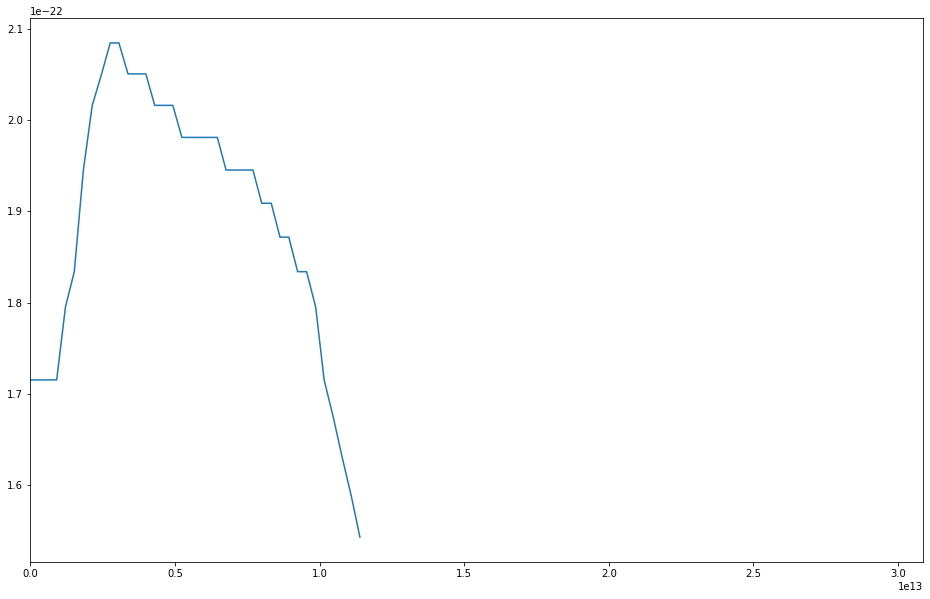

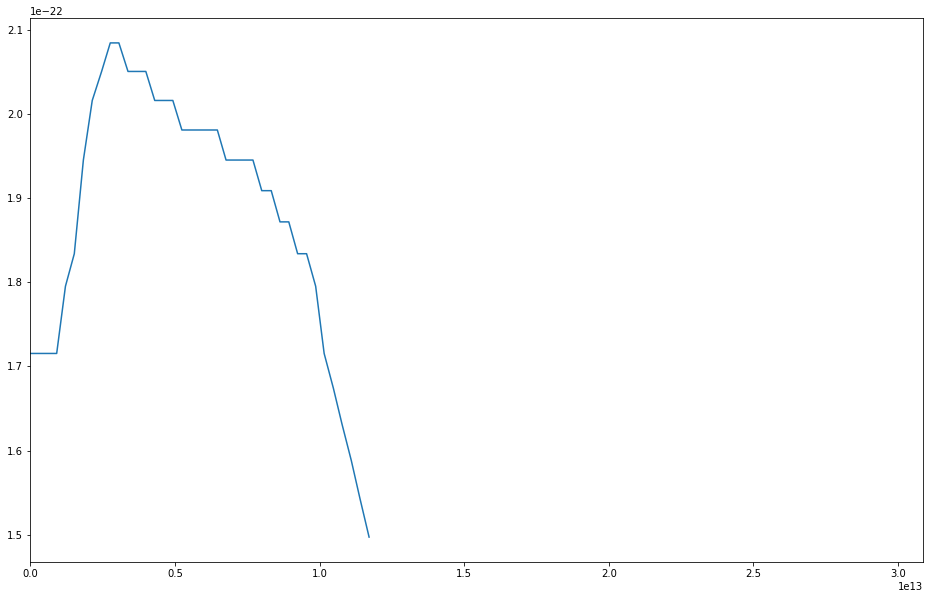

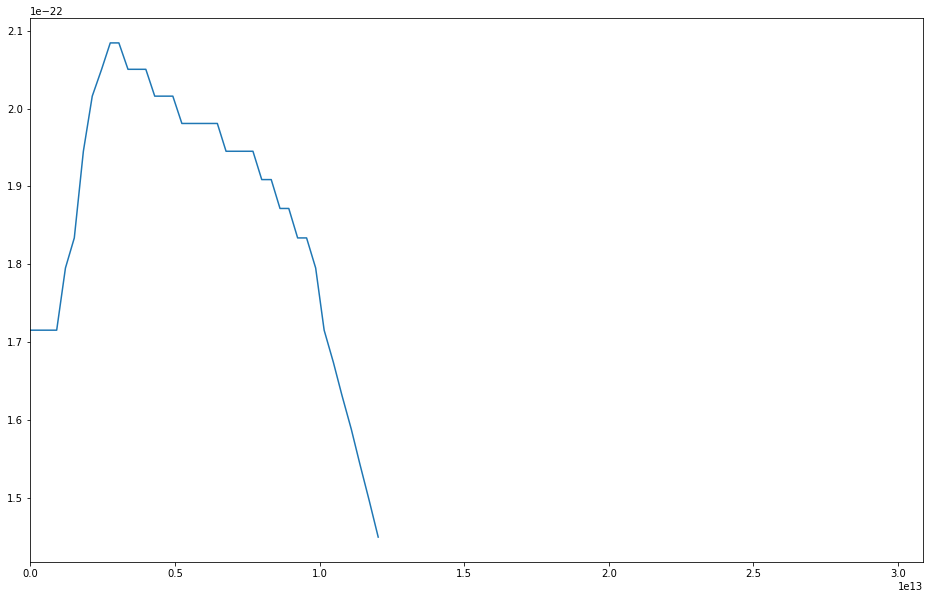

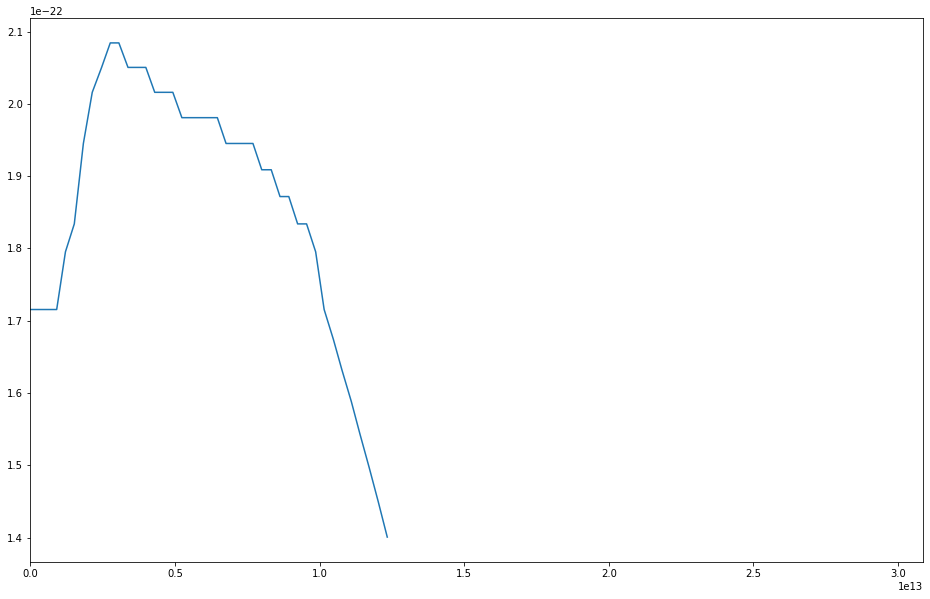

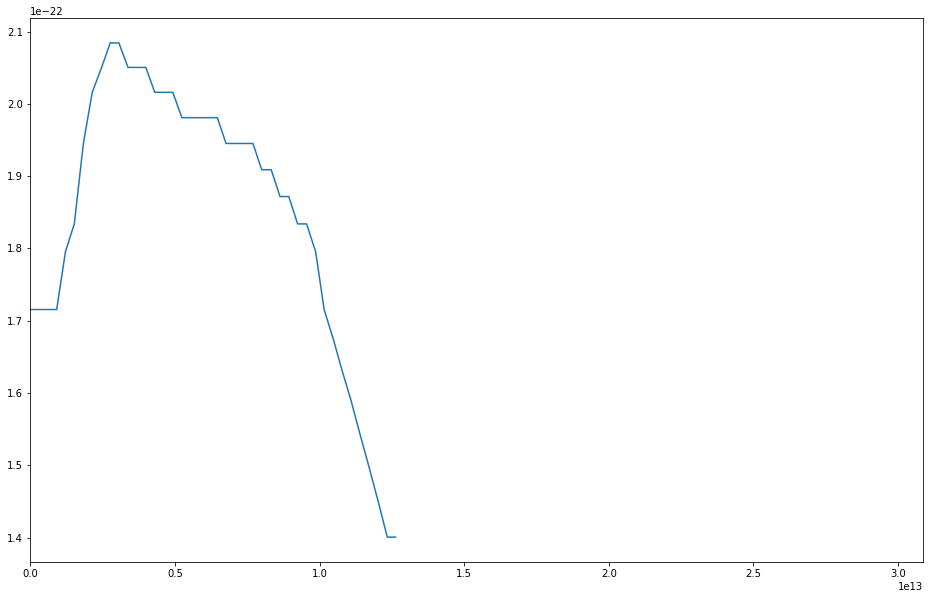

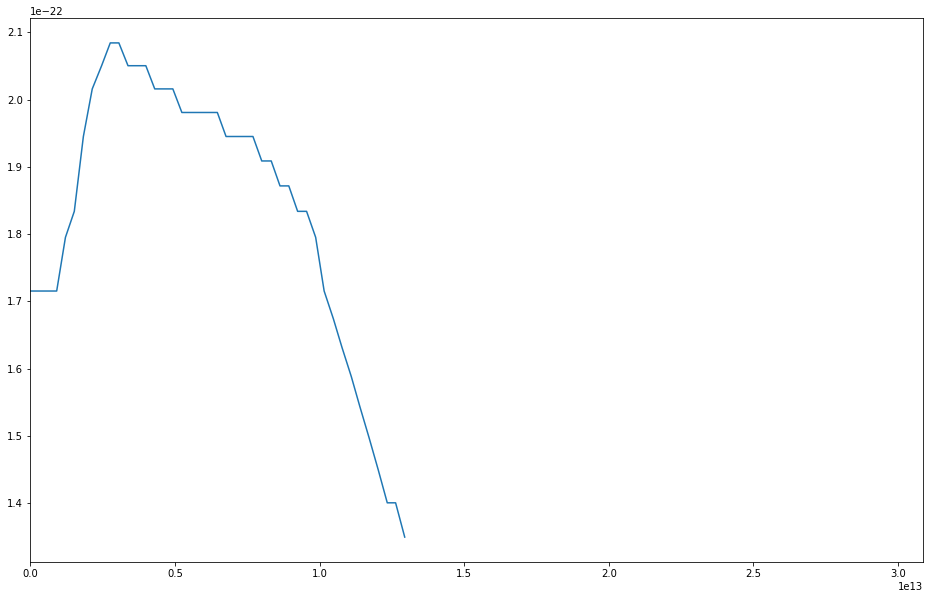

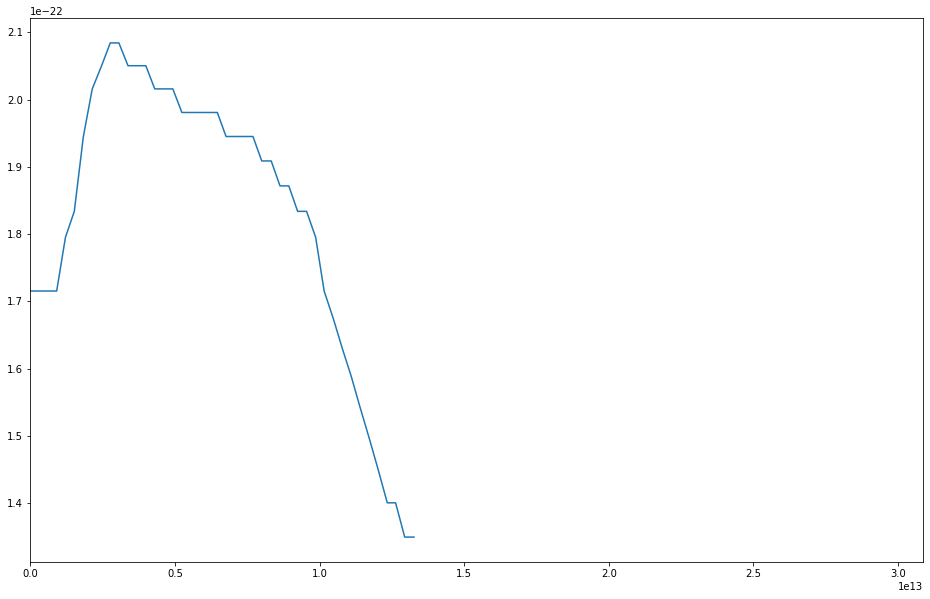

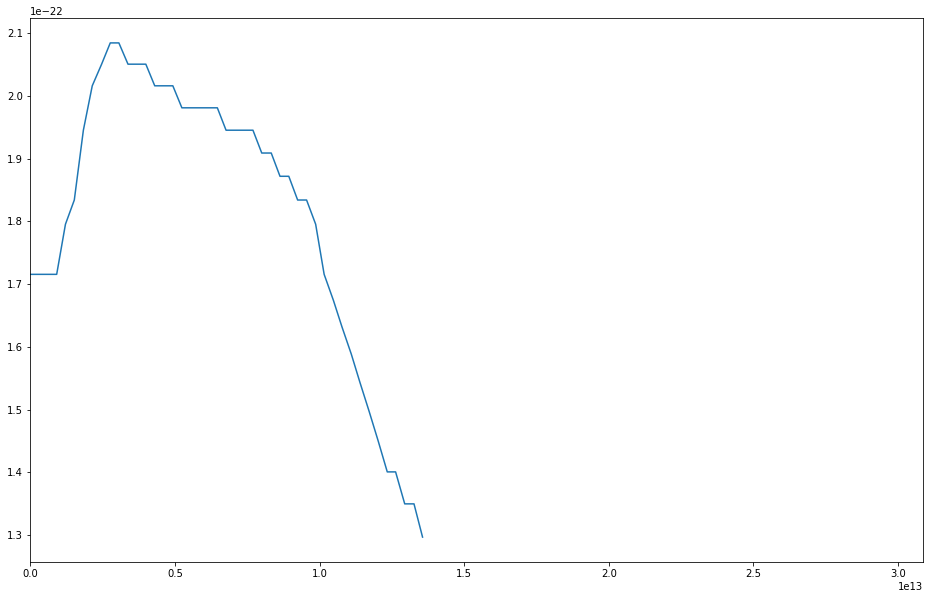

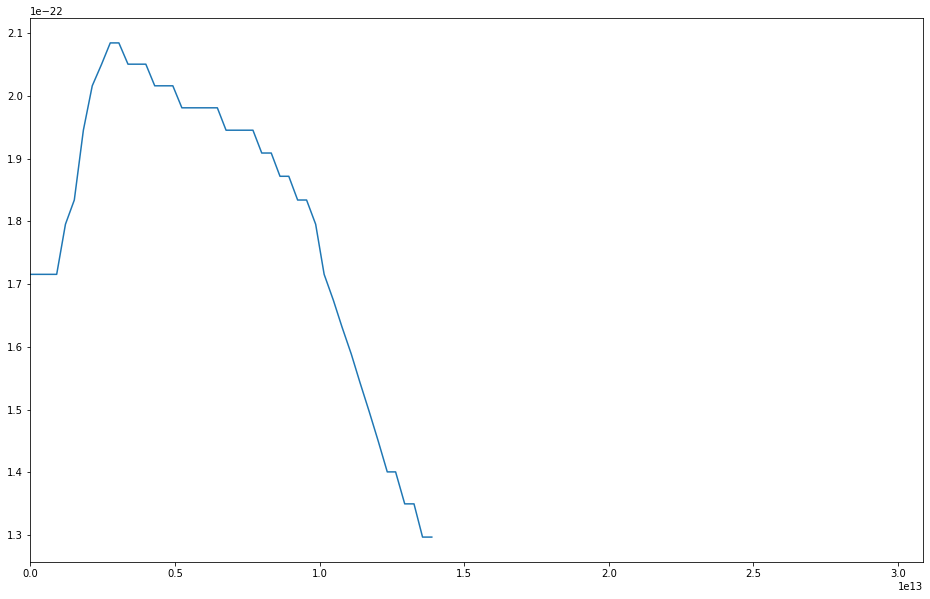

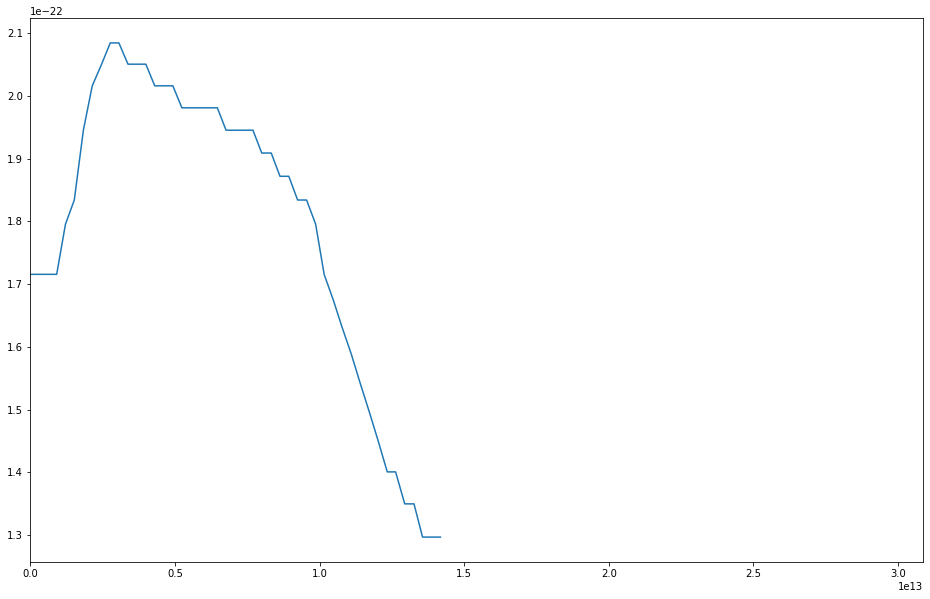

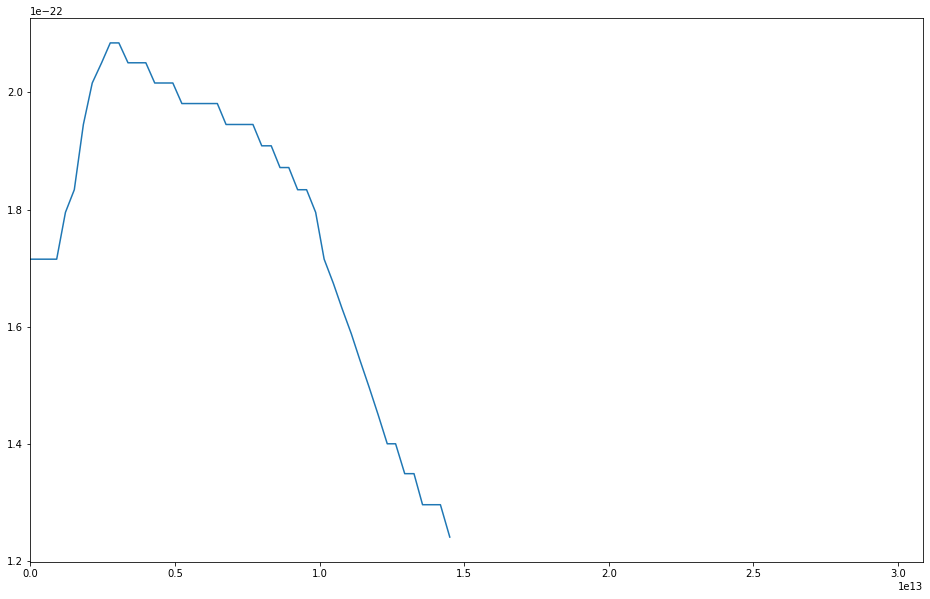

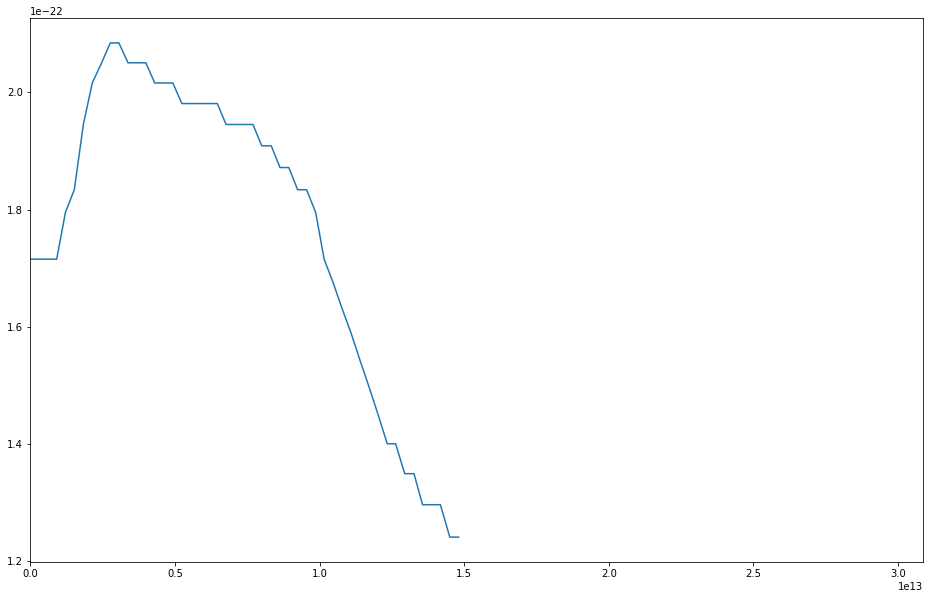

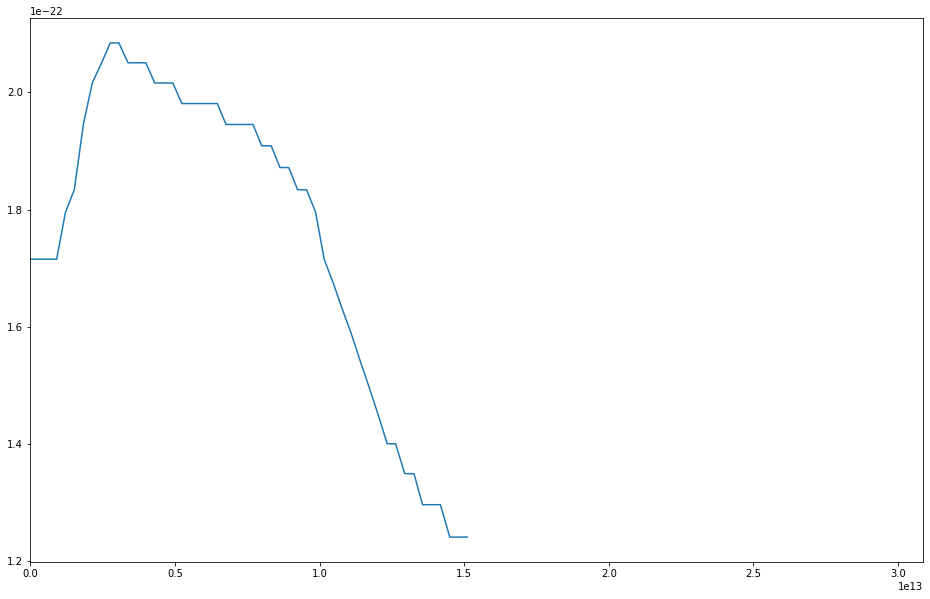

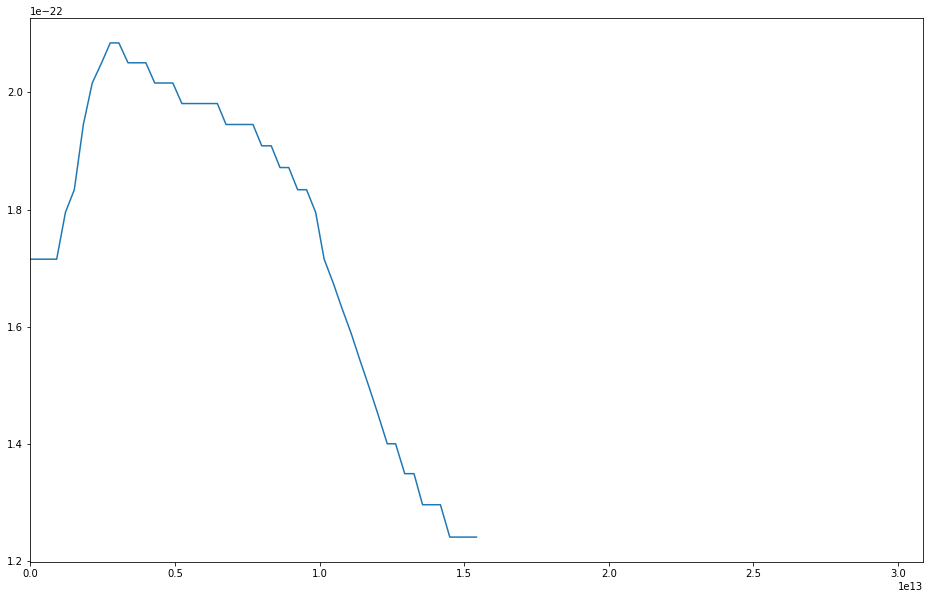

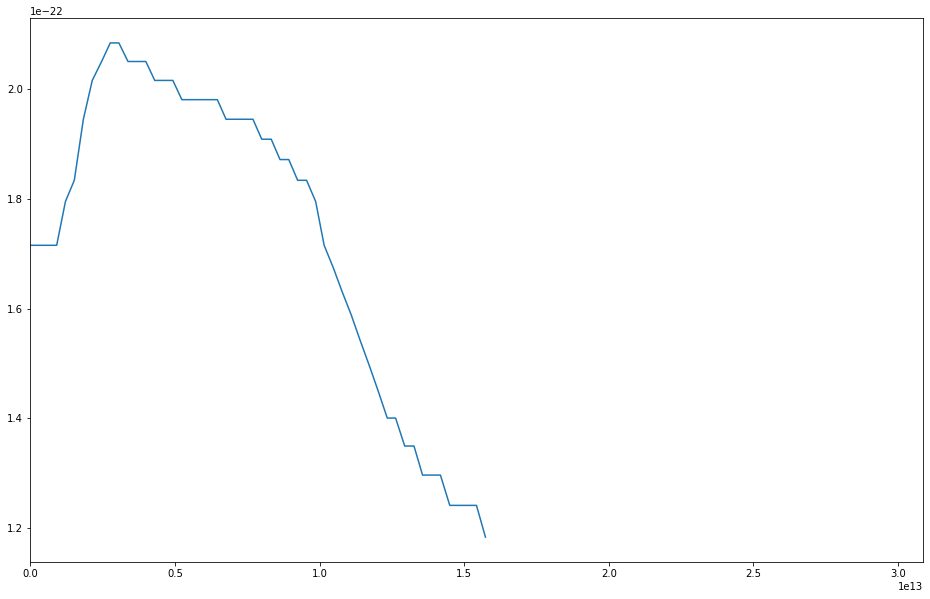

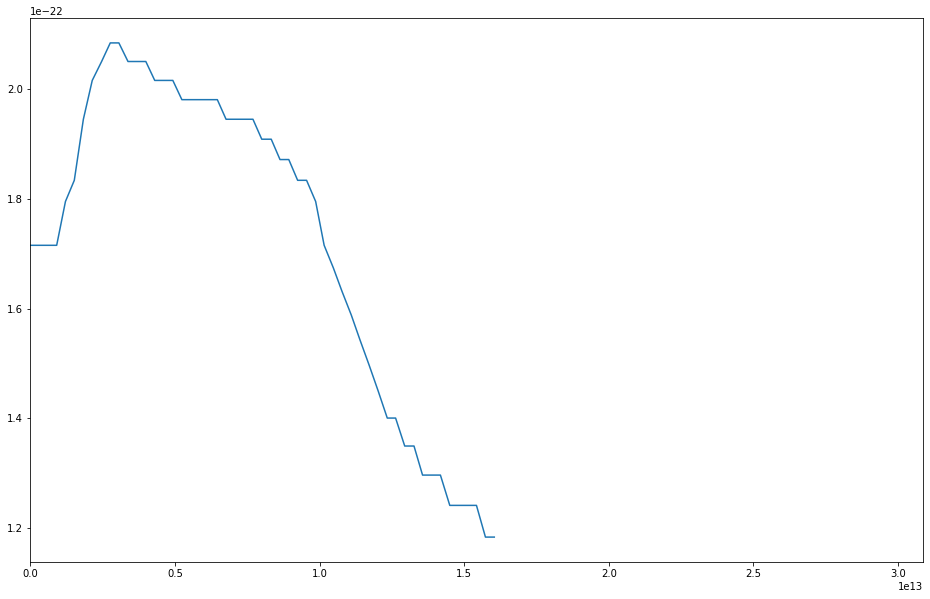

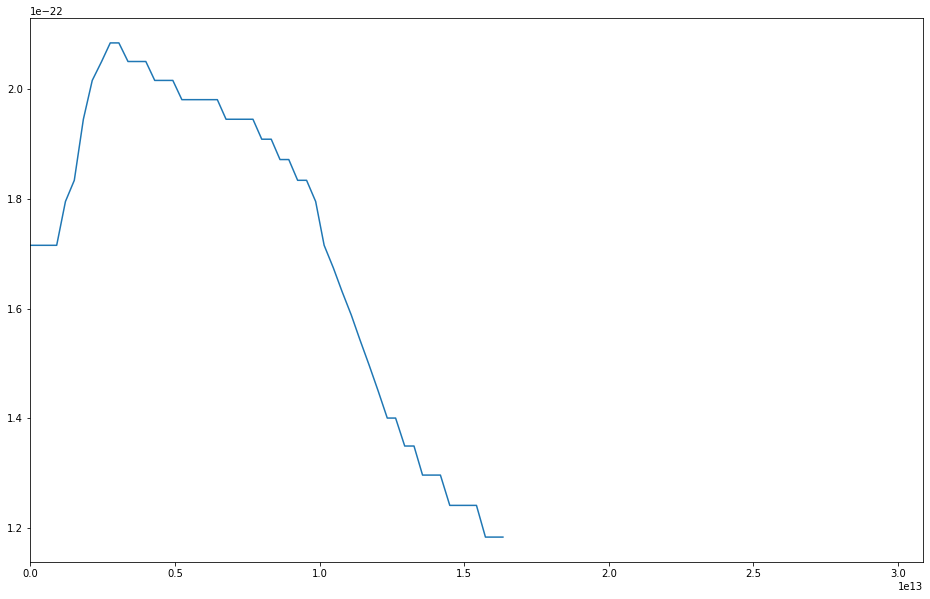

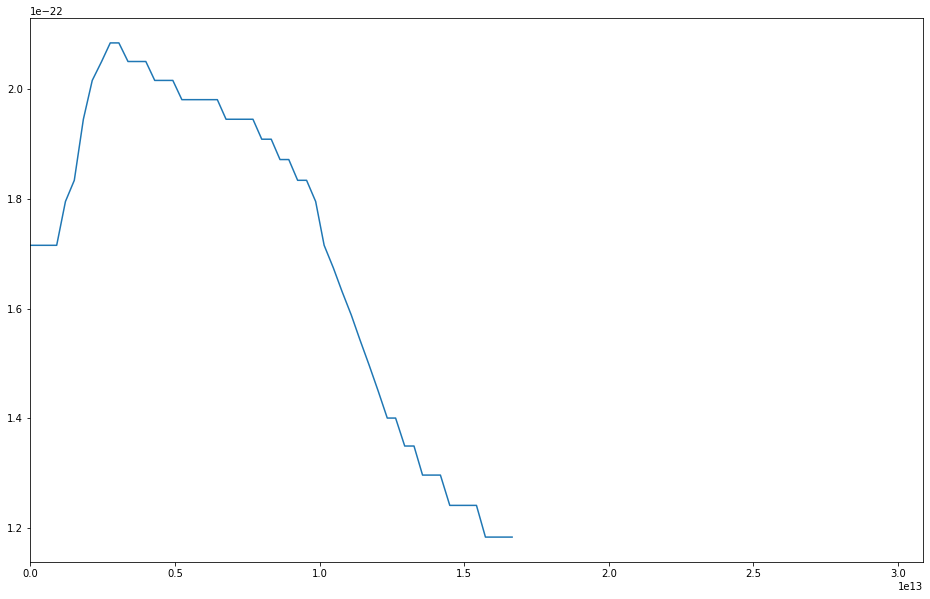

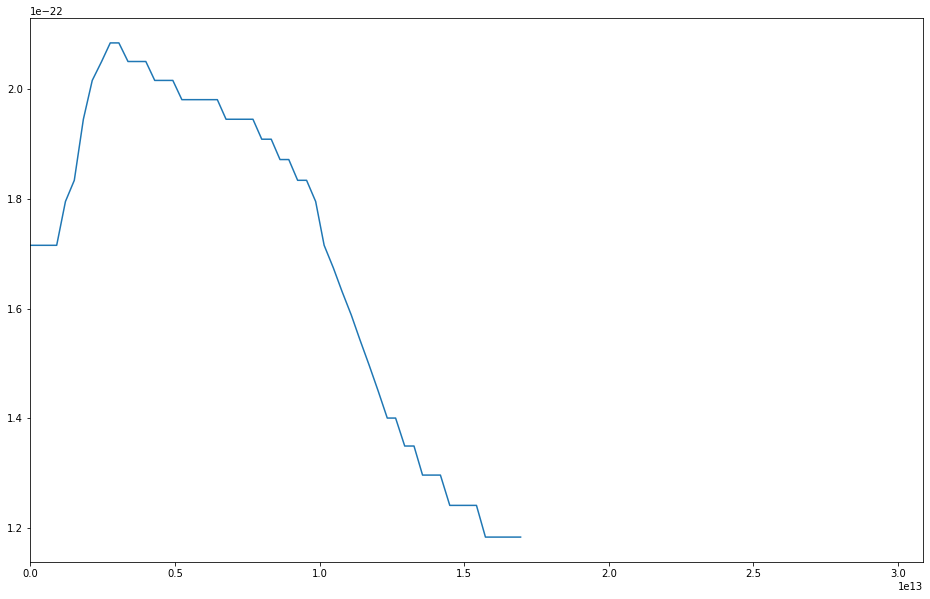

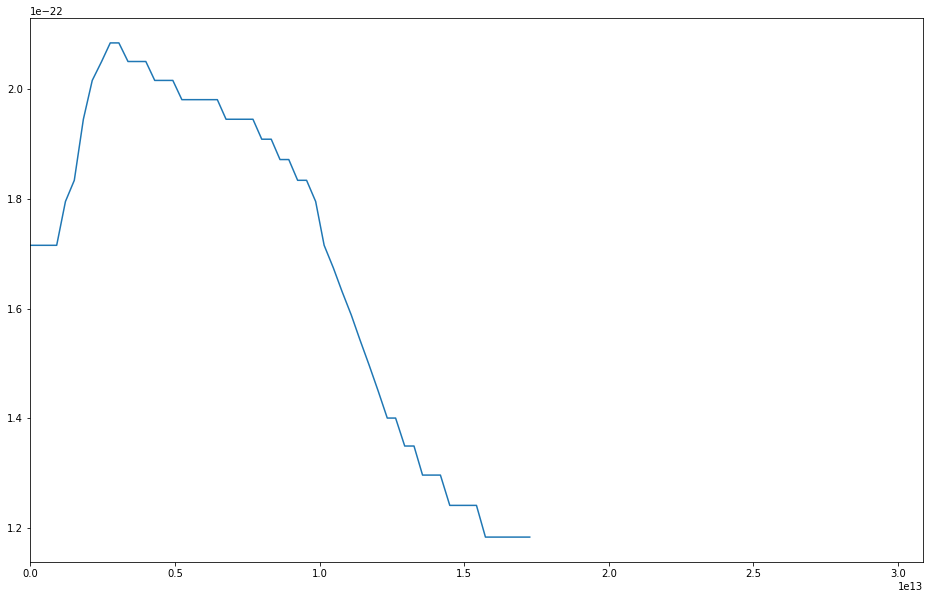

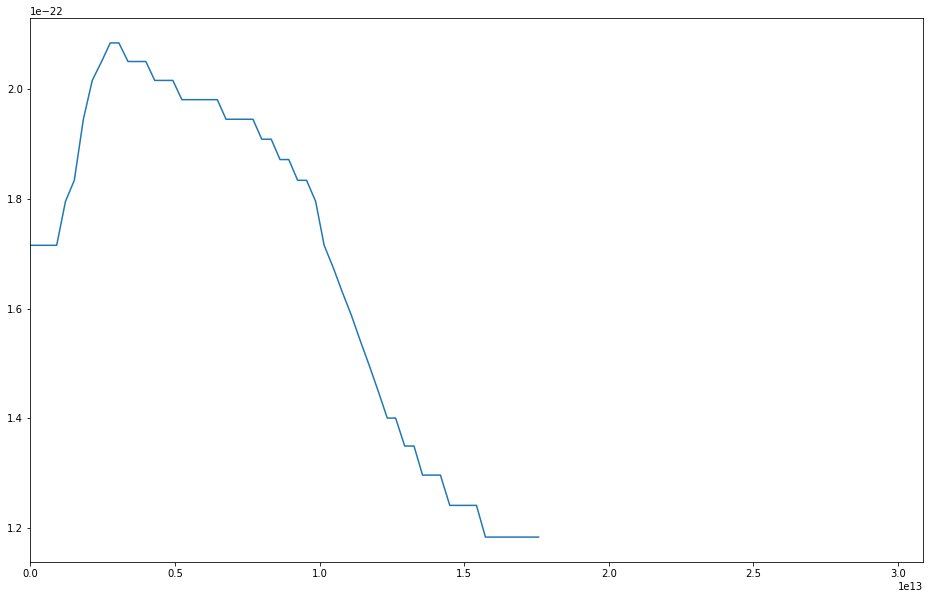

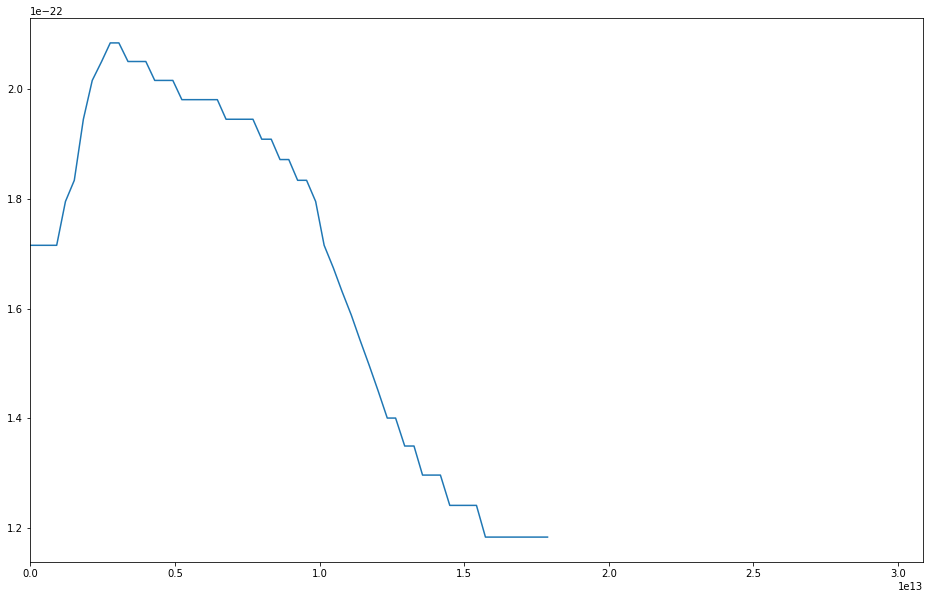

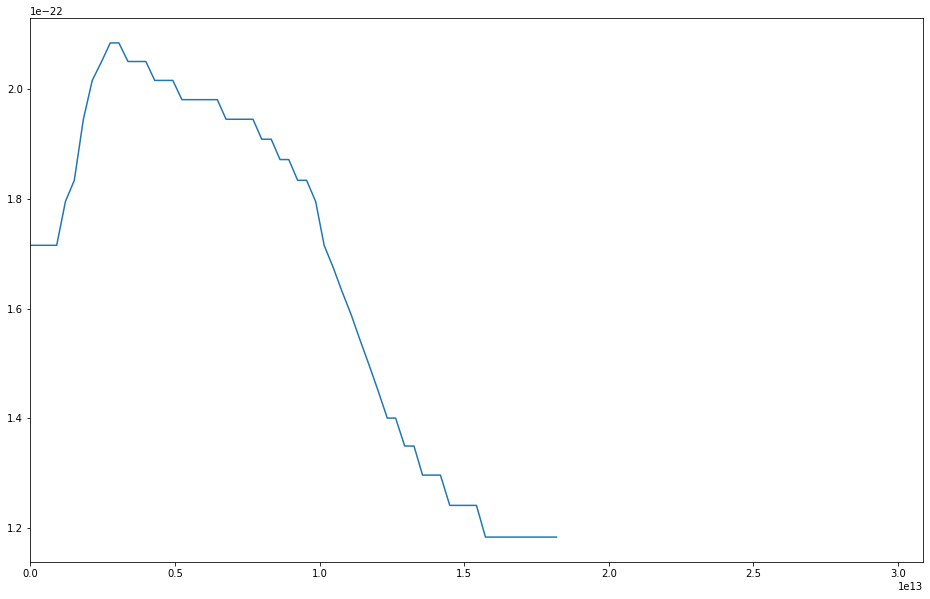

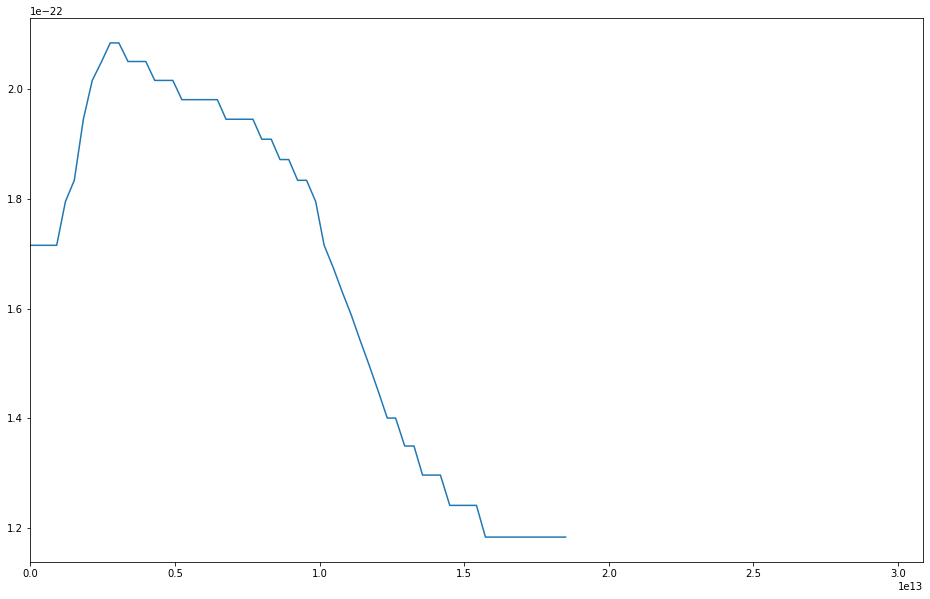

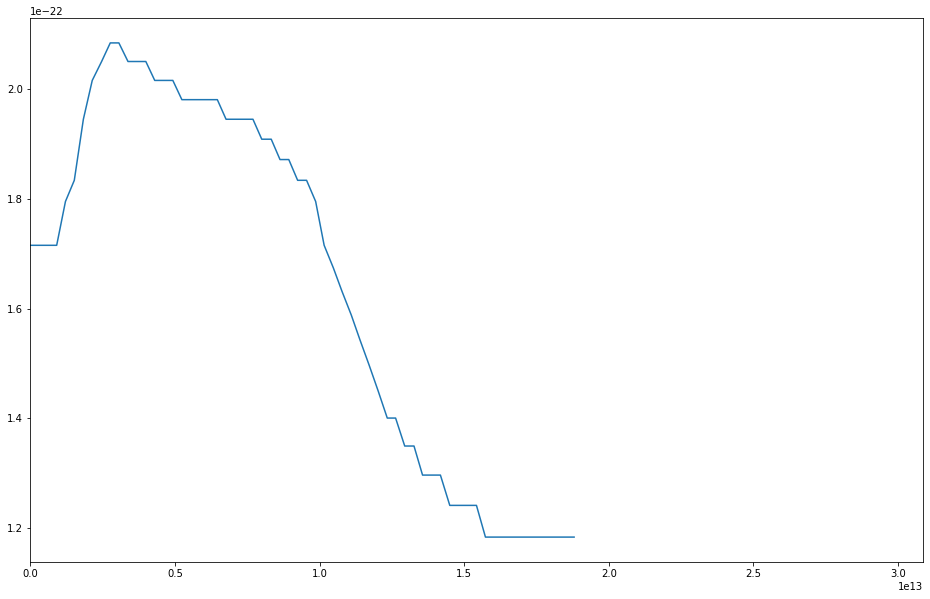

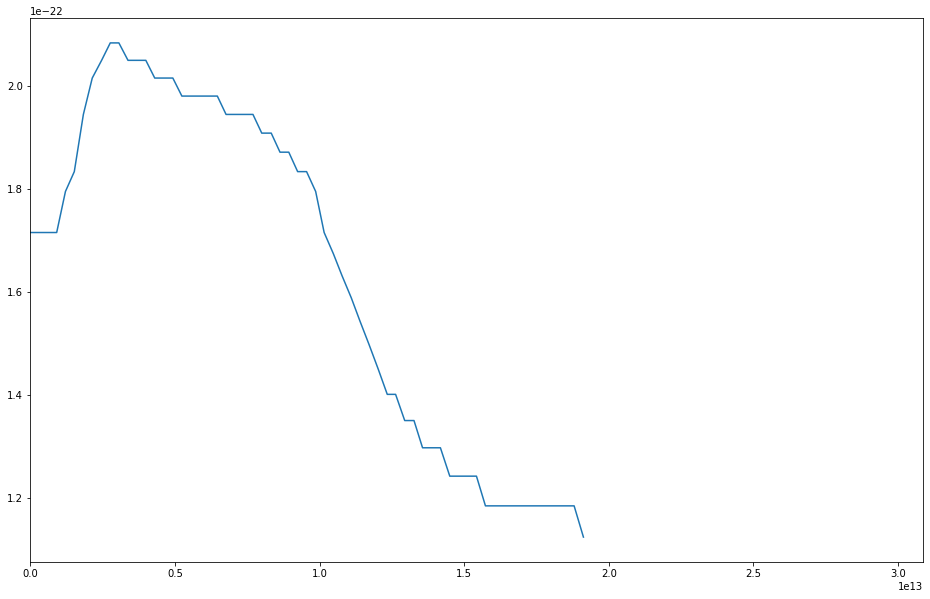

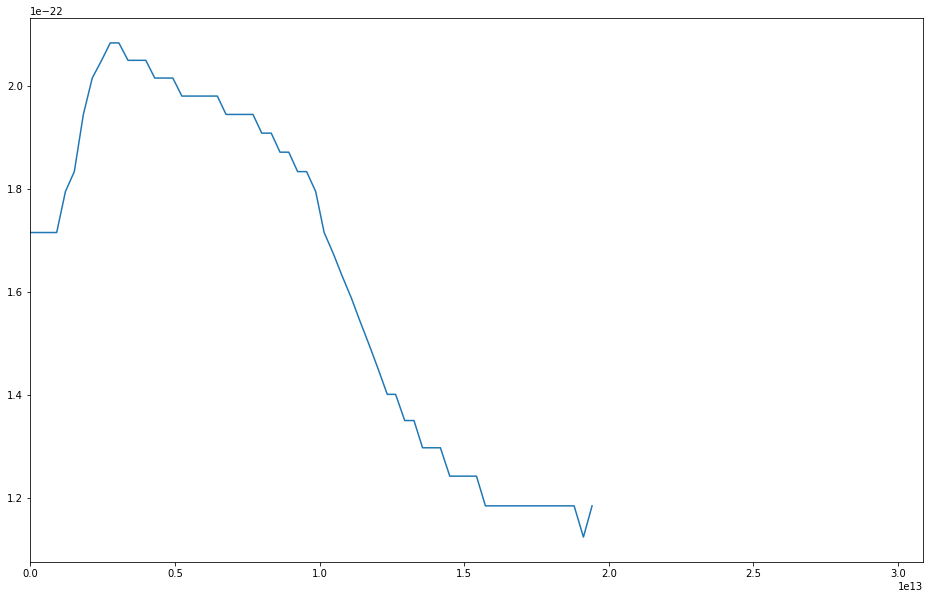

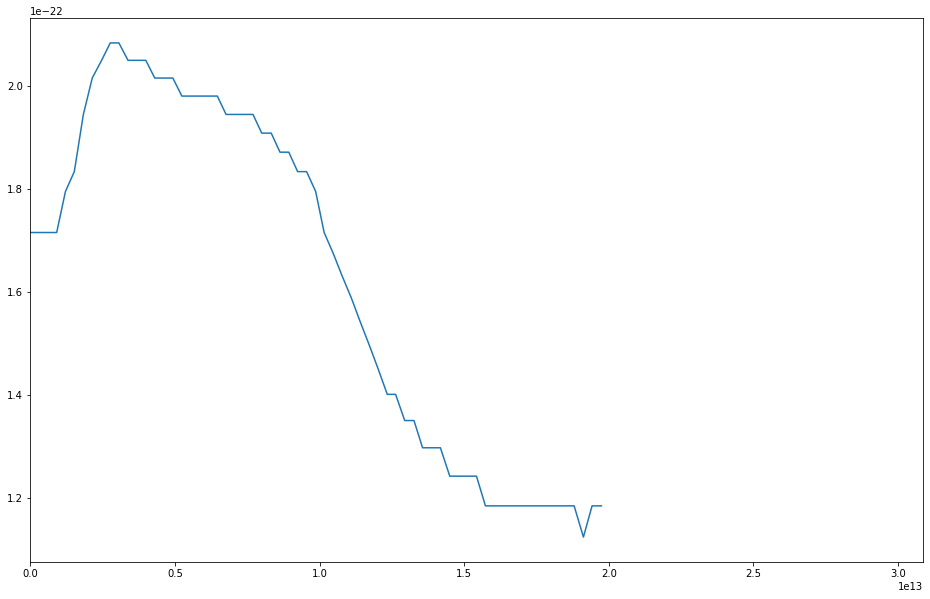

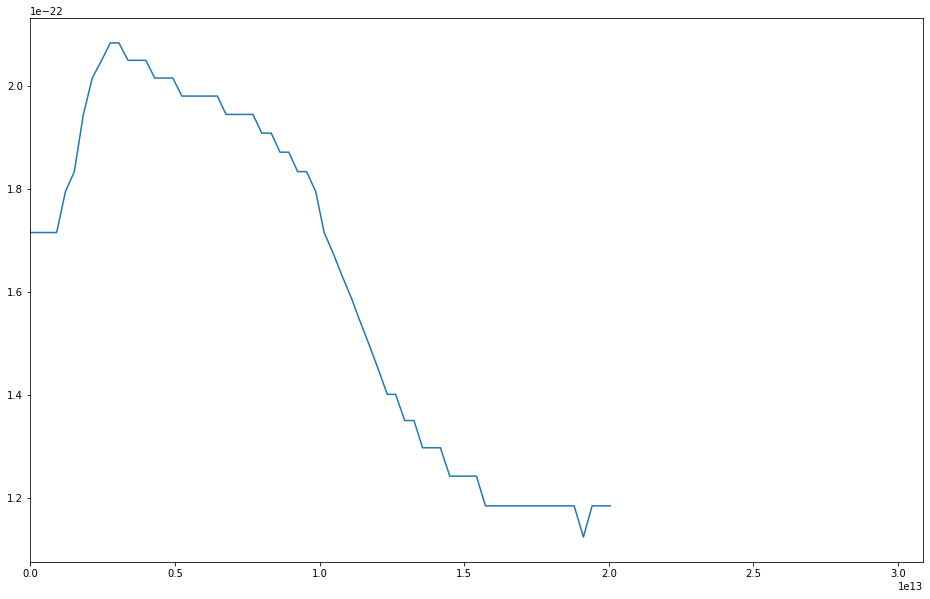

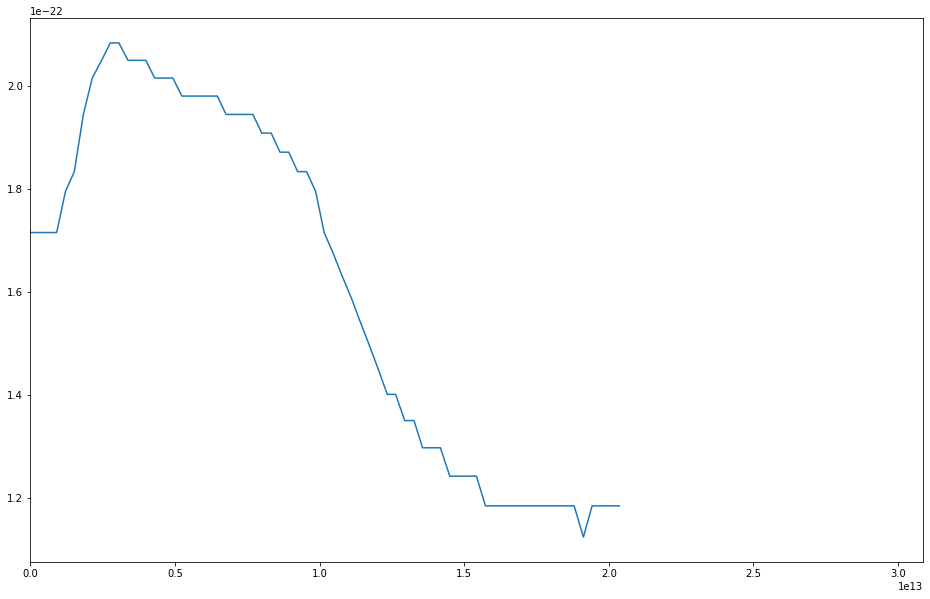

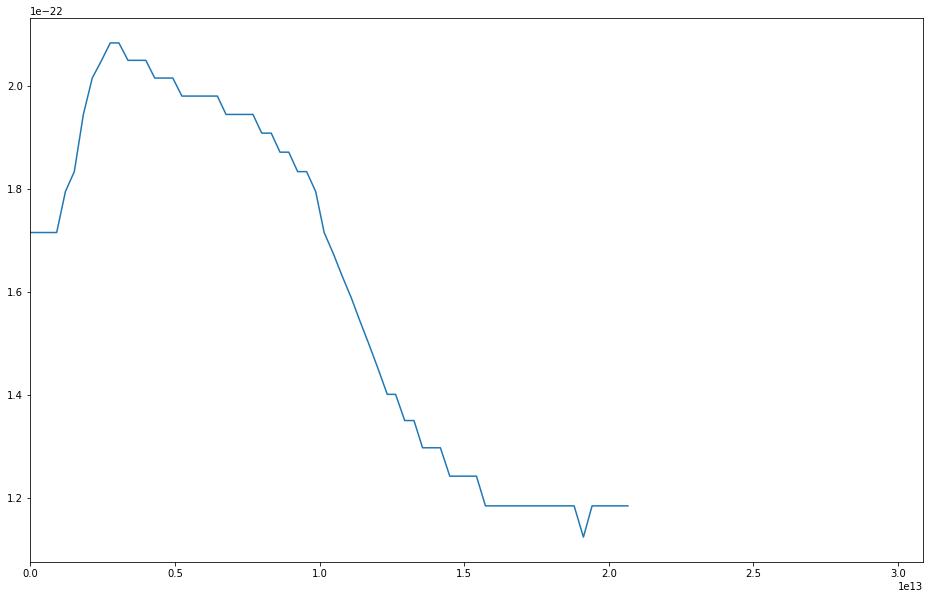

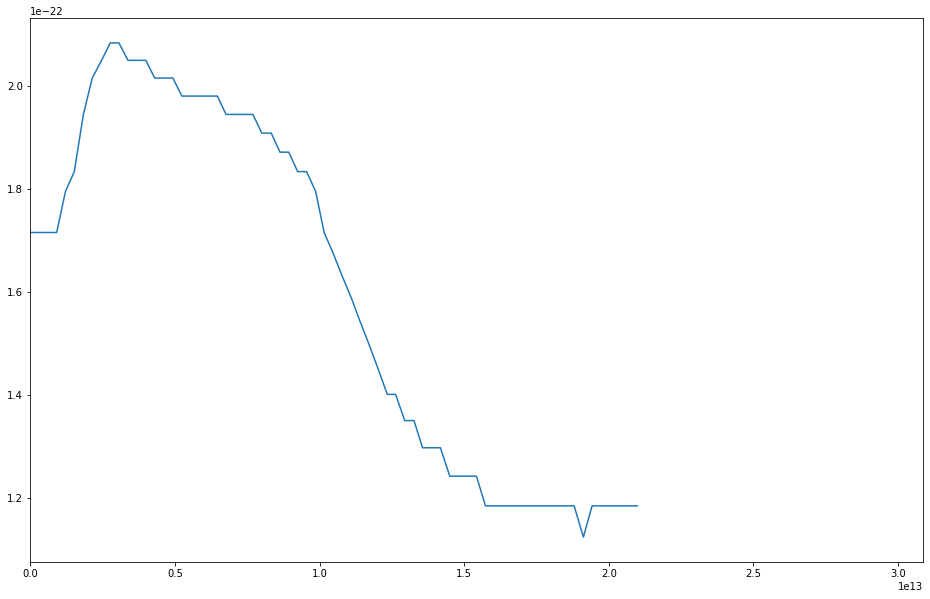

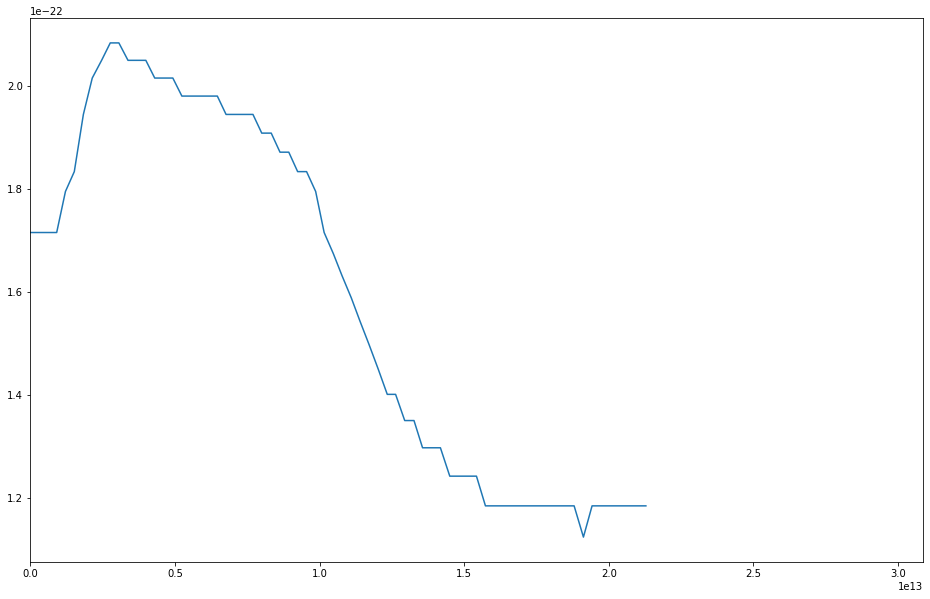

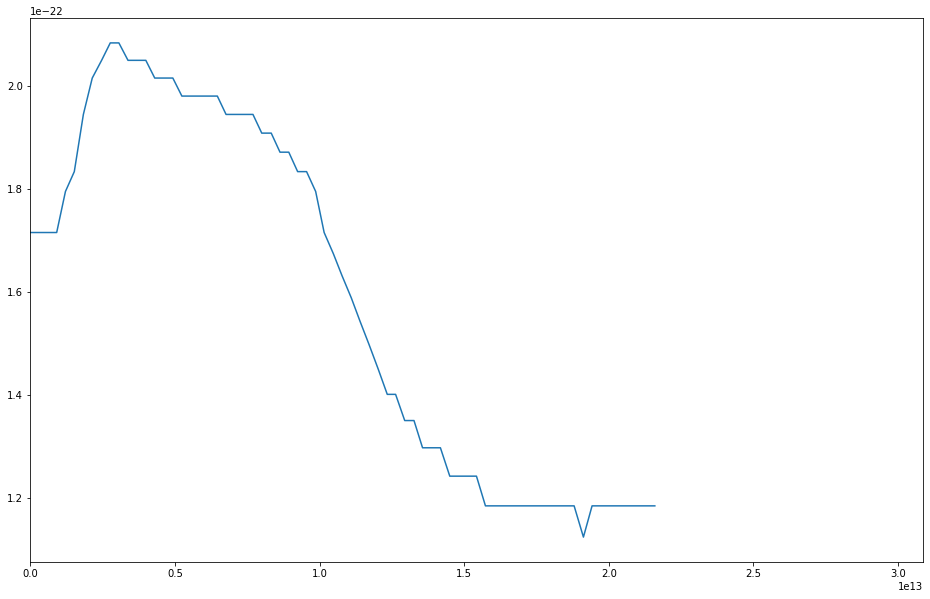

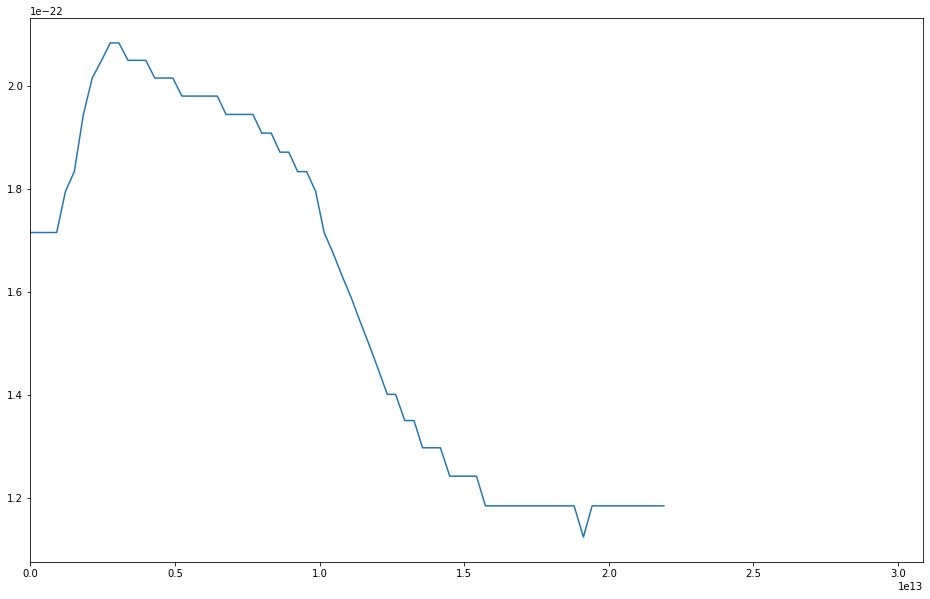

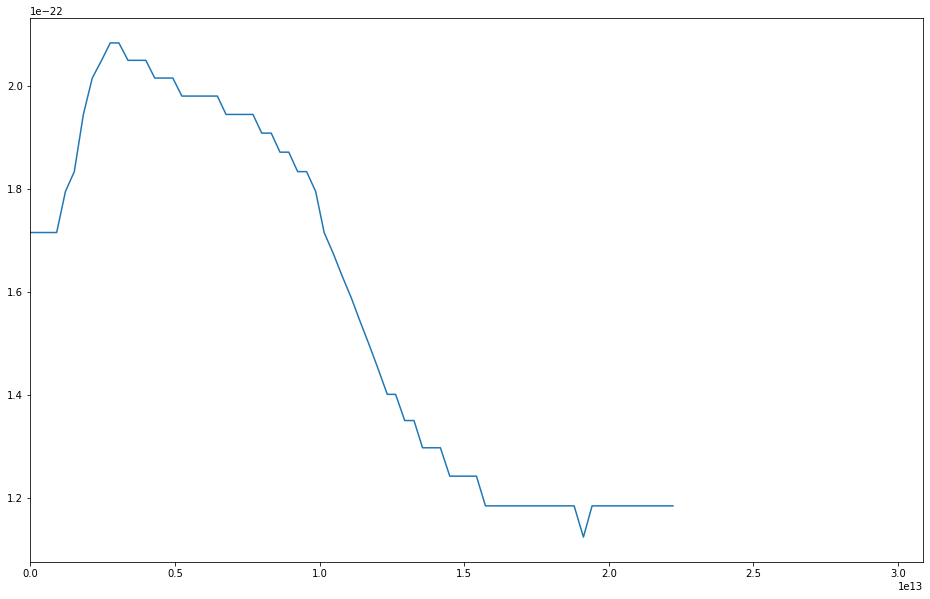

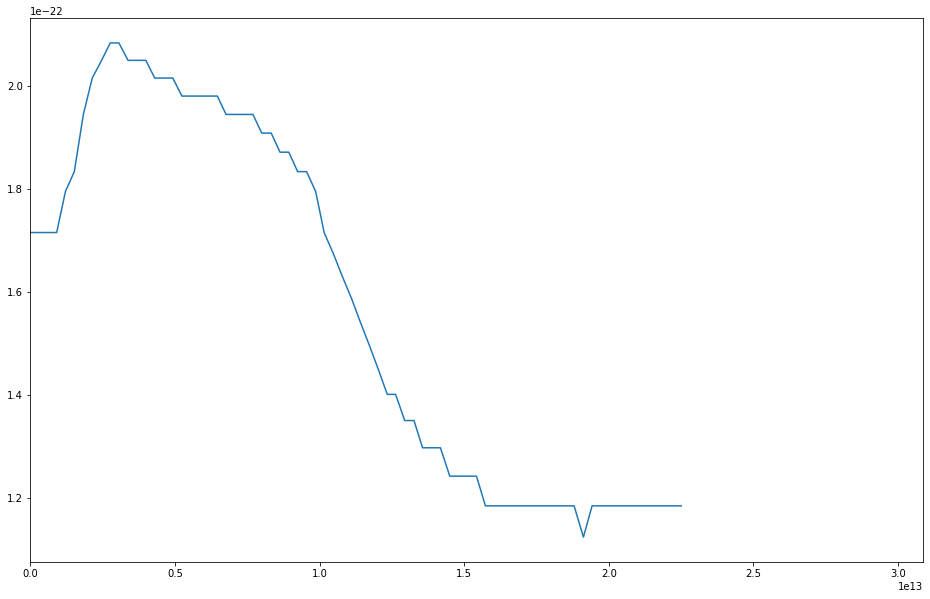

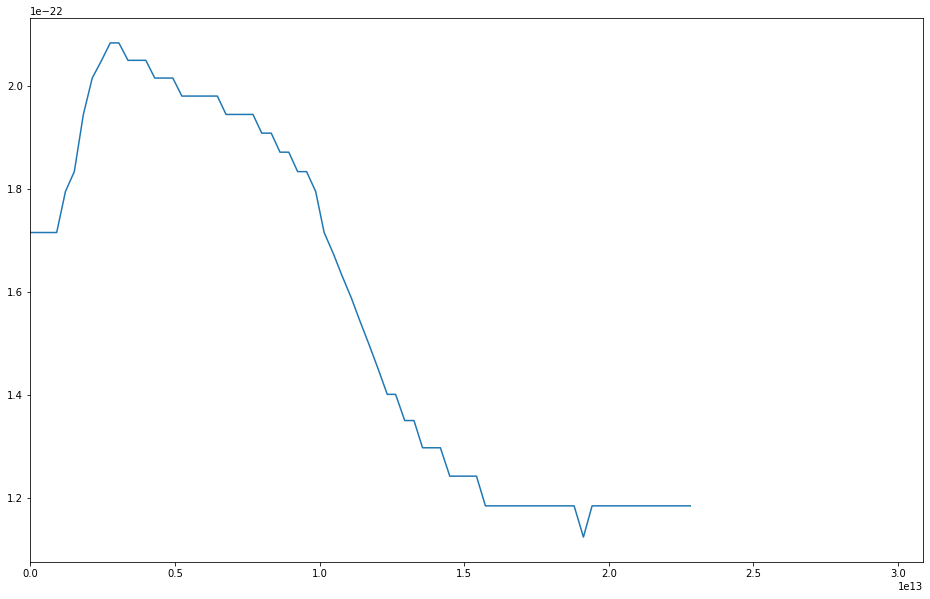

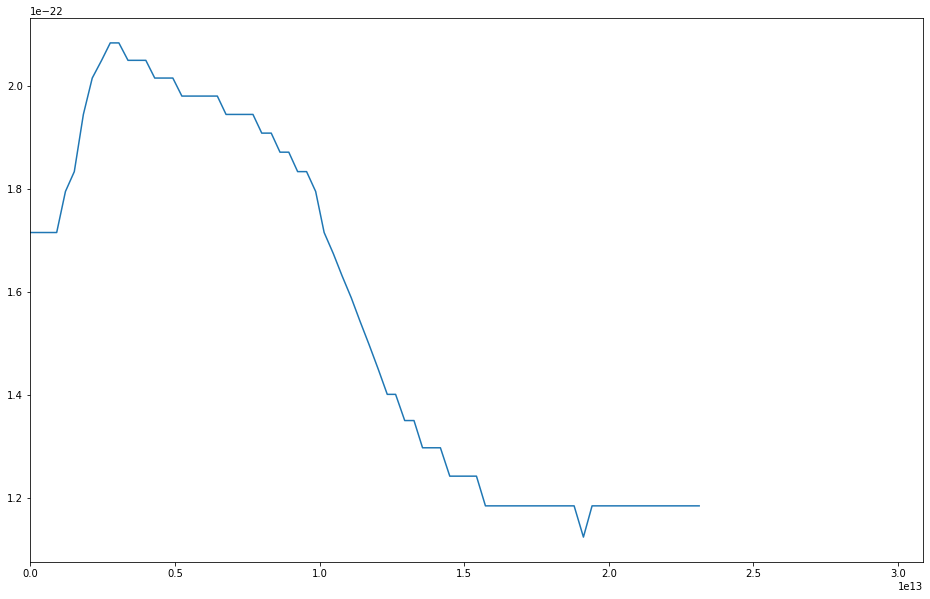

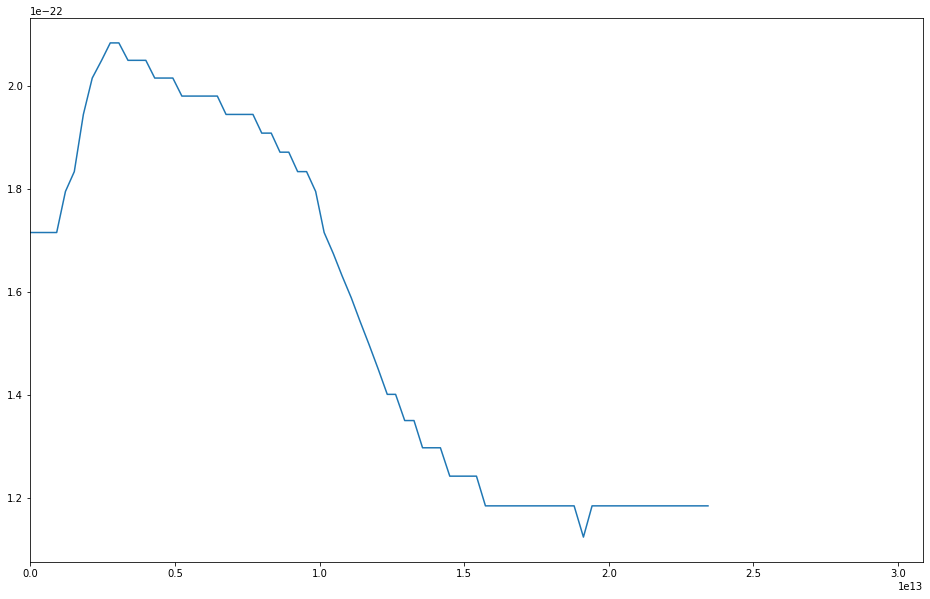

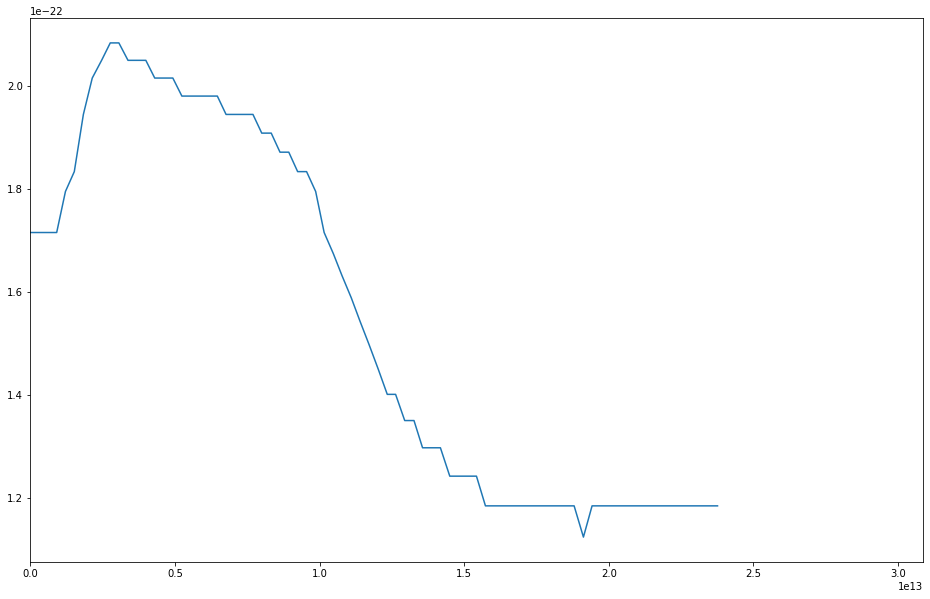

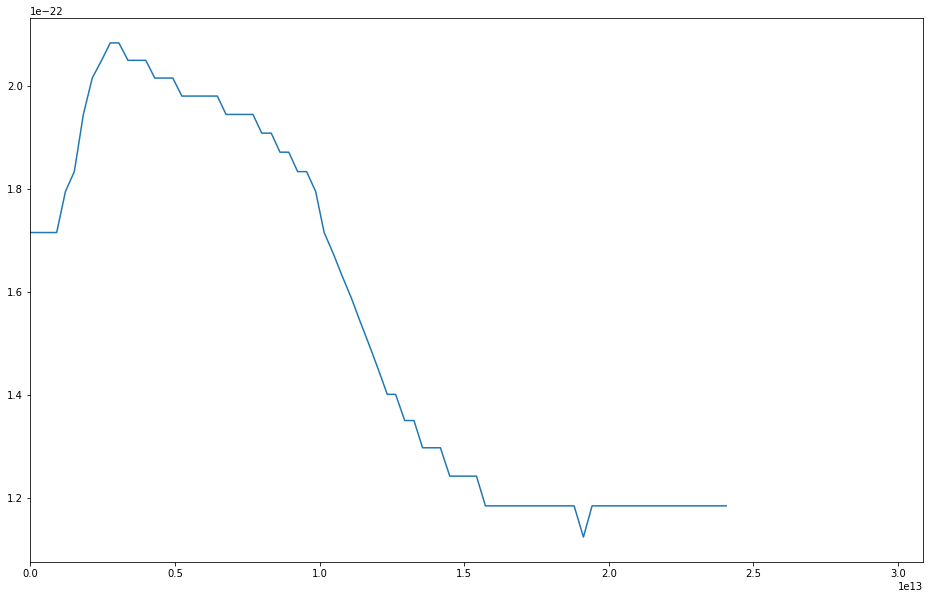

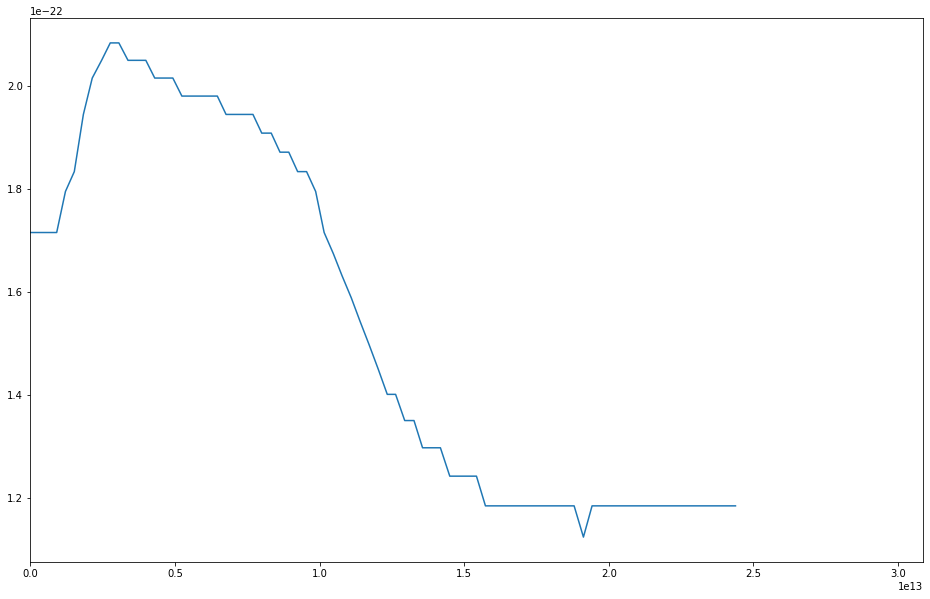

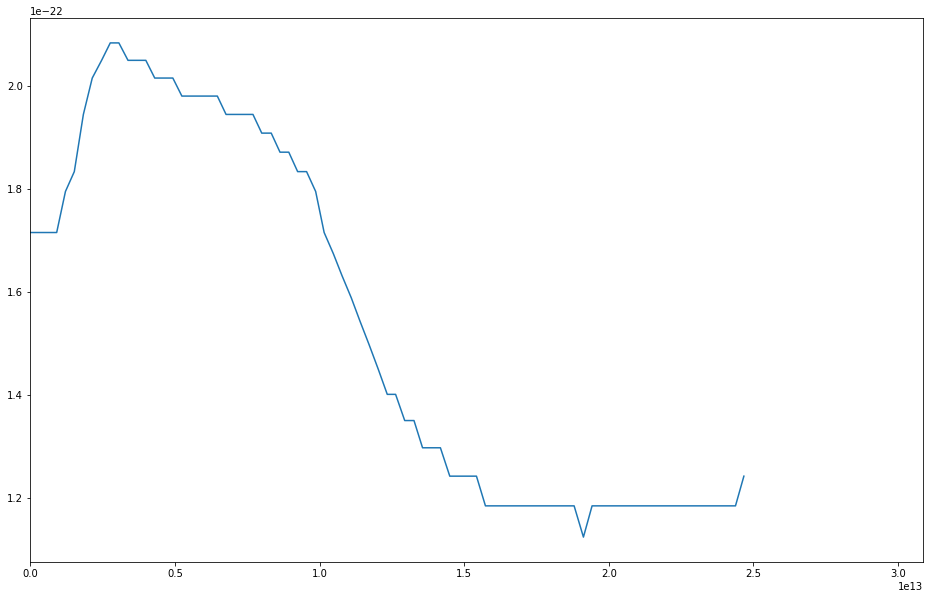

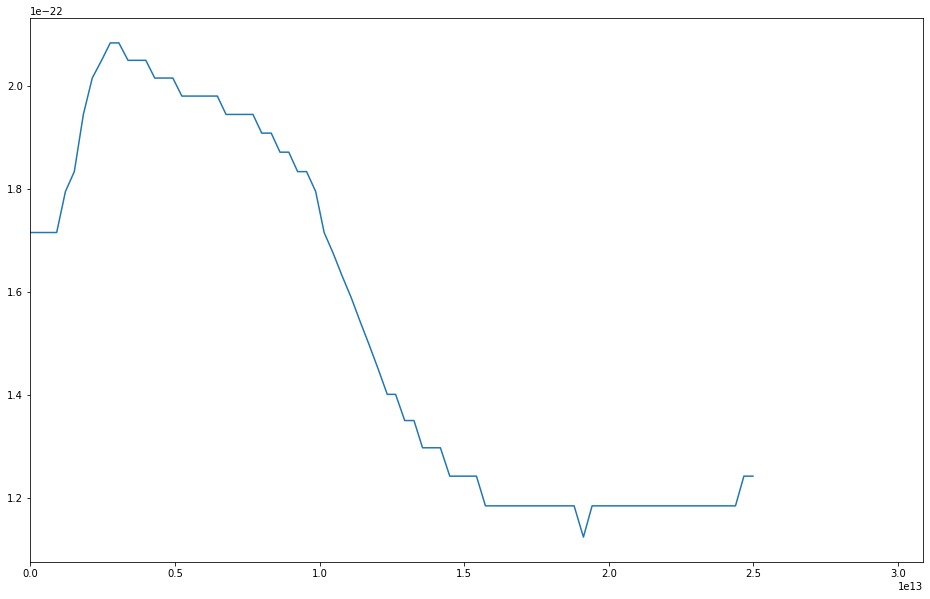

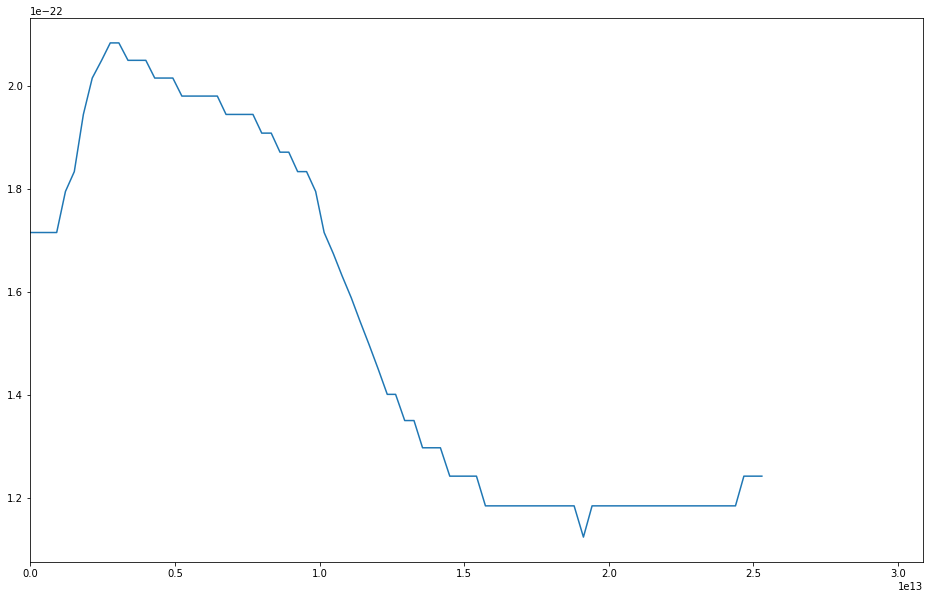

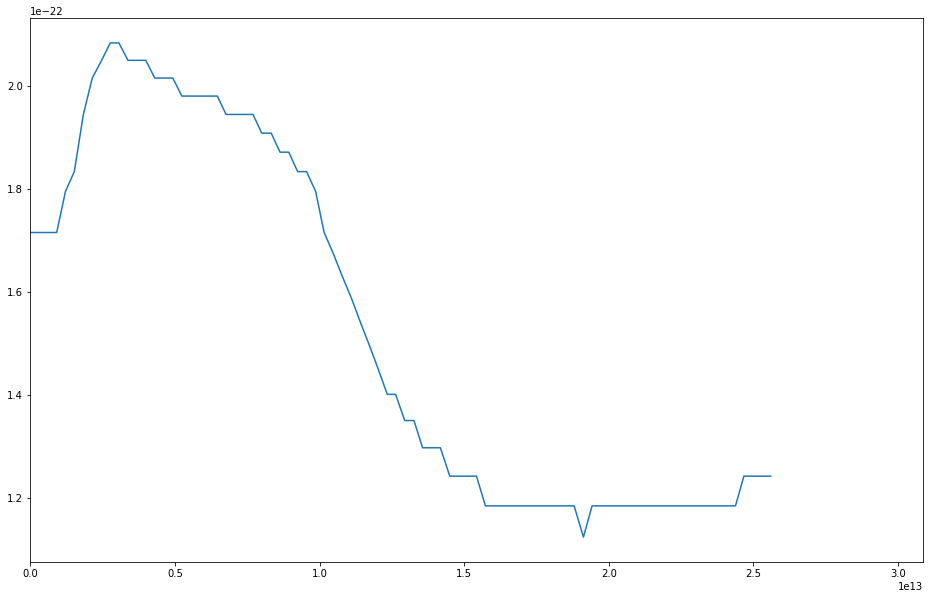

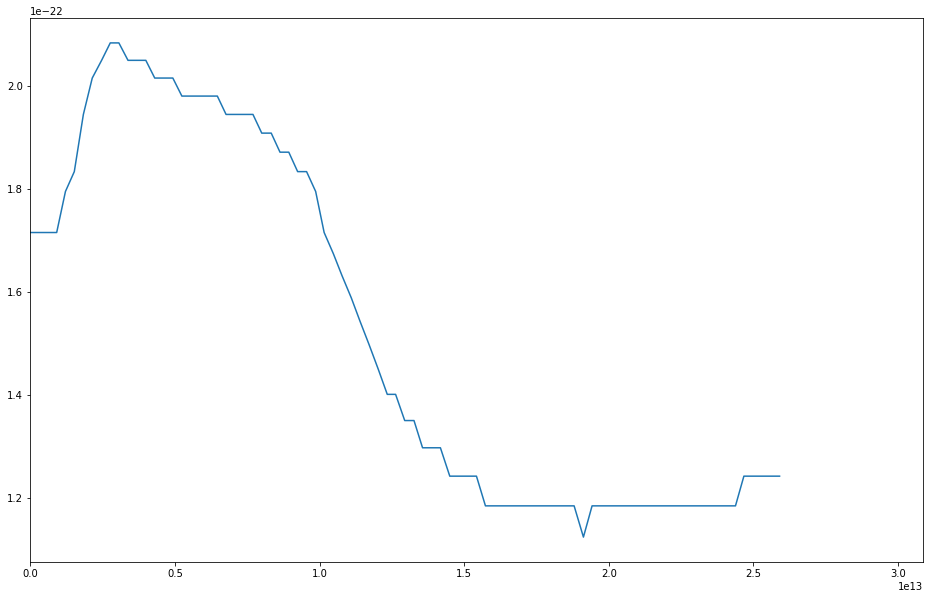

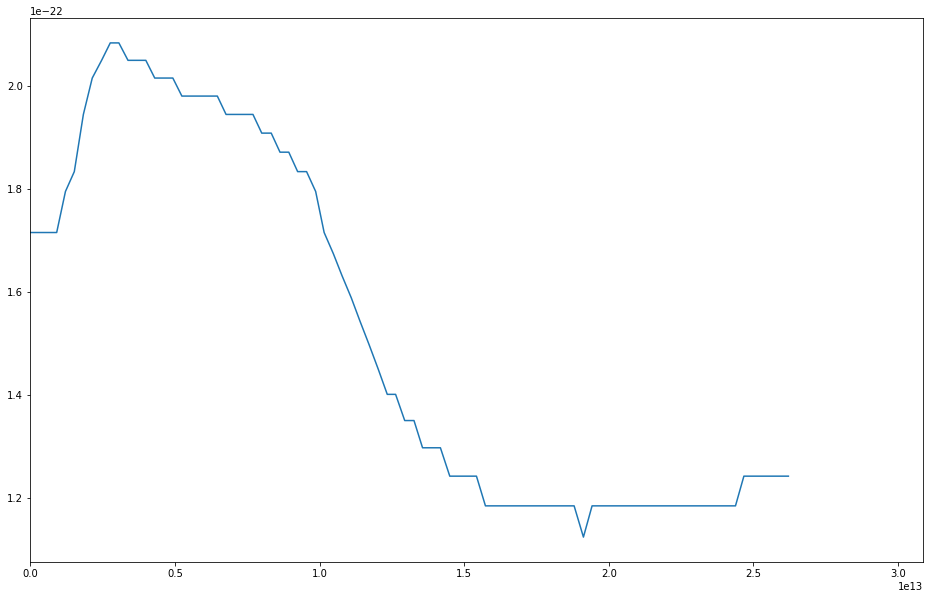

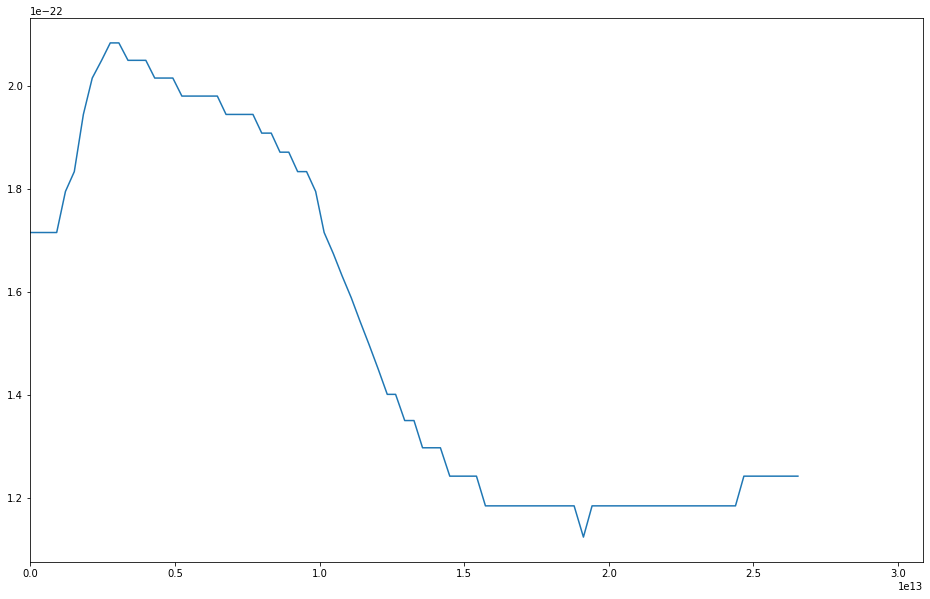

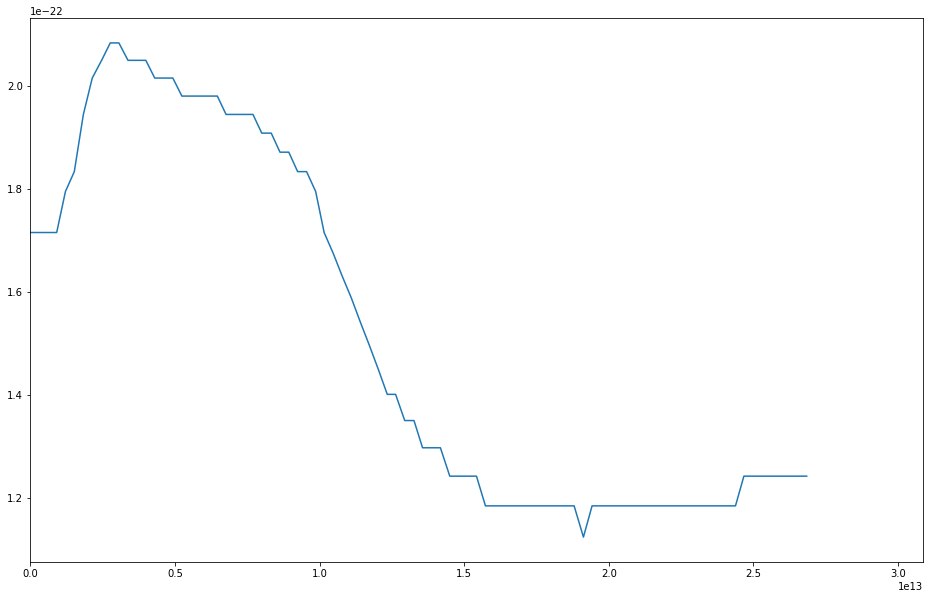

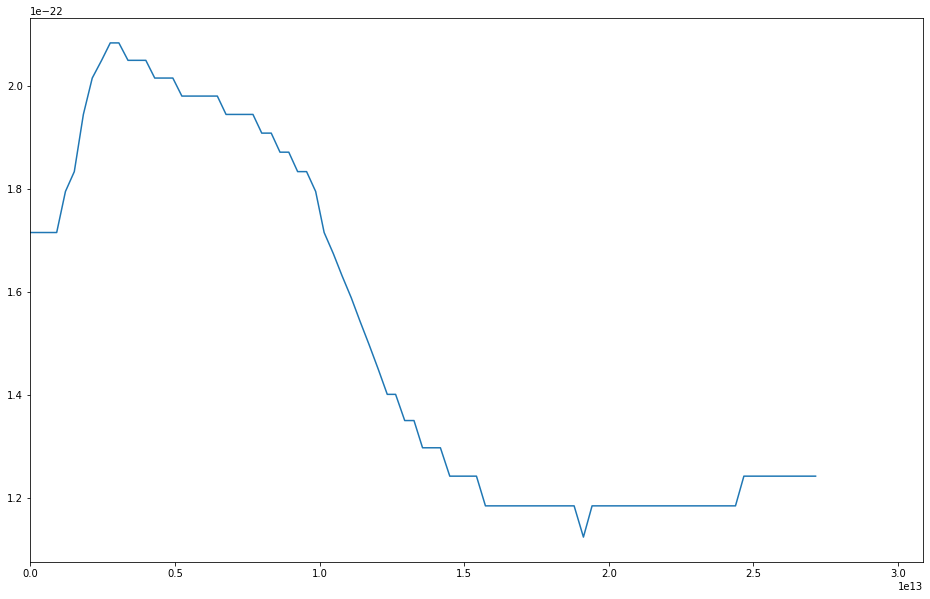

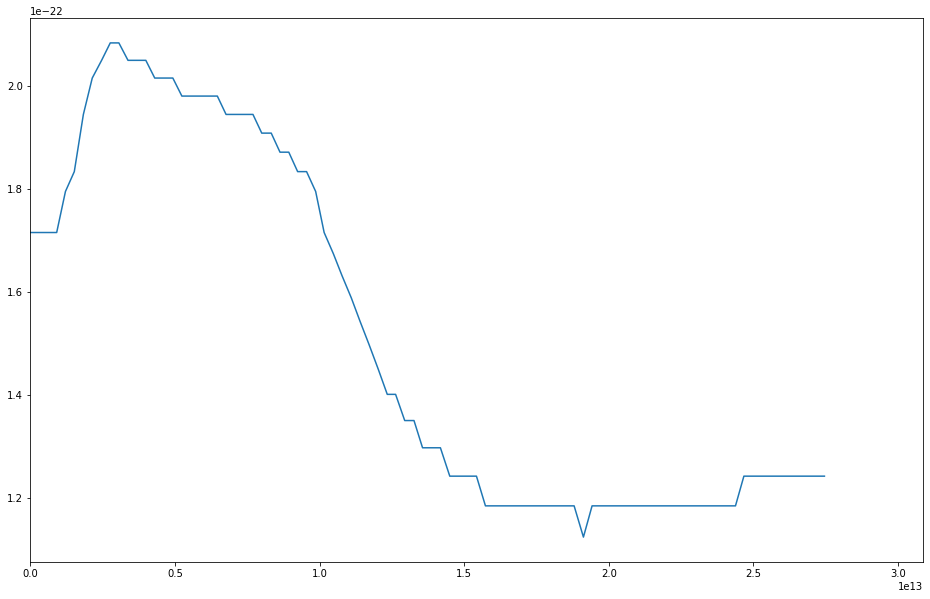

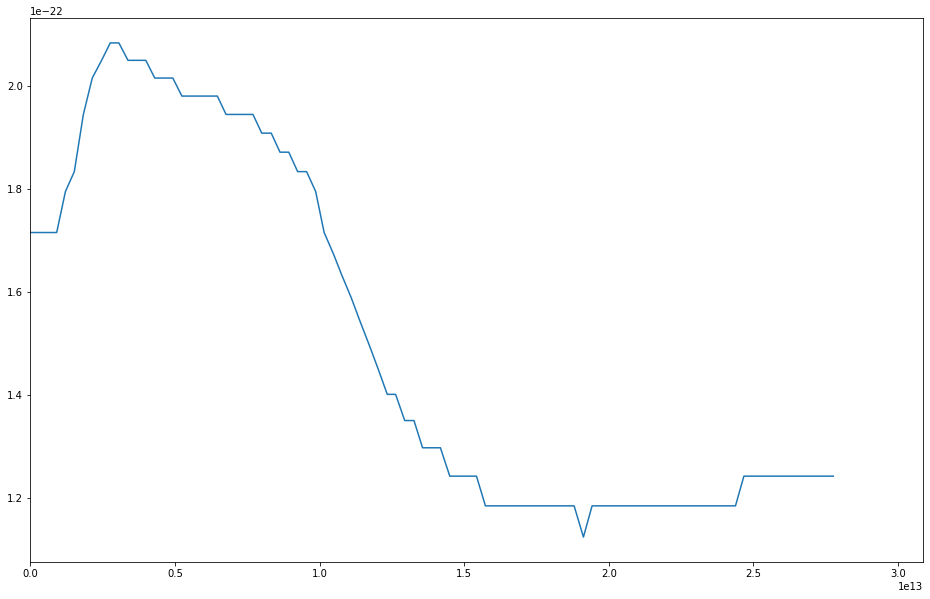

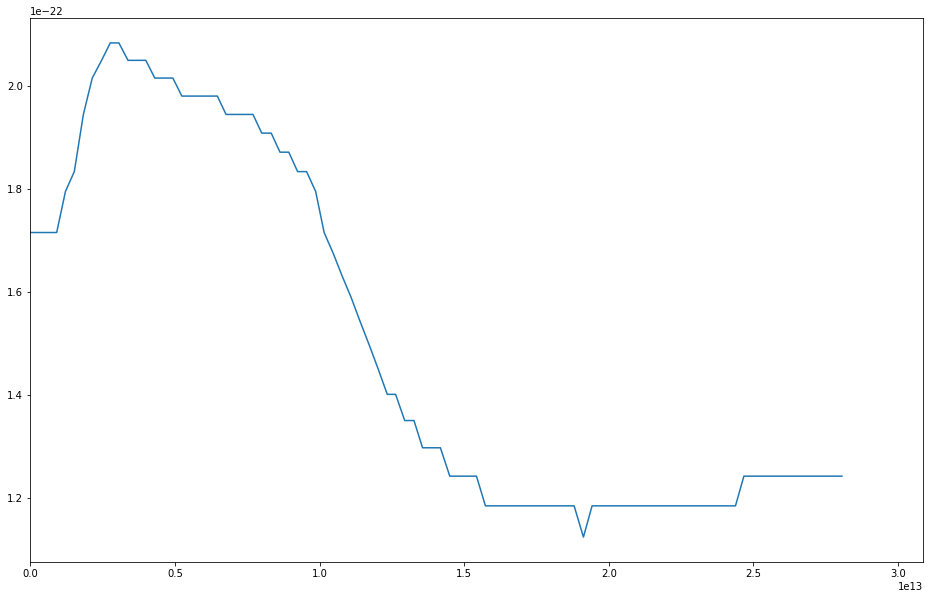

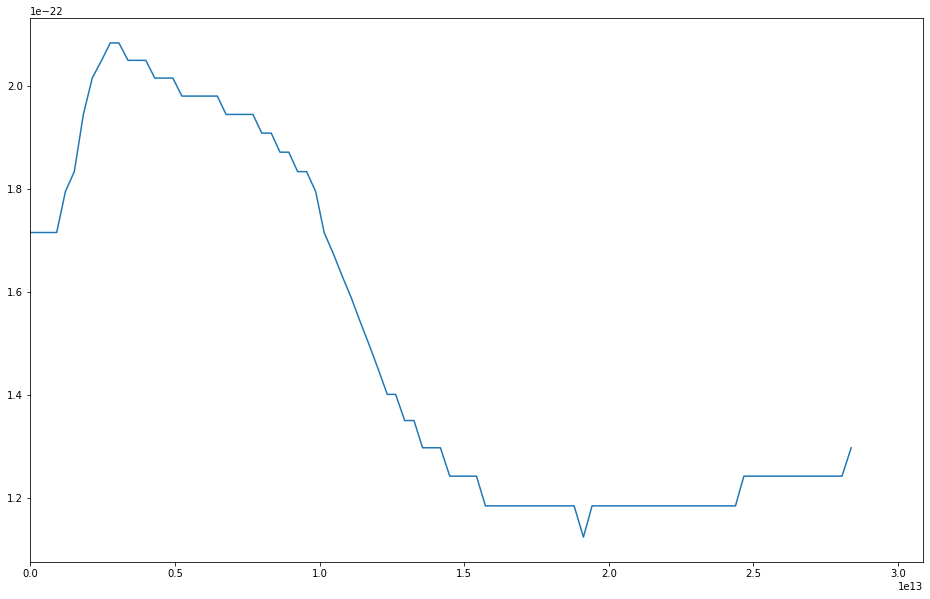

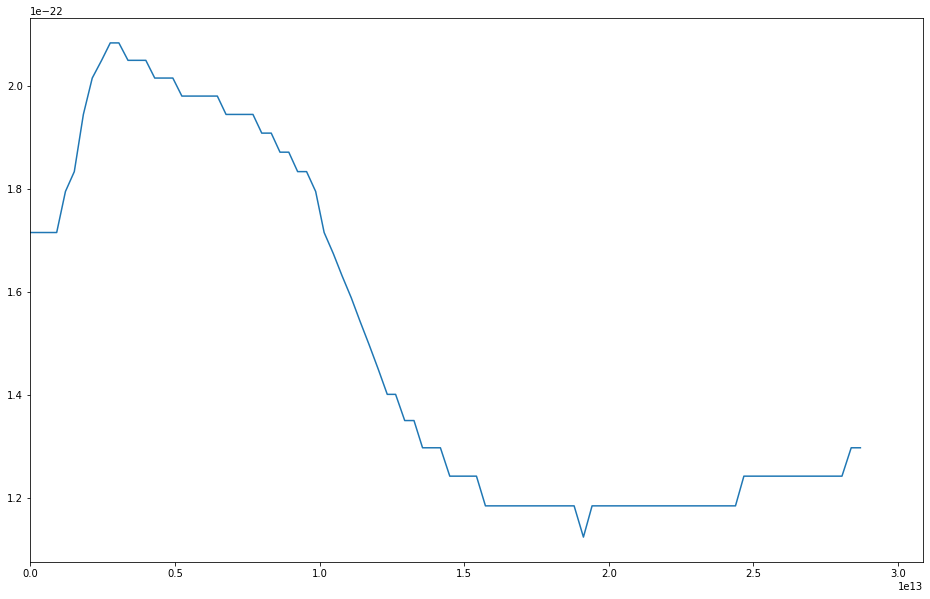

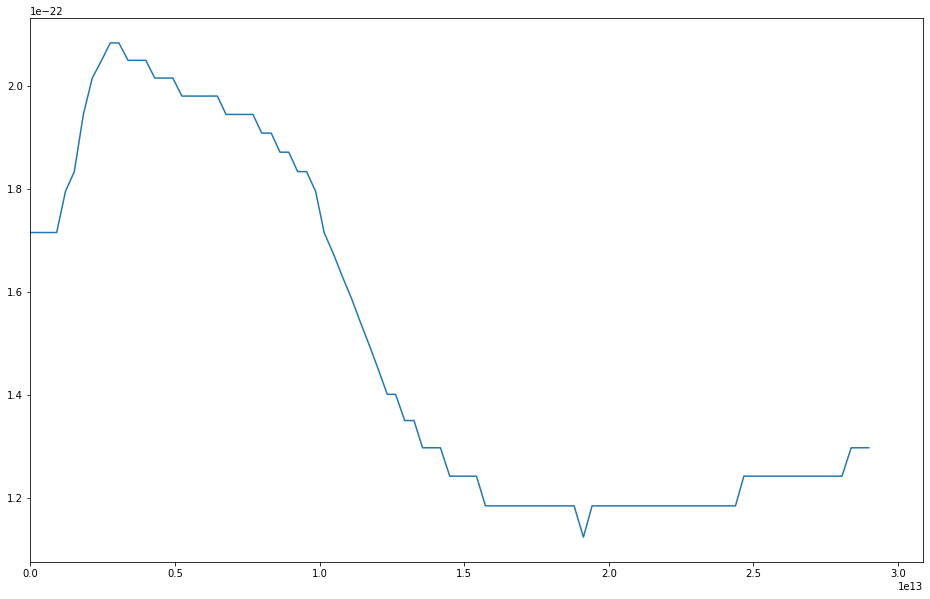

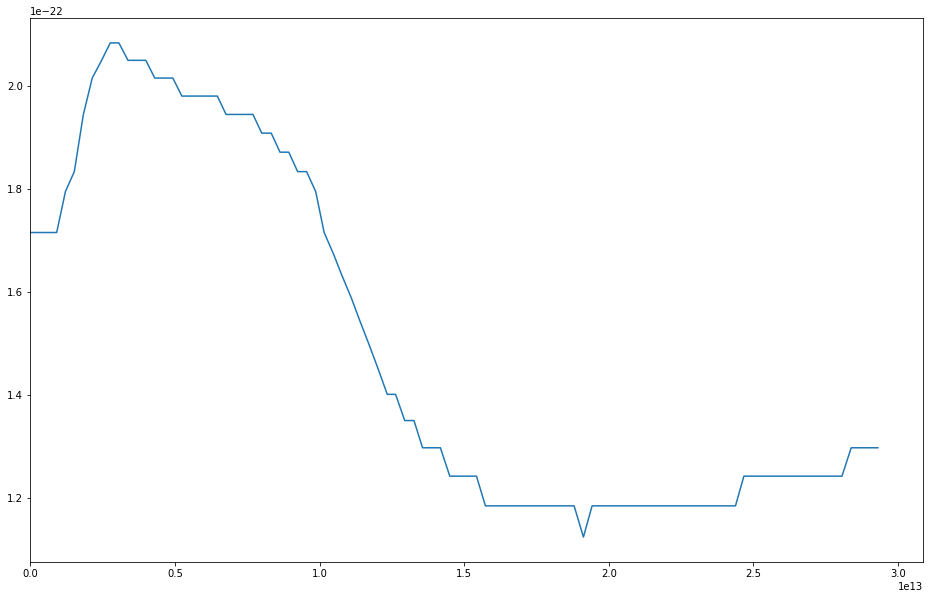

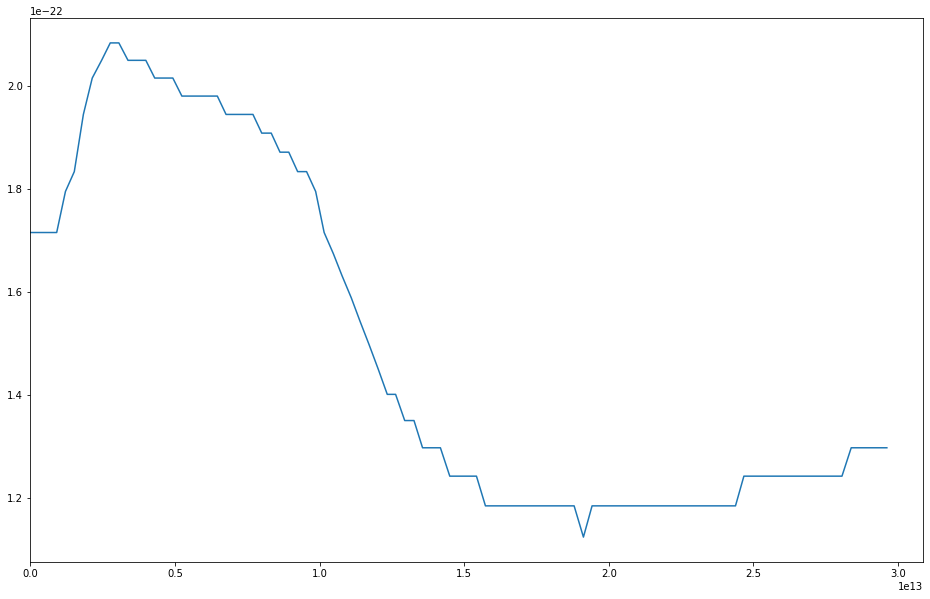

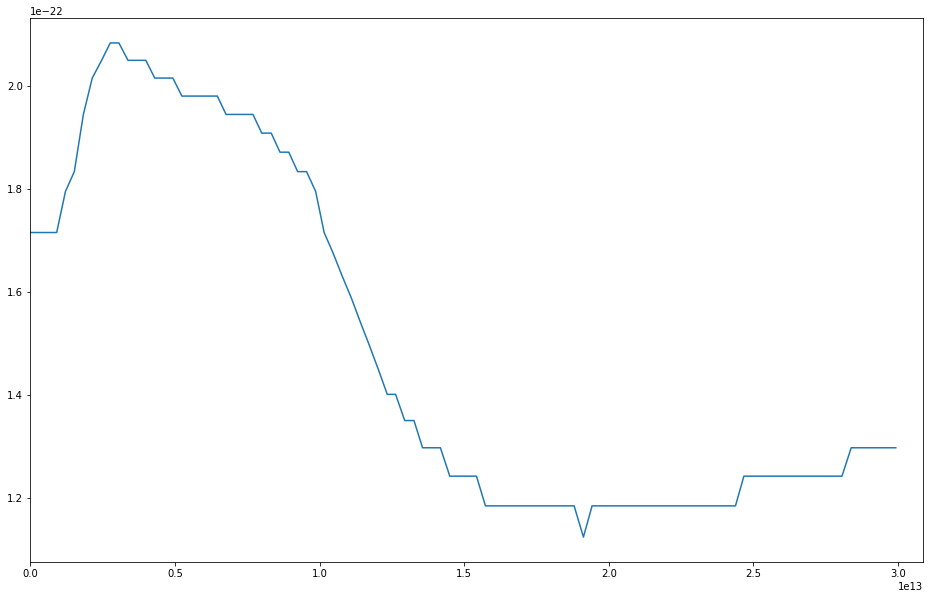

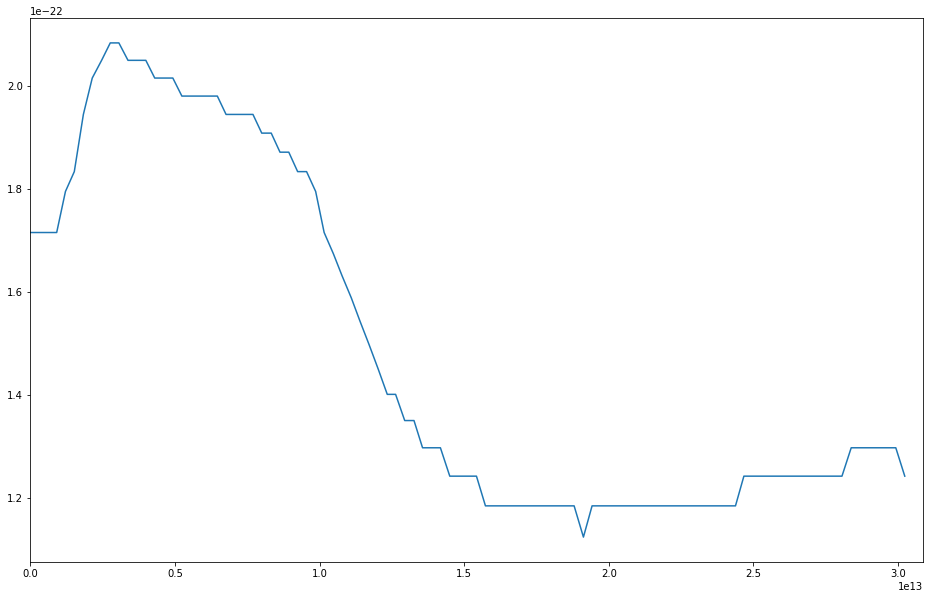

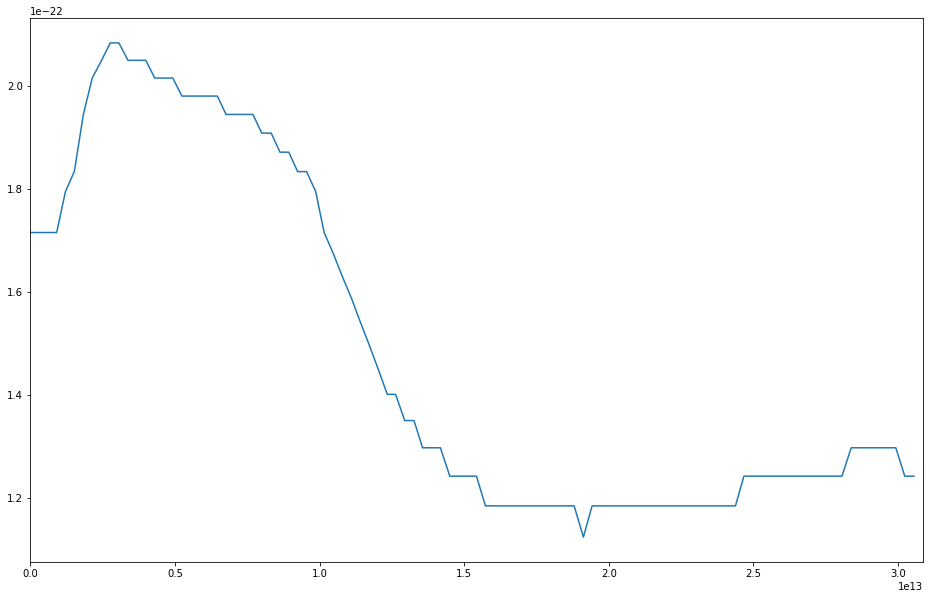

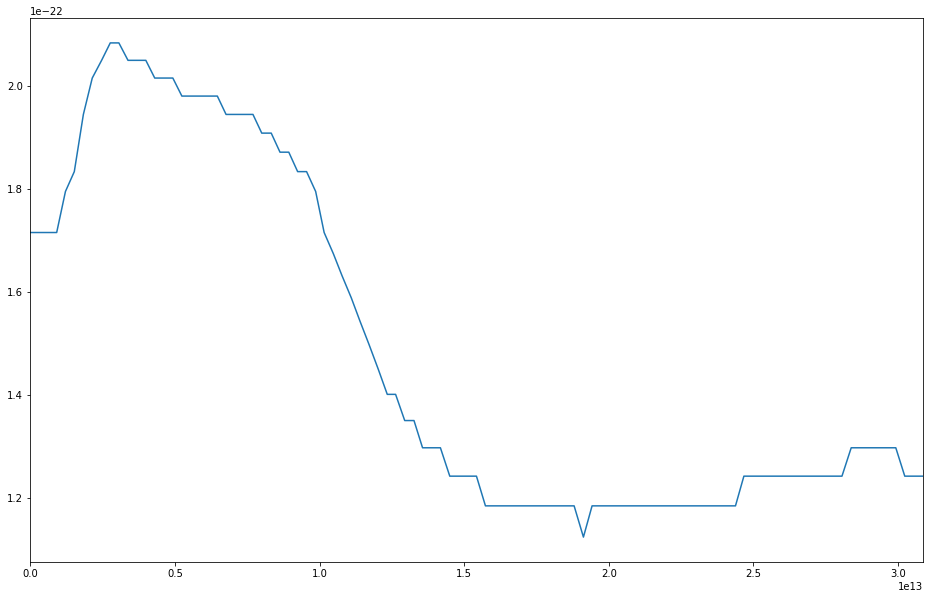

             time     Av. Dens.    Std. Dens.
0    0.000000e+00  1.754301e-22  1.715438e-22
1    2.974473e+11  1.754301e-22  1.715438e-22
2    6.004640e+11  1.754301e-22  1.715438e-22
3    9.153863e+11  1.754301e-22  1.715438e-22
4    1.218385e+12  1.754301e-22  1.795268e-22
..            ...           ...           ...
96   2.961067e+13  1.630102e-22  1.296749e-22
97   2.991968e+13  1.631165e-22  1.296749e-22
98   3.022977e+13  1.632275e-22  1.241543e-22
99   3.054290e+13  1.633455e-22  1.241543e-22
100  3.086000e+13  1.634726e-22  1.241543e-22

[101 rows x 3 columns]


In [13]:
### Create empty lists

t_list = []

av_list = []

std_list = []

rms_mach_list = []


for i in range(0,101):
    
    filename = "data.0{:03d}.vtk".format(i) 
    
    #print(filename)
    
    times, rho, nrh, prs, tr1, tr2, vx1, vx2, tem, meshbounds, meshdimensions = pload_vtk(filename)
    
    # Get i time
    time_i = times[i]
    
    # Diagnostics
    av_density  = np.mean(rho)
    std_density = np.std(rho)
    
    modulus_velocity = np.sqrt(vx1**2 + vx2**2)
    
    #print(av_density, std_density)
    
    # Fill up our empy lists
    
    t_list.append(time_i)
    av_list.append(av_density)
    std_list.append(std_density)
    
    # Plotting
    plt.figure(figsize = (16,10))
    
    plt.plot(t_list, std_list)
    
    plt.xlim(0, np.max(times))
    #plt.ylim(0, 1.e-21)
    plt.show()
    #plt.savefig("/content/drive/My Drive/Colab Notebooks/figures_simulation/std_dens{:03d}.png".format(i))
    plt.close()
    
# Outside the loop, we create a data frame:

df = pd.DataFrame({'time': t_list, 'Av. Dens.': av_list, 'Std. Dens.': std_list})

df.to_csv("/content/drive/My Drive/Colab Notebooks/figures_simulation/datos.csv", sep=',', float_format='{:.2e}'.format)
print(df)

# Animations:

In [14]:
import glob
from PIL import Image

In [15]:
images_in = "/content/drive/My Drive/Colab Notebooks/figures_simulation/dens***.png"

gif_image_out = "/content/drive/My Drive/Colab Notebooks/figures_simulation/animation-dens.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(images_in)))

img = next(imgs)

img.save(fp = gif_image_out, format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)

# Homework:


**## TASK 1:**
Use the make_quiver_plot() function below to make sequential maps of the velocity field.

**## TASK 2:**
Compute the density of each cloud by multiplying rho*tr1 and rho*tr2, then save the results in a 3-column file with time first, then mean cloud-1 density and mean cloud-2 density on the second and third columns. What happens to the density of each cloud? Why?

**## TASK 3:**
Using the code above, animate the figures produced in TASKS 1 and 2. Add them to your presentation.

In [19]:
def make_quiver_plot(meshbounds, meshdimensions, comp_1, comp_2):
    """Make 2D maps"""

    # Create a 2D grid using metadata information

    x = np.linspace(meshbounds[0], meshbounds[1], meshdimensions[0] - 1)
    y = np.linspace(meshbounds[2], meshbounds[3], meshdimensions[1] - 1)

    X, Y = np.meshgrid(x, y)

    # And we are ready to interpolate our data onto the mesh:

    plt.figure(figsize = (12,10))

    Z = plt.quiver(X, Y, vx1, vx2, modulus_velocity, cmap = 'viridis')

    plt.colorbar(Z)

    plt.show()

    #plt.savefig("/content/drive/My Drive/Colab Notebooks/figures_simulation/dens{:03d}.png".format(i))

    plt.close()